In [1]:
# Используем стандартные значения полос во всех функциях ниже
bands_freq = {"delta_min":1,"delta_max":3.5,
              "theta_min":4,"theta_max":6.5,
              "alpha_min":7,"alpha_max":13,
              "beta1_min":14,"beta1_max":20,
              "beta2_min":21,"beta2_max":30,
              "gamma_min":30,"gamma_max":48}

In [2]:
!pip install mnelab

In [3]:
from scipy import linalg
import glob
import scipy
from scipy import fftpack
from scipy.signal import butter, lfilter, hilbert
import scipy.interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import gc
import sys
import os
import os.path, time
import csv

import mne
import mnelab
from mnelab.io import read_raw
from mne import setup_volume_source_space, setup_source_space
from mne.viz import circular_layout, plot_connectivity_circle
from mne import io
from mne.connectivity import spectral_connectivity
from mne.viz import plot_sensors_connectivity
from mne.viz.backends.renderer import _get_renderer

In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    new_signal = lfilter(b, a, data)
    return new_signal

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    new_signal = lfilter(b, a, data)
    return new_signal

def draw_signal(signal_array,end_point,step,label_):
    plt.figure(figsize=(15, 6))
    time_vec_temp = np.arange(0, end_point, step)
    plt.plot(time_vec_temp, signal_array, label=label_)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    
def draw_spectr(signal,_sample_rate,label_):
    # Делаем быстрое преобразование Фурье и необходимые преобразования
    sig_fft = fftpack.fft(signal)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(signal.size, d=1/_sample_rate)
    # Рисуем распределение частот
    plt.figure(figsize=(10, 8))
    plt.plot(abs(sample_freq), power, label=label_)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    
def calculate_percents_per_chan(_signal,_max_chan,_number_levels,_downsampled_length):
    table_chans_absolute = np.empty((nchan,_number_levels),dtype=np.object)
    for chan in range(0,nchan):
        for i in range(0,_number_levels,1):
            table_chans_absolute[chan][i] = 0
    table_chans_percent = np.empty((nchan,_number_levels),dtype=np.object)
    step_for_comparison = _max_chan / _number_levels
    levels = []
    for a in range(0,_number_levels+1,1):
        levels.append(a*step_for_comparison)
    for chan in range(0,nchan):
        for i in range(0,_downsampled_length,1):
            for b in range(0,_number_levels,1):
                if (_signal[chan][i] >= levels[b]) and (_signal[chan][i] < levels[b+1]):
                    table_chans_absolute[chan][b] += 1
                    break
                if _signal[chan][i] >= _max_chan:
                    table_chans_absolute[chan][_number_levels-1] += 1
                    break
    for chan in range(0,nchan):
        for b in range(0,_number_levels,1):
            table_chans_percent[chan][b] = round(table_chans_absolute[chan][b] / _downsampled_length * 100,1)    
    return table_chans_percent
    
def augumenting_electrodes(downsampled_hilbert_signal, down_length):
    augumented_downsampled_hilbert_signal = np.empty((nchan_aug,down_length),dtype=np.object) 
    augumented_downsampled_hilbert_signal[0] = 0.15*0.25*downsampled_hilbert_signal[1]+0.25*downsampled_hilbert_signal[2] #ok
    augumented_downsampled_hilbert_signal[1] = 0.25*downsampled_hilbert_signal[2]+0.25*downsampled_hilbert_signal[3] #ok
    augumented_downsampled_hilbert_signal[2] = 0.15*0.25*downsampled_hilbert_signal[4]+0.25*downsampled_hilbert_signal[3] #ok
    augumented_downsampled_hilbert_signal[3] = downsampled_hilbert_signal[2] #ok
    augumented_downsampled_hilbert_signal[4] = downsampled_hilbert_signal[3] #ok
    augumented_downsampled_hilbert_signal[5] = 0.5*downsampled_hilbert_signal[2] #ok
    augumented_downsampled_hilbert_signal[6] = 0.5*downsampled_hilbert_signal[3] #ok
    augumented_downsampled_hilbert_signal[7] = 0.25*downsampled_hilbert_signal[1] #ok
    augumented_downsampled_hilbert_signal[8] = downsampled_hilbert_signal[1] #ok
    augumented_downsampled_hilbert_signal[9] = 0.5*downsampled_hilbert_signal[1] #ok
    augumented_downsampled_hilbert_signal[10] = 0.5*downsampled_hilbert_signal[4] #ok
    augumented_downsampled_hilbert_signal[11] = downsampled_hilbert_signal[4] #ok
    augumented_downsampled_hilbert_signal[12] = 0.25*downsampled_hilbert_signal[4] #ok
    augumented_downsampled_hilbert_signal[13] = 0.5*downsampled_hilbert_signal[0] #ok
    augumented_downsampled_hilbert_signal[14] = 0.5*downsampled_hilbert_signal[5] #ok
    augumented_downsampled_hilbert_signal[15] = downsampled_hilbert_signal[0] #ok
    augumented_downsampled_hilbert_signal[16] = downsampled_hilbert_signal[5] #ok
    augumented_downsampled_hilbert_signal[17] = 0.15*0.25*downsampled_hilbert_signal[1]+0.25*downsampled_hilbert_signal[0] #ok
    augumented_downsampled_hilbert_signal[18] = 0.25*downsampled_hilbert_signal[0]+0.25*downsampled_hilbert_signal[5] #ok
    augumented_downsampled_hilbert_signal[19] = 0.15*0.25*downsampled_hilbert_signal[4]+0.25*downsampled_hilbert_signal[5] #ok
    return augumented_downsampled_hilbert_signal

def weightedhead_chans(_table_percent,_number_levels):
    _weightedhead_chans = np.empty((nchan,1),dtype=np.object)
    for chan in range(0,nchan):
        temp_sum = 0
        for i in range(0,_number_levels,1):
            temp_sum += _table_percent[chan][i] / 100 * (i+1)
        _weightedhead_chans[chan] = temp_sum
    return _weightedhead_chans

In [5]:
# функция очистки сигнала по максимальной амплитуде - удаляем кусочки длиной _part_length, которые выше _threshhold
def clearing_signal(_signal,_part_length,_sample_rate,_threshhold,_nchan):
    _num_parts = int(len(_signal[0,:])/_sample_rate/_part_length)
    temp_cleared_signal = np.empty((_nchan,_num_parts),dtype=np.object)
    temp_bad_parts = []
    for j in range(0,_nchan):
        for i in range(0,_num_parts):
            temp_cleared_signal[j,i] = _signal[j,int(i*_sample_rate*_part_length):int((i+1)*_sample_rate*_part_length)]
            if np.max(abs(_signal[j,int(i*_sample_rate*_part_length):int((i+1)*_sample_rate*_part_length)])) > _threshhold:
                if i not in temp_bad_parts:
                    temp_bad_parts.append(i)
    
    cleared_signal = np.empty((_nchan,_num_parts-len(temp_bad_parts)),dtype=np.object)
    for i in range(0,_nchan):
        cleared_signal[i] = np.delete(temp_cleared_signal[i],temp_bad_parts)
    
    cleared_signal_noparts = np.empty((_nchan),dtype=np.object)
    for i in range(0,_nchan):
        temp_signal = []
        for j in range(0,_num_parts-len(temp_bad_parts)):
            for k in range(0,len(cleared_signal[i][j])):
                temp_signal.append(cleared_signal[i][j][k])
        cleared_signal_noparts[i] = temp_signal
    
    temp_matrix_return = np.zeros((_nchan,len(cleared_signal_noparts[0])))
    for i in range(0,_nchan):
        for j in range(0,len(cleared_signal_noparts[0])):
            temp_matrix_return[i,j] = cleared_signal_noparts[i][j]
    
    return temp_matrix_return

In [6]:
def create_percent_table(_signal,_sample_rate,_length,_downsampled_coeff,_max_chan,_number_levels):
    # Создаем сигналы по выбранным наборам частот
    delta_signal = np.empty((nchan,_length),dtype=np.object)
    theta_signal = np.empty((nchan,_length),dtype=np.object)
    alpha_signal = np.empty((nchan,_length),dtype=np.object)
    beta1_signal = np.empty((nchan,_length),dtype=np.object)
    beta2_signal = np.empty((nchan,_length),dtype=np.object)
    gamma_signal = np.empty((nchan,_length),dtype=np.object)
    for chan in range(0,nchan):
        delta_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["delta_min"],bands_freq["delta_max"],_sample_rate,4)
        theta_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["theta_min"],bands_freq["theta_max"],_sample_rate,5)
        alpha_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],_sample_rate,5)
        beta1_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],_sample_rate,6)
        beta2_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],_sample_rate,8)
        gamma_signal[chan] = butter_bandpass_filter(_signal[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],_sample_rate,9)    
    print("Signal bands created")
    
    # работаем с огибающей
    hilbert_delta_signal = np.empty((nchan,_length),dtype=np.object)
    hilbert_theta_signal = np.empty((nchan,_length),dtype=np.object)
    hilbert_alpha_signal = np.empty((nchan,_length),dtype=np.object)
    hilbert_beta1_signal = np.empty((nchan,_length),dtype=np.object)
    hilbert_beta2_signal = np.empty((nchan,_length),dtype=np.object)
    hilbert_gamma_signal = np.empty((nchan,_length),dtype=np.object)
    for chan in range(0,nchan):
        hilbert_delta_signal[chan] = np.abs(hilbert(delta_signal[chan]))
        hilbert_theta_signal[chan] = np.abs(hilbert(theta_signal[chan]))
        hilbert_alpha_signal[chan] = np.abs(hilbert(alpha_signal[chan]))
        hilbert_beta1_signal[chan] = np.abs(hilbert(beta1_signal[chan]))
        hilbert_beta2_signal[chan] = np.abs(hilbert(beta2_signal[chan]))
        hilbert_gamma_signal[chan] = np.abs(hilbert(gamma_signal[chan]))
        print("Hilbert Channel " + str(chan) + " completed")
    print("Hilbert completed")
    
    # уменьшаем размерность сигнала для рисования
    downsampled_length = int(round(_length/_downsampled_coeff,0))
    downsampled_hilbert_delta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    downsampled_hilbert_theta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    downsampled_hilbert_alpha_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    downsampled_hilbert_beta1_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    downsampled_hilbert_beta2_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    downsampled_hilbert_gamma_signal = np.empty((nchan,downsampled_length),dtype=np.object)
    for chan in range(0,nchan):
        counter_downsampled = 0
        for i in range(0,_length,_downsampled_coeff):
            temp_sum_delta = 0
            temp_sum_theta = 0
            temp_sum_alpha = 0
            temp_sum_beta1 = 0
            temp_sum_beta2 = 0
            temp_sum_gamma = 0
            for j in range(0,_downsampled_coeff,1):
                temp_sum_delta += hilbert_delta_signal[chan][i+j]
                temp_sum_theta += hilbert_theta_signal[chan][i+j]
                temp_sum_alpha += hilbert_alpha_signal[chan][i+j]
                temp_sum_beta1 += hilbert_beta1_signal[chan][i+j]
                temp_sum_beta2 += hilbert_beta2_signal[chan][i+j]
                temp_sum_gamma += hilbert_gamma_signal[chan][i+j]
            downsampled_hilbert_delta_signal[chan][counter_downsampled] = temp_sum_delta/_downsampled_coeff
            downsampled_hilbert_theta_signal[chan][counter_downsampled] = temp_sum_theta/_downsampled_coeff
            downsampled_hilbert_alpha_signal[chan][counter_downsampled] = temp_sum_alpha/_downsampled_coeff
            downsampled_hilbert_beta1_signal[chan][counter_downsampled] = temp_sum_beta1/_downsampled_coeff
            downsampled_hilbert_beta2_signal[chan][counter_downsampled] = temp_sum_beta2/_downsampled_coeff
            downsampled_hilbert_gamma_signal[chan][counter_downsampled] = temp_sum_gamma/_downsampled_coeff
            counter_downsampled += 1
    print("Downsampled completed")
    
    # считаем процентные распределения по уровням
    table_chans_percent_delta = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_theta = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_alpha = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_beta1 = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_beta2 = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_gamma = np.empty((nchan,_number_levels),dtype=np.object)
    table_chans_percent_delta = calculate_percents_per_chan(downsampled_hilbert_delta_signal,_max_chan,_number_levels,downsampled_length)
    table_chans_percent_theta = calculate_percents_per_chan(downsampled_hilbert_theta_signal,_max_chan,_number_levels,downsampled_length)
    table_chans_percent_alpha = calculate_percents_per_chan(downsampled_hilbert_alpha_signal,_max_chan,_number_levels,downsampled_length)
    table_chans_percent_beta1 = calculate_percents_per_chan(downsampled_hilbert_beta1_signal,_max_chan,_number_levels,downsampled_length)
    table_chans_percent_beta2 = calculate_percents_per_chan(downsampled_hilbert_beta2_signal,_max_chan,_number_levels,downsampled_length)
    table_chans_percent_gamma = calculate_percents_per_chan(downsampled_hilbert_gamma_signal,_max_chan,_number_levels,downsampled_length)
    print("Percentage distribution completed")
    
    all_bands_tables_percentage = np.empty((6,nchan,_number_levels),dtype=np.object)
    all_bands_tables_percentage[0][:][:] = table_chans_percent_delta
    all_bands_tables_percentage[1][:][:] = table_chans_percent_theta
    all_bands_tables_percentage[2][:][:] = table_chans_percent_alpha
    all_bands_tables_percentage[3][:][:] = table_chans_percent_beta1
    all_bands_tables_percentage[4][:][:] = table_chans_percent_beta2
    all_bands_tables_percentage[5][:][:] = table_chans_percent_gamma
    print("All bands processing completed")
    
    return all_bands_tables_percentage

# читаем файлы 

In [34]:
# читаем файлы https://mne.tools/stable/generated/mne.io.read_raw_edf.html
edffile_state1 = "C:\\Users\\ww\\Documents\\ph_records\\open_before.edf"
edffile_state2 = "C:\\Users\\ww\\Documents\\ph_records\\close_before.edf"
edffile_state3 = "C:\\Users\\ww\\Documents\\ph_records\\play1.edf"
edffile_state4 = "C:\\Users\\ww\\Documents\\ph_records\\play2.edf"
edffile_state5 = "C:\\Users\\ww\\Documents\\ph_records\\open_after.edf"
edffile_state6 = "C:\\Users\\ww\\Documents\\ph_records\\close_after.edf"

raw_mne1 = mne.io.read_raw_edf(edffile_state1, preload=True)
print(raw_mne1.n_times)
print(raw_mne1.ch_names)
print(raw_mne1.info)
print(raw_mne1.info['sfreq'])
print(raw_mne1.get_data().shape)

raw_mne2 = mne.io.read_raw_edf(edffile_state2, preload=True)
print(raw_mne2.n_times)
print(raw_mne2.ch_names)
print(raw_mne2.info)
print(raw_mne2.info['sfreq'])
print(raw_mne2.get_data().shape)
raw_mne3 = mne.io.read_raw_edf(edffile_state3, preload=True)
raw_mne4 = mne.io.read_raw_edf(edffile_state4, preload=True)
raw_mne5 = mne.io.read_raw_edf(edffile_state5, preload=True)
raw_mne6 = mne.io.read_raw_edf(edffile_state6, preload=True)

Extracting EDF parameters from C:\Users\ww\Documents\ph_records\open_before.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11624  =      0.000 ...    92.992 secs...
11625
['O1', 'T3', 'F3', 'F4', 'T4', 'O2']
<Info | 7 non-empty values
 bads: []
 ch_names: O1, T3, F3, F4, T4, O2
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 2.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2021-04-15 18:13:15 UTC
 nchan: 6
 projs: []
 sfreq: 125.0 Hz
>
125.0
(6, 11625)
Extracting EDF parameters from C:\Users\ww\Documents\ph_records\close_before.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15374  =      0.000 ...   122.992 secs...
15375
['O1', 'T3', 'F3', 'F4', 'T4', 'O2']
<Info | 7 non-empty values
 bads: []
 ch_names: O1, T3, F3, F4, T4, O2
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 2.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2021-04-15 18:15:27 UTC
 nchan: 6
 projs: []
 sfreq: 125.0 Hz
>
125.0
(6

In [35]:
edffile_state5 = "C:\\Users\\ww\\Documents\\ph_records\\open_after.edf"
raw_mne5 = mne.io.read_raw_edf(edffile_state5, preload=True)
sample_rate5 = raw_mne5.info['sfreq']
file_with_record5 = raw_mne5.get_data()
length5 = len(file_with_record5[nchan-1])

Extracting EDF parameters from C:\Users\ww\Documents\ph_records\open_after.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7499  =      0.000 ...    59.992 secs...


In [36]:
# Задаем константы
nchan = 6

# Частоты дискретизации файлов
sample_rate1 = raw_mne1.info['sfreq']
sample_rate2 = raw_mne2.info['sfreq']
sample_rate3 = raw_mne3.info['sfreq']
sample_rate4 = raw_mne4.info['sfreq']
sample_rate5 = raw_mne5.info['sfreq']
sample_rate6 = raw_mne6.info['sfreq']

# Массивы для дальнейшей работы, 
# первая размерность - номер канала ['O1', 'T3', 'F3', 'F4', 'T4', 'O2']
# вторая размерность - значения сигнала
file_with_record1 = raw_mne1.get_data()
file_with_record2 = raw_mne2.get_data()
file_with_record3 = raw_mne3.get_data()
file_with_record4 = raw_mne4.get_data()
file_with_record5 = raw_mne5.get_data()
file_with_record6 = raw_mne6.get_data()

# Длины записей в количестве отсчетов
length1 = len(file_with_record1[nchan-1])
print(length1)
length2 = len(file_with_record2[nchan-1])
print(length2)
length3 = len(file_with_record3[nchan-1])
print(length3)
length4 = len(file_with_record4[nchan-1])
print(length4)
length5 = len(file_with_record5[nchan-1])
print(length5)
length6 = len(file_with_record6[nchan-1])
print(length6)

11625
15375
13500
13750
7500
10125


# смотрим спектры 

# открытые глаза до тр 

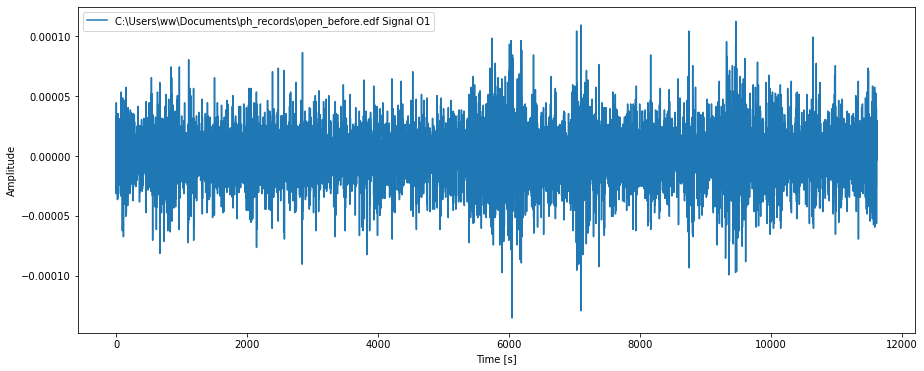

<Figure size 432x288 with 0 Axes>

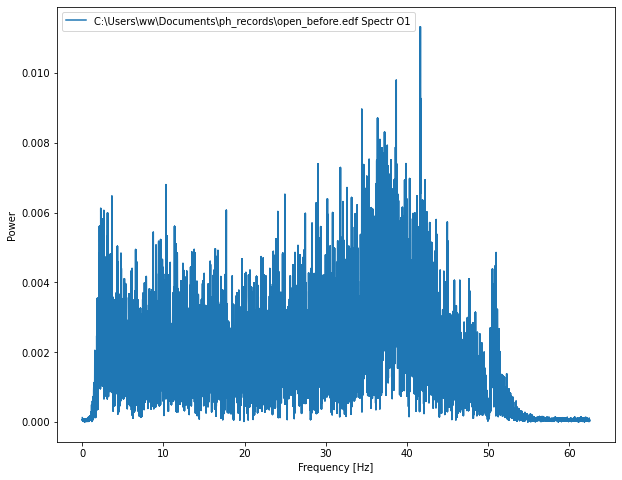

<Figure size 432x288 with 0 Axes>

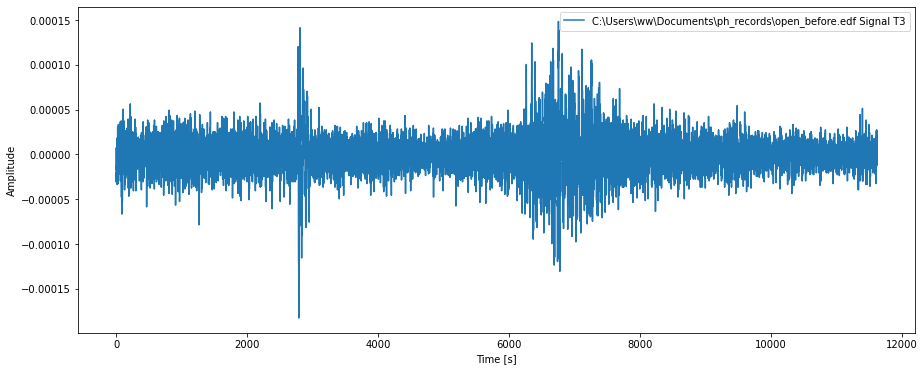

<Figure size 432x288 with 0 Axes>

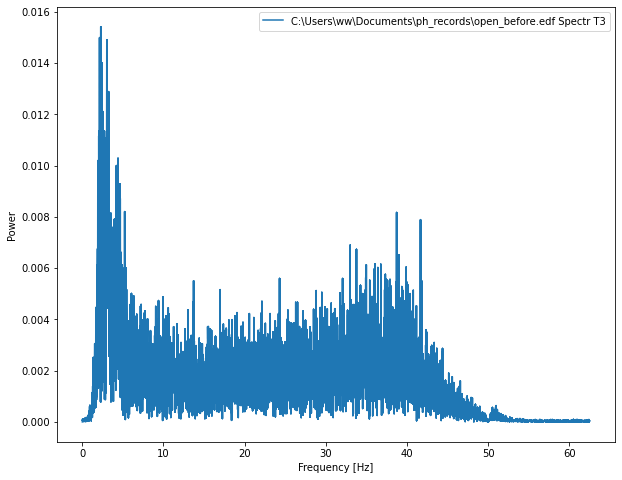

<Figure size 432x288 with 0 Axes>

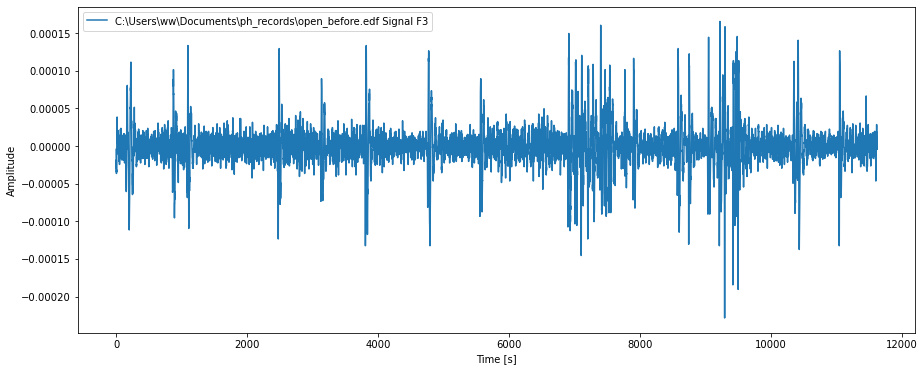

<Figure size 432x288 with 0 Axes>

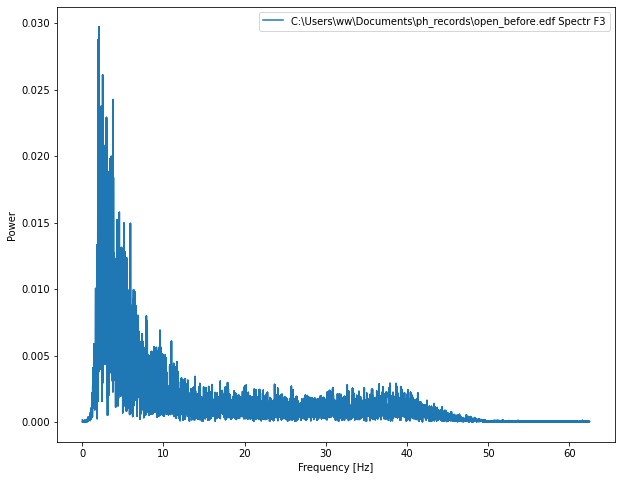

<Figure size 432x288 with 0 Axes>

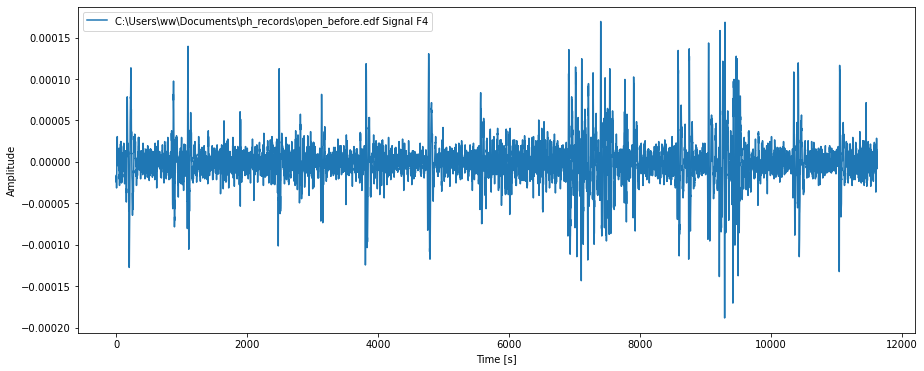

<Figure size 432x288 with 0 Axes>

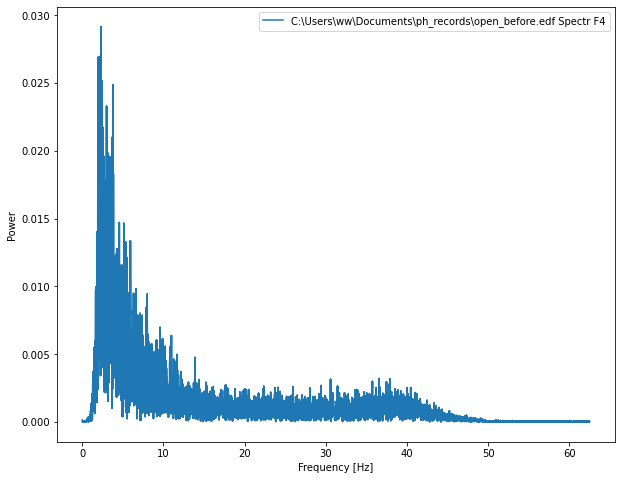

<Figure size 432x288 with 0 Axes>

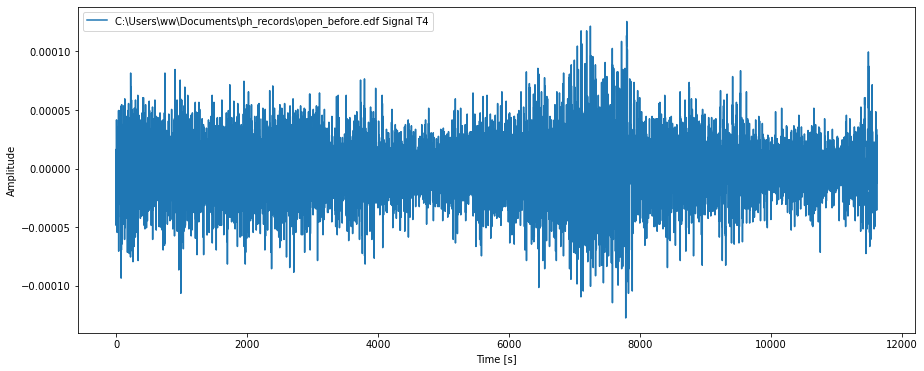

<Figure size 432x288 with 0 Axes>

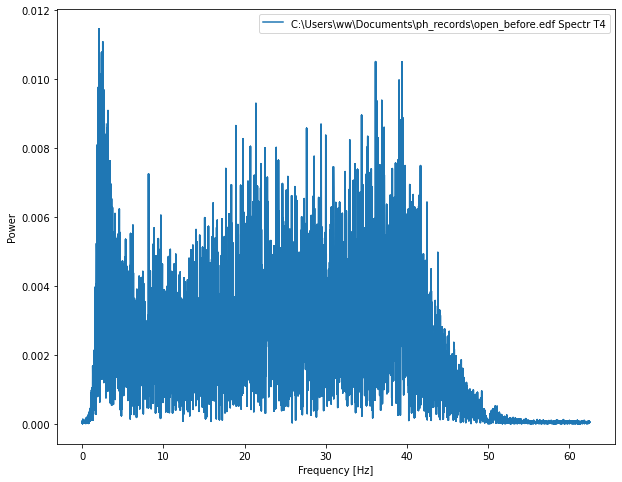

<Figure size 432x288 with 0 Axes>

In [37]:
# Порисуем файлы, выставляем корректно lables
# ЦЕЛЬ - проверить, что надо отфильтровать, какие куски вырезать

# внимательно ставим все параметры для обработки 
length_main = length1
file_with_record_main = file_with_record1
sample_rate_main = sample_rate1
edffile_main = edffile_state1

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main[chan],length_main,1,edffile_main+' Signal '+raw_mne1.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main[chan],sample_rate_main,edffile_main+' Spectr '+raw_mne1.ch_names[chan])

# открытые глаза после тр

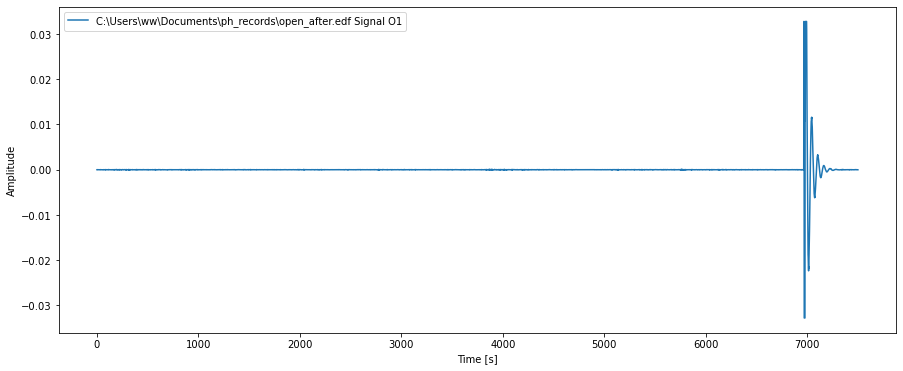

<Figure size 432x288 with 0 Axes>

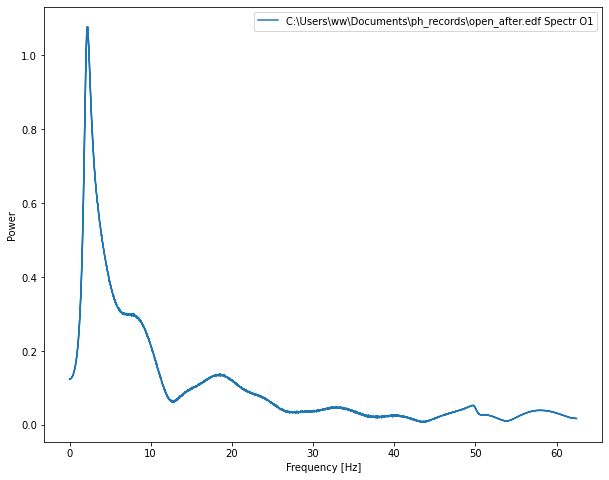

<Figure size 432x288 with 0 Axes>

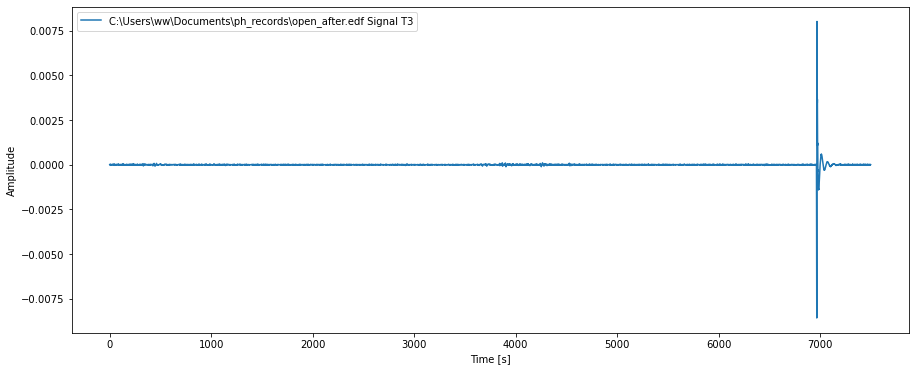

<Figure size 432x288 with 0 Axes>

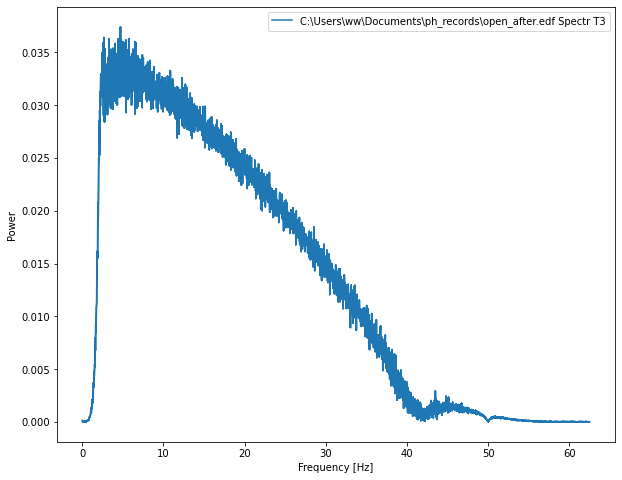

<Figure size 432x288 with 0 Axes>

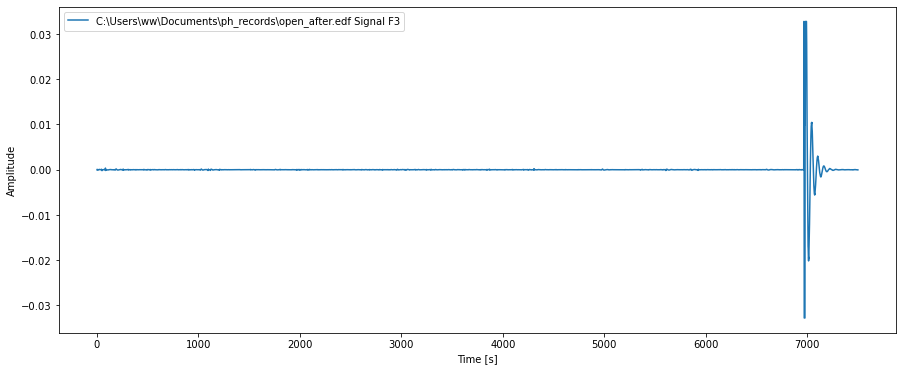

<Figure size 432x288 with 0 Axes>

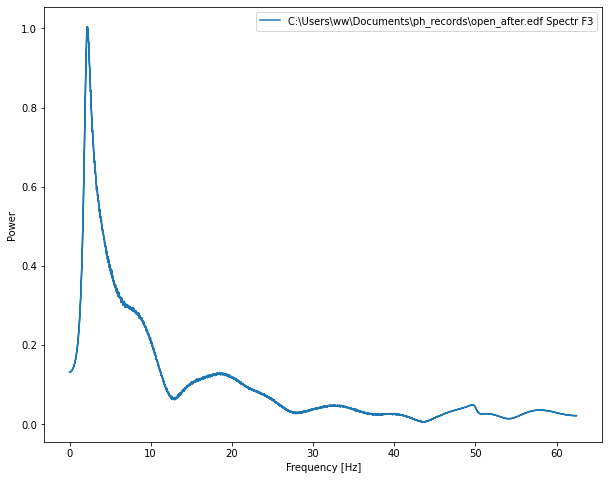

<Figure size 432x288 with 0 Axes>

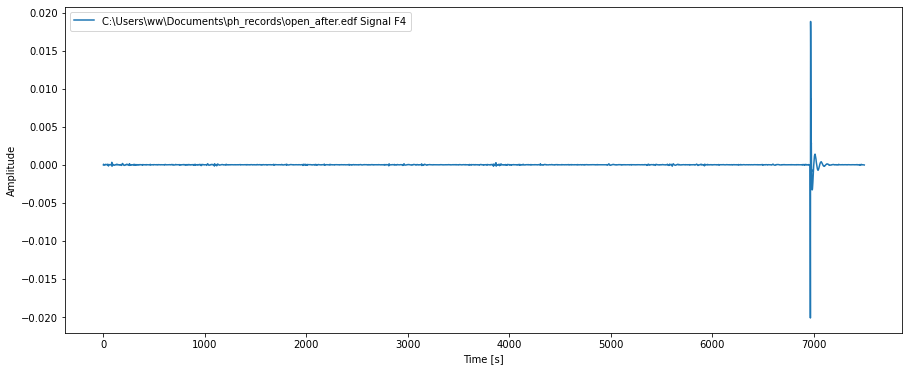

<Figure size 432x288 with 0 Axes>

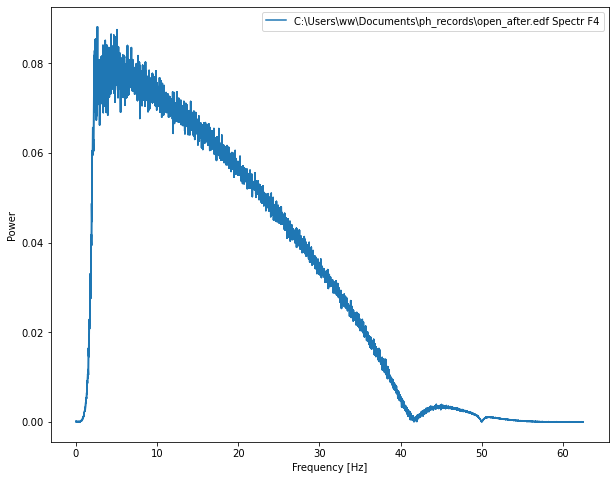

<Figure size 432x288 with 0 Axes>

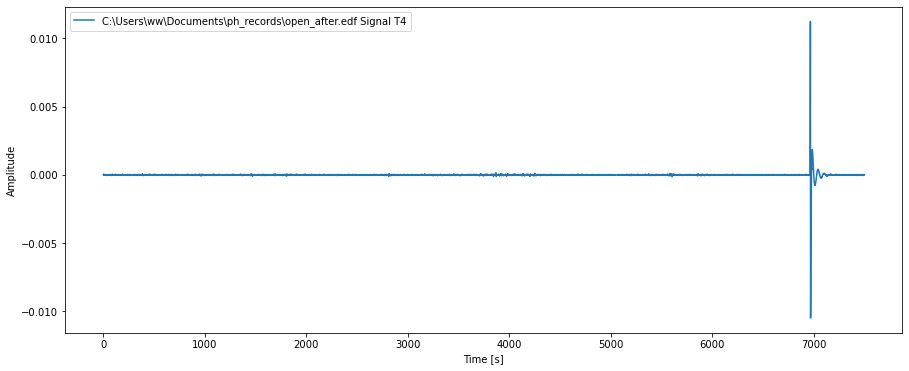

<Figure size 432x288 with 0 Axes>

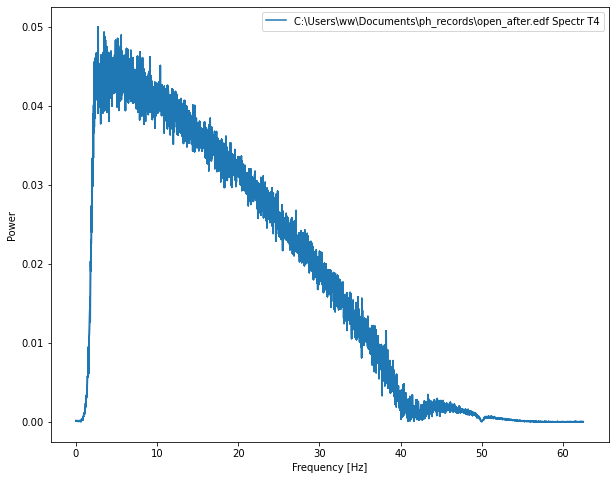

<Figure size 432x288 with 0 Axes>

In [38]:

length_main5 = length5
file_with_record_main5 = file_with_record5
sample_rate_main5 = sample_rate5
edffile_main5 = edffile_state5

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main5[chan],length_main5,1,edffile_main5+' Signal '+raw_mne5.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main5[chan],sample_rate_main5,edffile_main5+' Spectr '+raw_mne5.ch_names[chan])

# игра 1

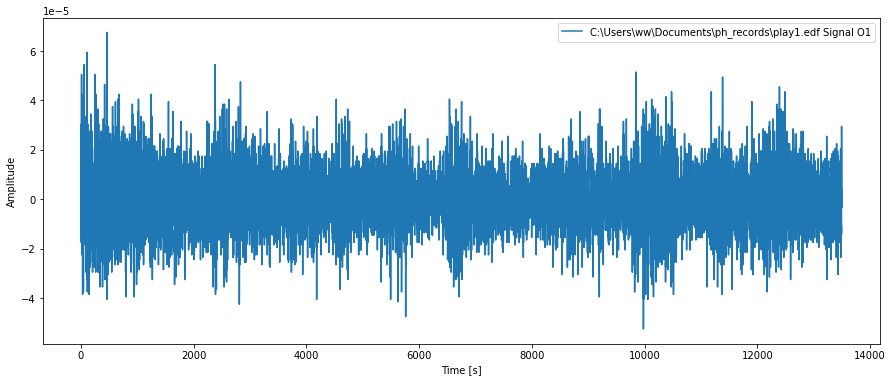

<Figure size 432x288 with 0 Axes>

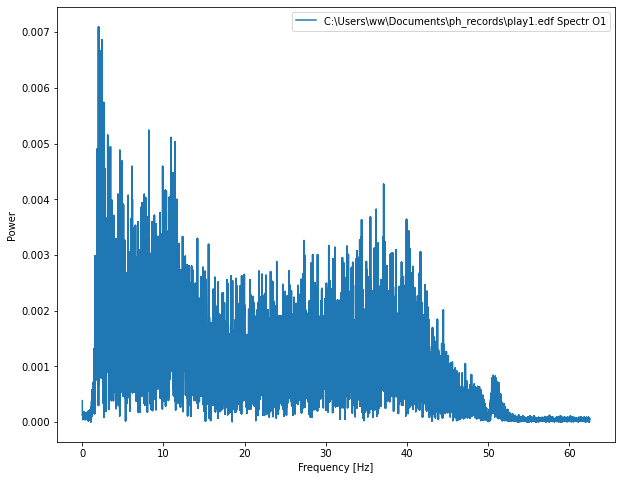

<Figure size 432x288 with 0 Axes>

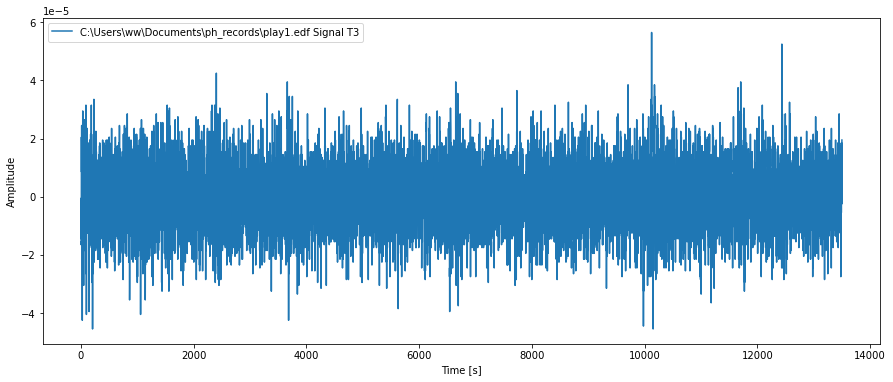

<Figure size 432x288 with 0 Axes>

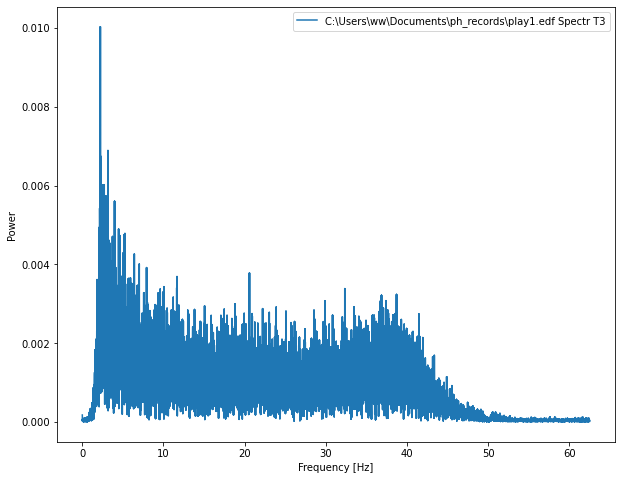

<Figure size 432x288 with 0 Axes>

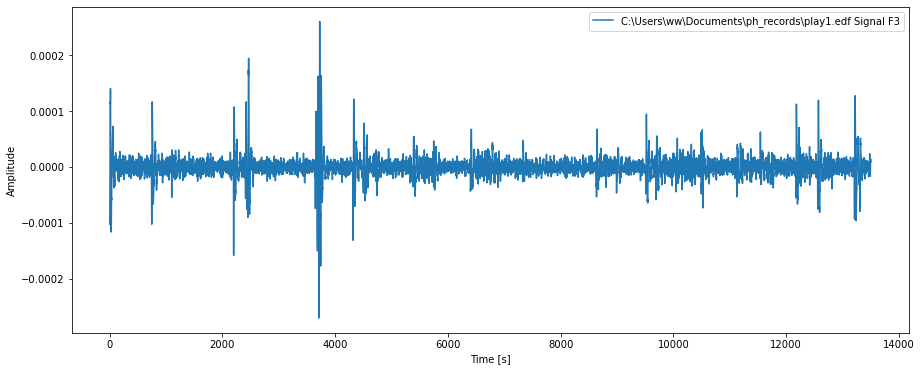

<Figure size 432x288 with 0 Axes>

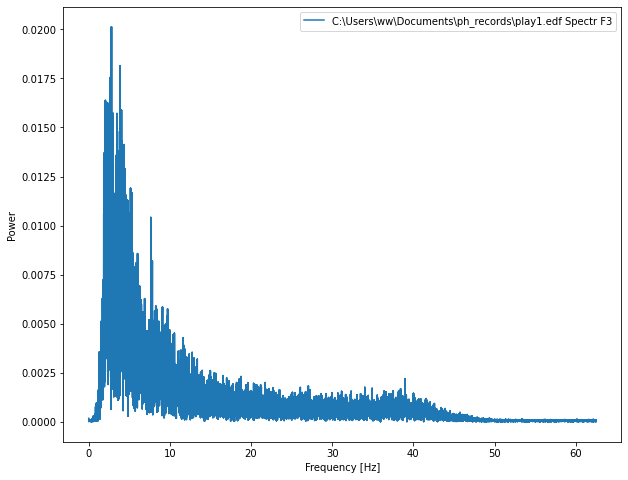

<Figure size 432x288 with 0 Axes>

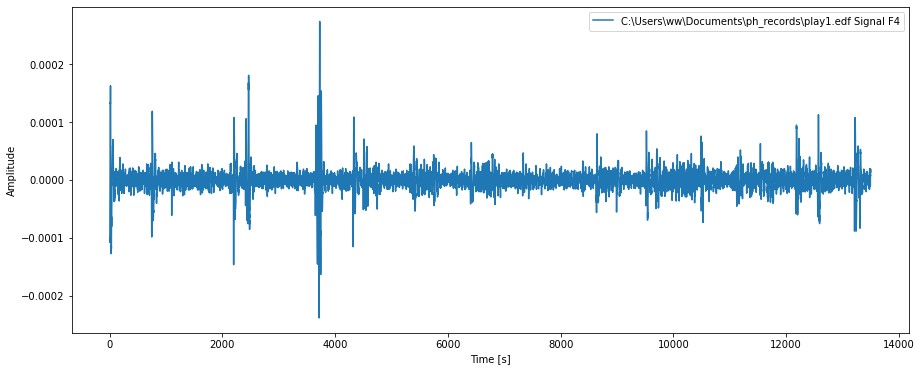

<Figure size 432x288 with 0 Axes>

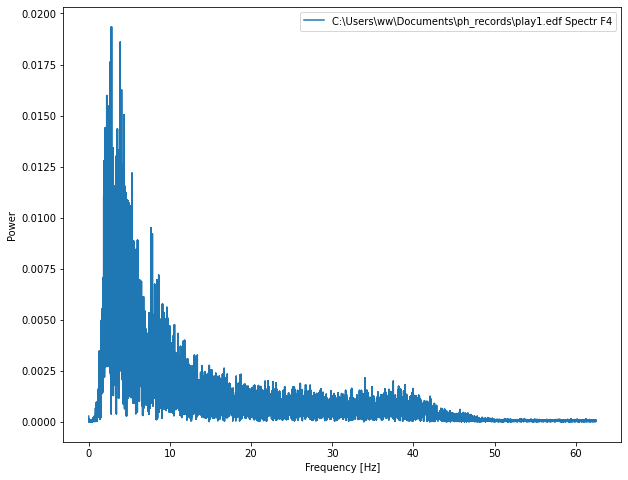

<Figure size 432x288 with 0 Axes>

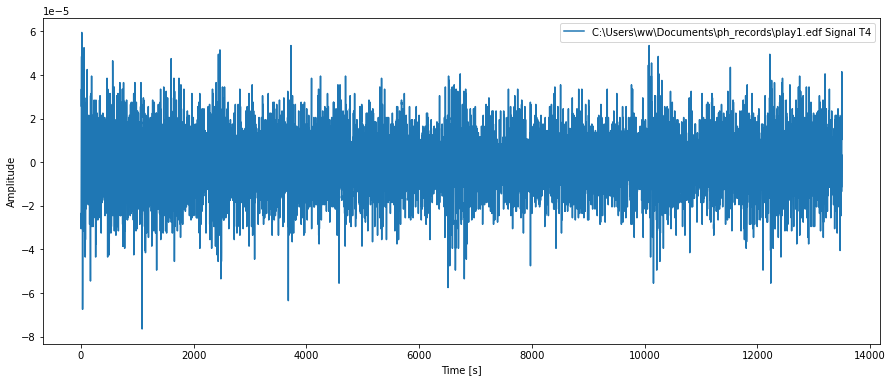

<Figure size 432x288 with 0 Axes>

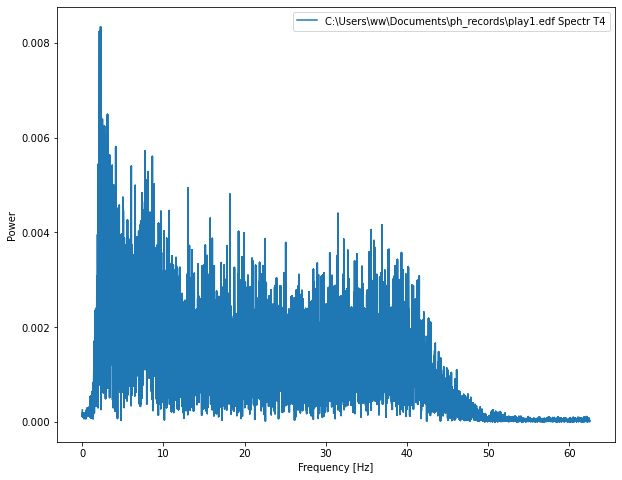

<Figure size 432x288 with 0 Axes>

In [39]:
### play1 
length_main3 = length3
file_with_record_main3 = file_with_record3
sample_rate_main3 = sample_rate3
edffile_main3 = edffile_state3

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main3[chan],length_main3,1,edffile_main3+' Signal '+raw_mne3.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main3[chan],sample_rate_main3,edffile_main3+' Spectr '+raw_mne3.ch_names[chan])

# закрытые глаза после тр 

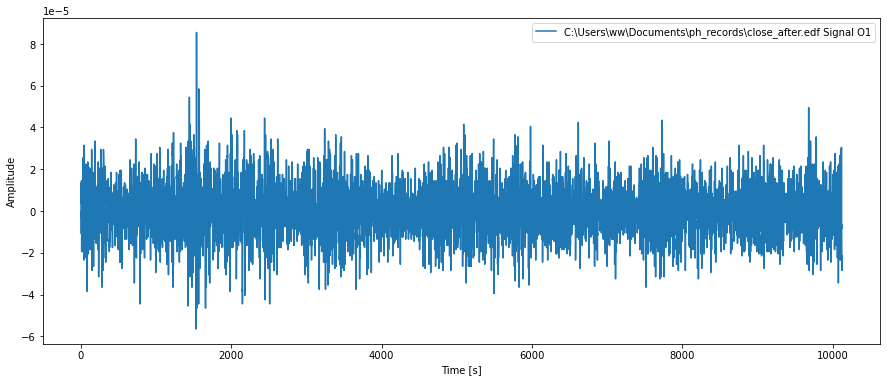

<Figure size 432x288 with 0 Axes>

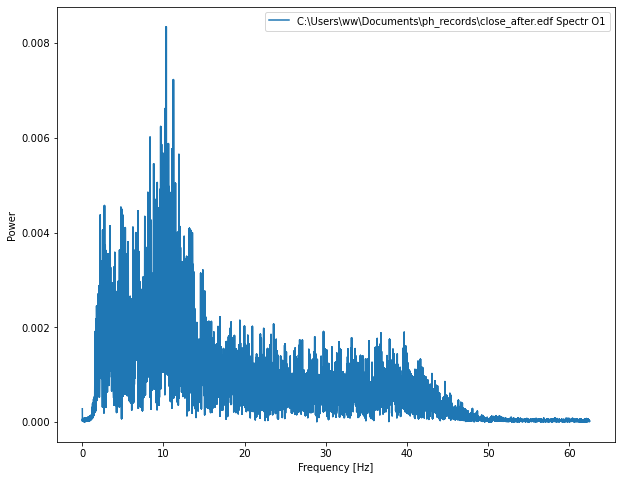

<Figure size 432x288 with 0 Axes>

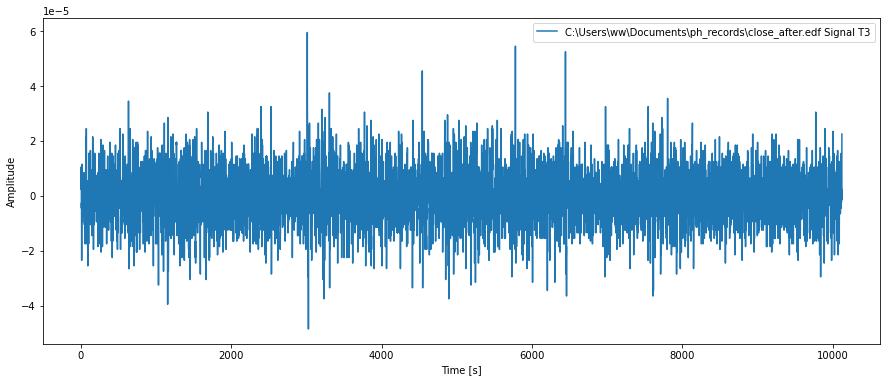

<Figure size 432x288 with 0 Axes>

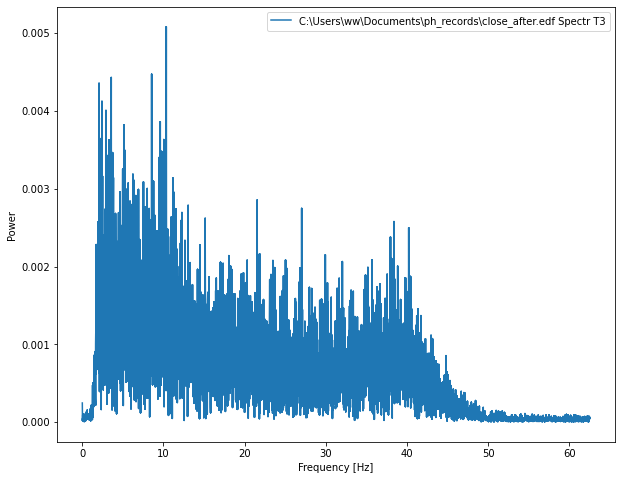

<Figure size 432x288 with 0 Axes>

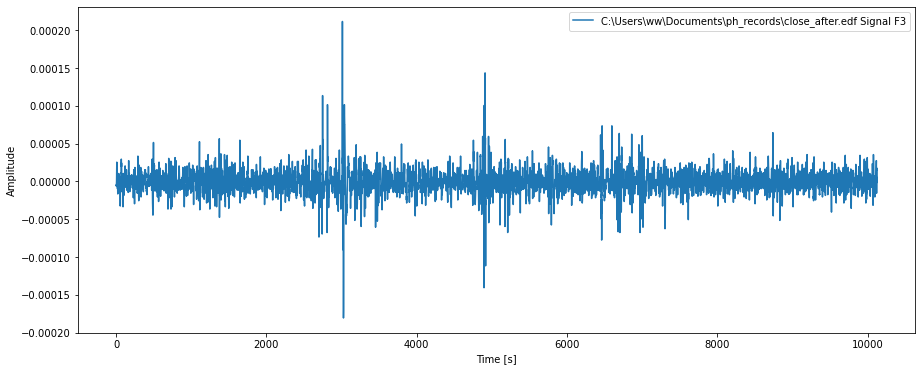

<Figure size 432x288 with 0 Axes>

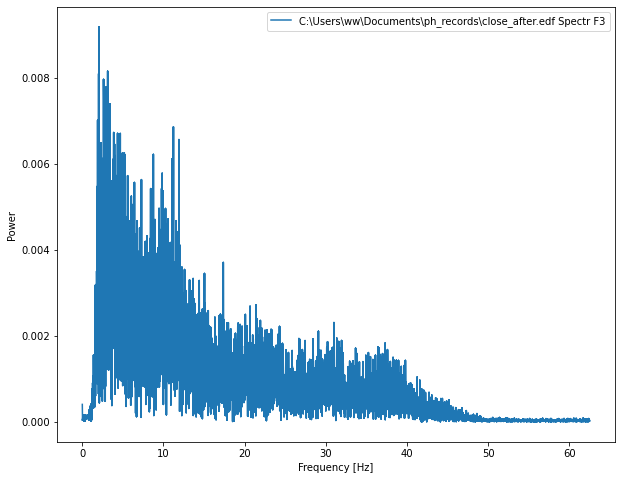

<Figure size 432x288 with 0 Axes>

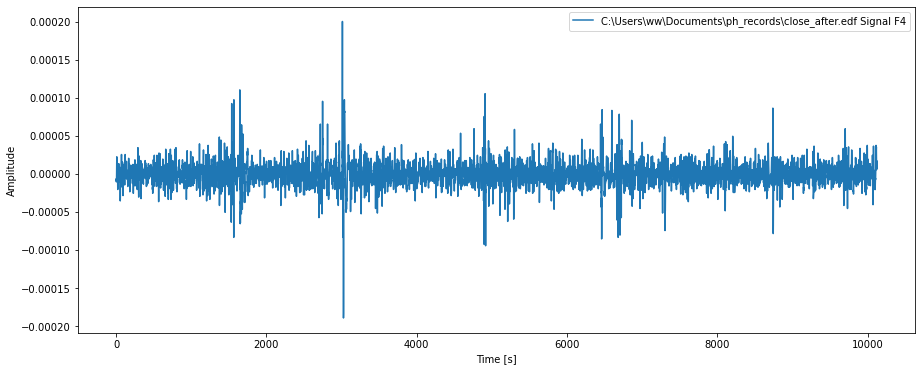

<Figure size 432x288 with 0 Axes>

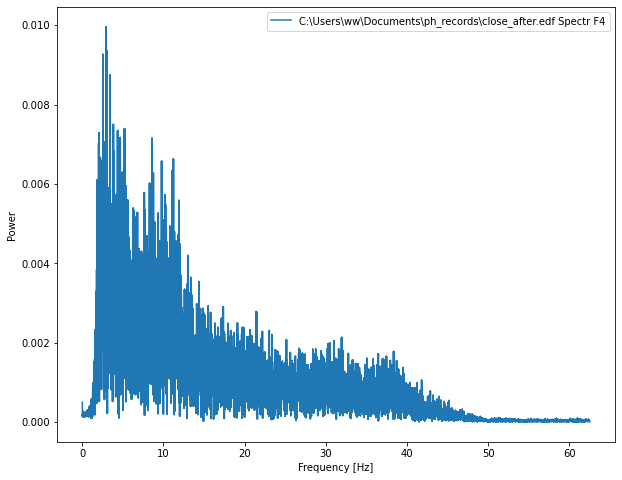

<Figure size 432x288 with 0 Axes>

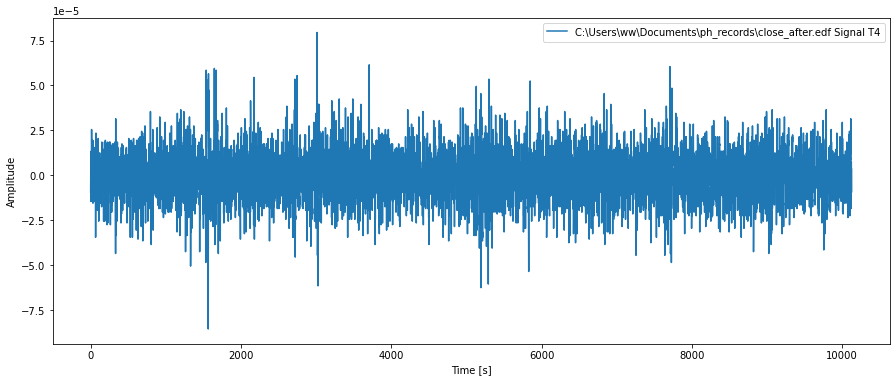

<Figure size 432x288 with 0 Axes>

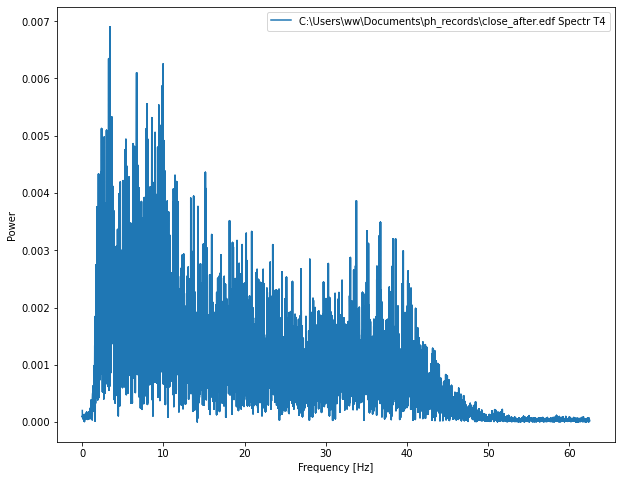

<Figure size 432x288 with 0 Axes>

In [40]:

length_main6 = length6
file_with_record_main6 = file_with_record6
sample_rate_main6 = sample_rate6
edffile_main6 = edffile_state6

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main6[chan],length_main6,1,edffile_main6+' Signal '+raw_mne6.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main6[chan],sample_rate_main6,edffile_main6+' Spectr '+raw_mne6.ch_names[chan])

# закрытые глаза до тр

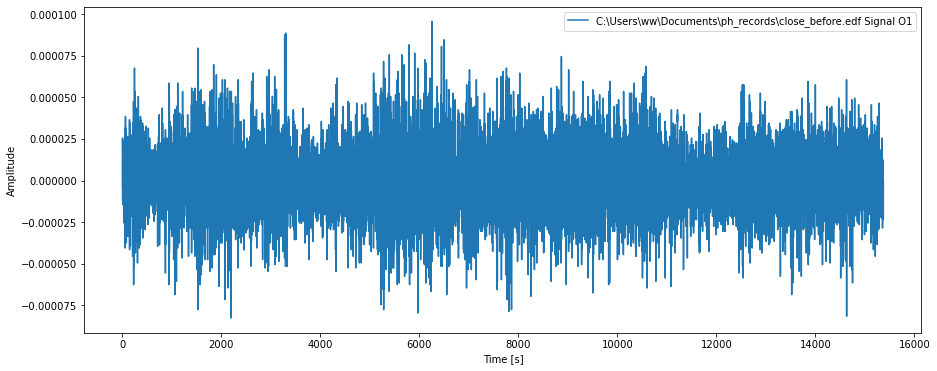

<Figure size 432x288 with 0 Axes>

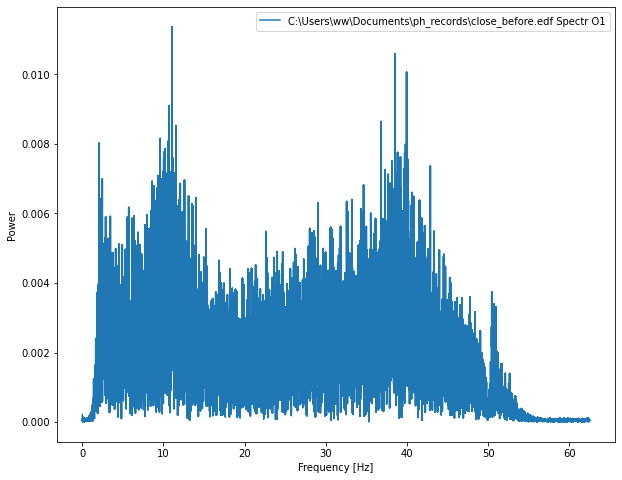

<Figure size 432x288 with 0 Axes>

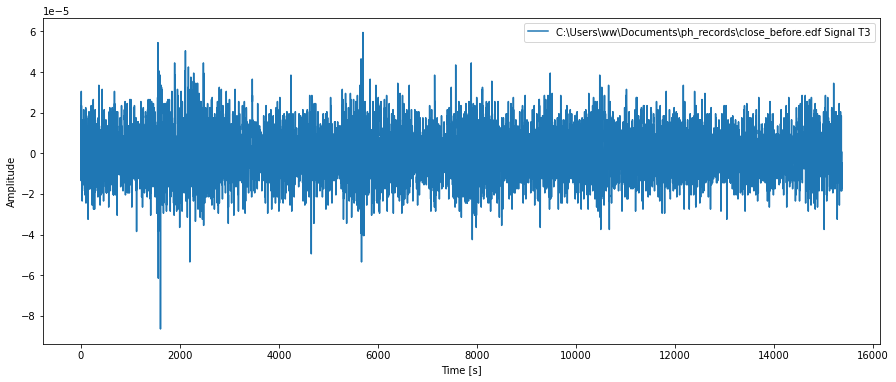

<Figure size 432x288 with 0 Axes>

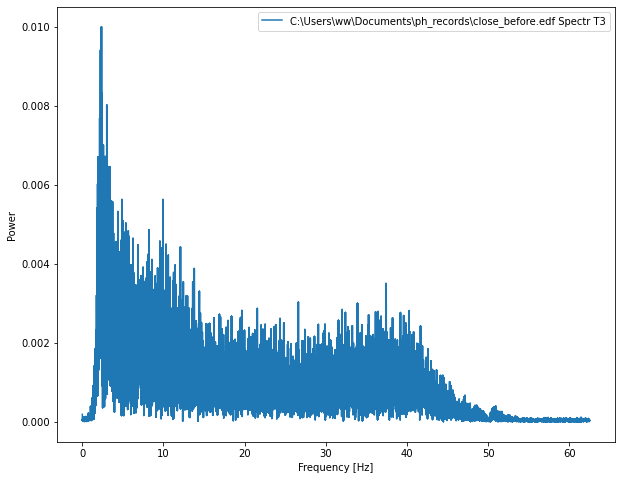

<Figure size 432x288 with 0 Axes>

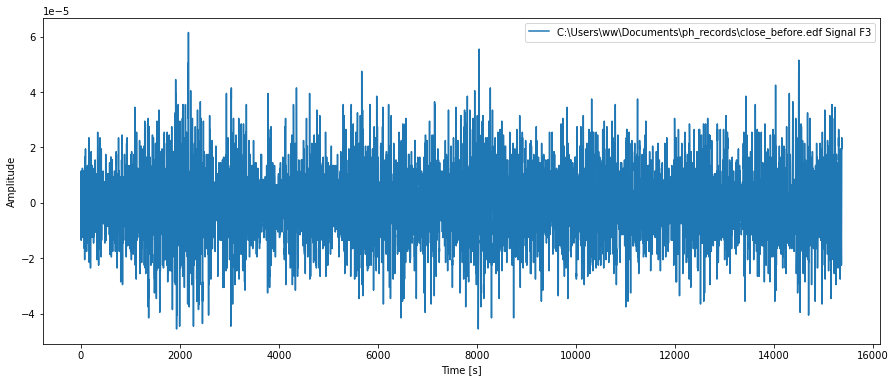

<Figure size 432x288 with 0 Axes>

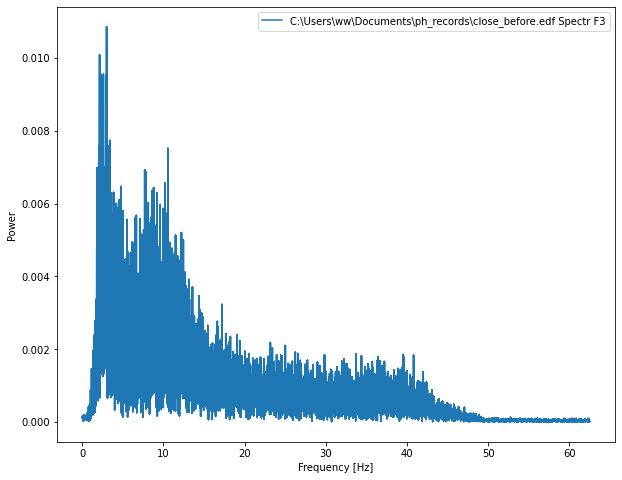

<Figure size 432x288 with 0 Axes>

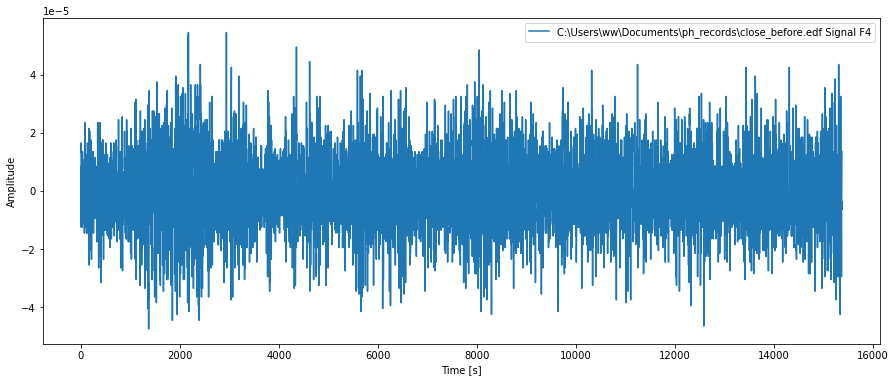

<Figure size 432x288 with 0 Axes>

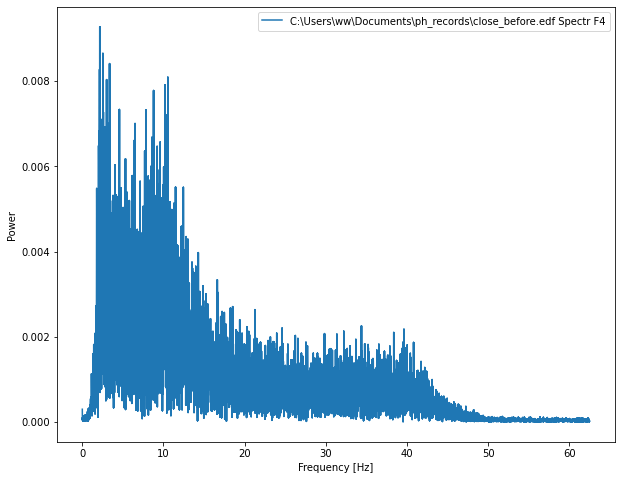

<Figure size 432x288 with 0 Axes>

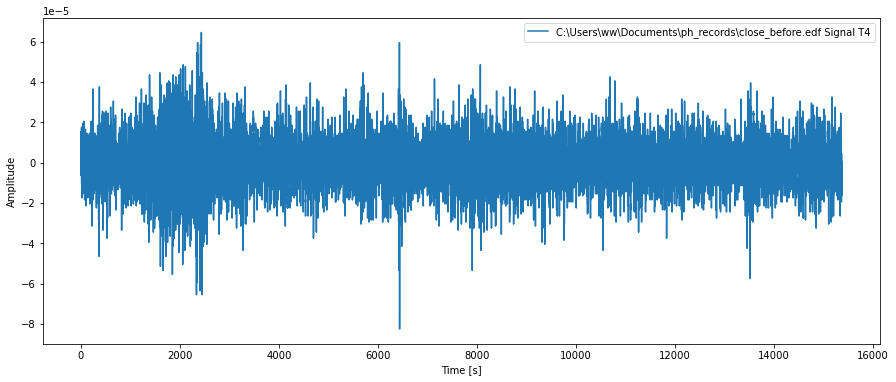

<Figure size 432x288 with 0 Axes>

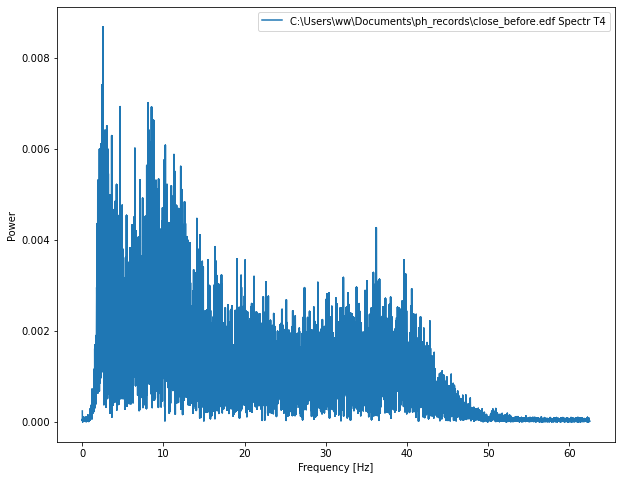

<Figure size 432x288 with 0 Axes>

In [41]:
length_main2 = length2
file_with_record_main2 = file_with_record2
sample_rate_main2 = sample_rate6
edffile_main2 = edffile_state2

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main2[chan],length_main2,1,edffile_main2+' Signal '+raw_mne2.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main2[chan],sample_rate_main2,edffile_main2+' Spectr '+raw_mne2.ch_names[chan])

# игра 2

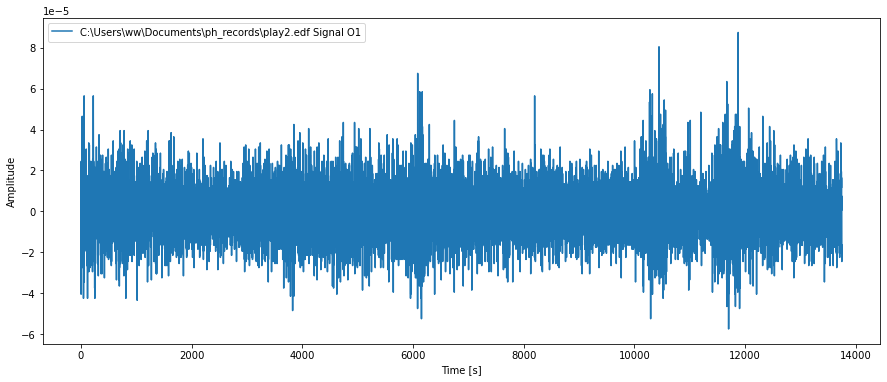

<Figure size 432x288 with 0 Axes>

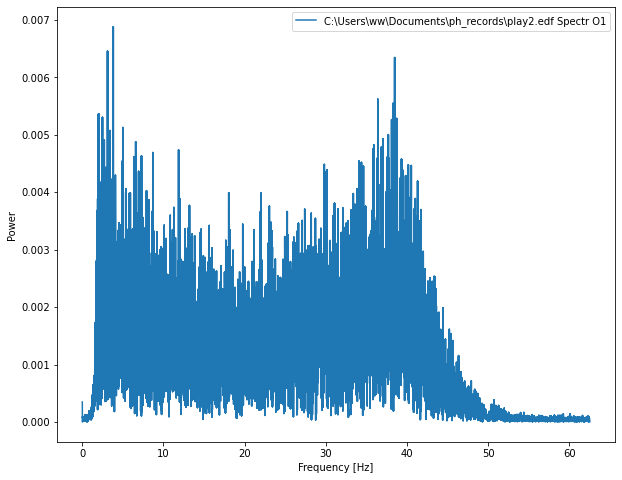

<Figure size 432x288 with 0 Axes>

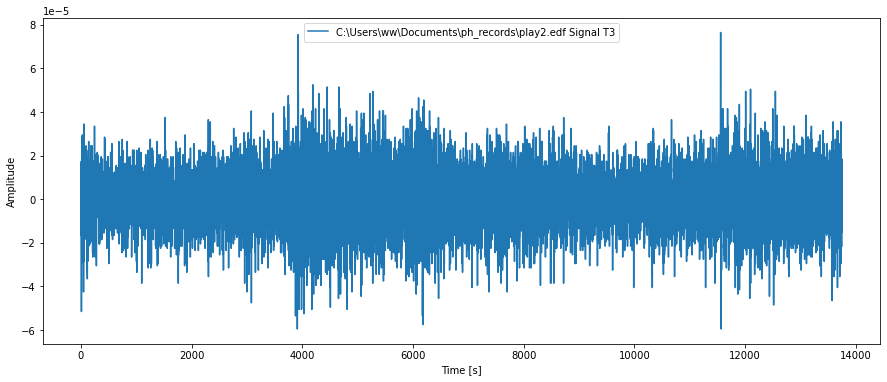

<Figure size 432x288 with 0 Axes>

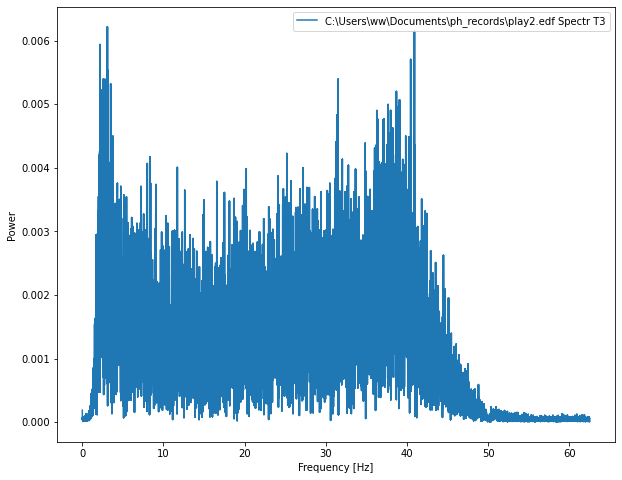

<Figure size 432x288 with 0 Axes>

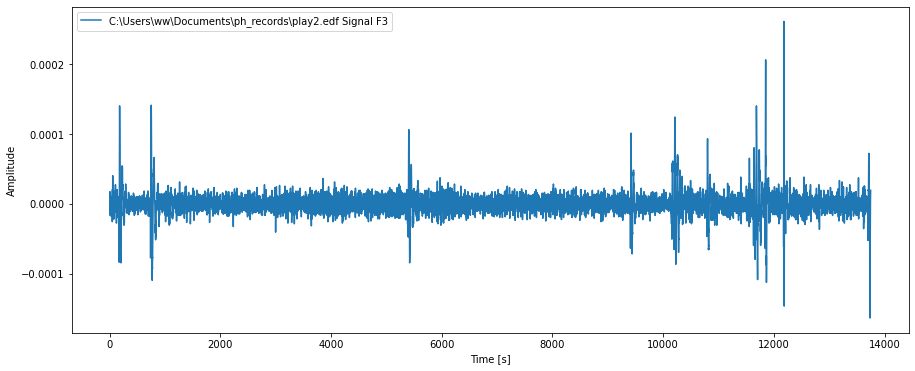

<Figure size 432x288 with 0 Axes>

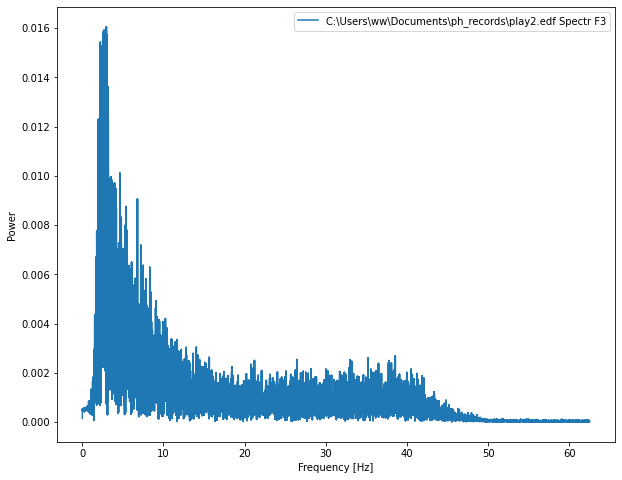

<Figure size 432x288 with 0 Axes>

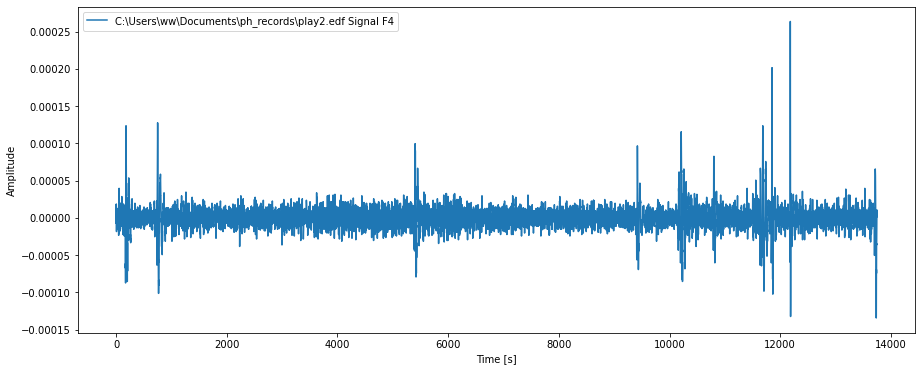

<Figure size 432x288 with 0 Axes>

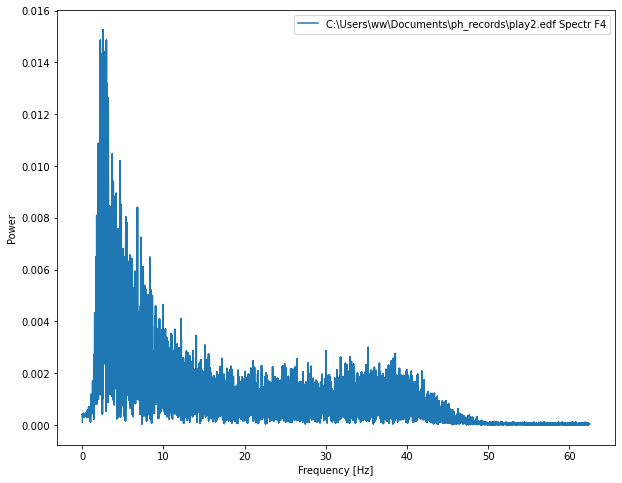

<Figure size 432x288 with 0 Axes>

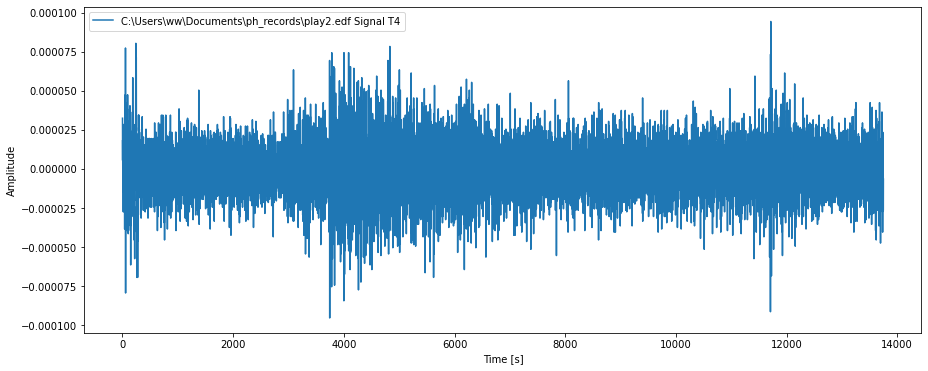

<Figure size 432x288 with 0 Axes>

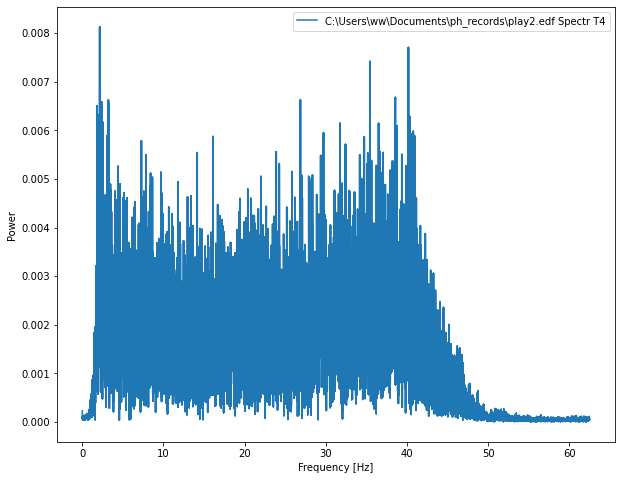

<Figure size 432x288 with 0 Axes>

In [42]:

length_main4 = length4
file_with_record_main4 = file_with_record4
sample_rate_main4 = sample_rate4
edffile_main4 = edffile_state4

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main4[chan],length_main4,1,edffile_main4+' Signal '+raw_mne4.ch_names[chan])
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main4[chan],sample_rate_main4,edffile_main4+' Spectr '+raw_mne4.ch_names[chan])

# смотрим максимальные и средние значения амплитуд по всем каналам

In [48]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main[chan])))))
    print('Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main[chan]))))
    print('Mx-Mn'+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main[chan])-np.mean(abs(file_with_record_main[chan])))))

Mean O1: 0.000016437
Max  O1: 0.000112498
Mx-MnO1: 0.000096062
Mean T3: 0.000014914
Max  T3: 0.000148498
Mx-MnT3: 0.000133583
Mean F3: 0.000016499
Max  F3: 0.000165497
Mx-MnF3: 0.000148999
Mean F4: 0.000016410
Max  F4: 0.000169497
Mx-MnF4: 0.000153087
Mean T4: 0.000019654
Max  T4: 0.000125498
Mx-MnT4: 0.000105844
Mean O2: 0.000011032
Max  O2: 0.000086499
Mx-MnO2: 0.000075467


In [49]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne2.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main2[chan])))))
    print('Max  '+raw_mne2.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main2[chan]))))
    print('Mx-Mn'+raw_mne2.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main2[chan])-np.mean(abs(file_with_record_main2[chan])))))

Mean O1: 0.000014373
Max  O1: 0.000095499
Mx-MnO1: 0.000081125
Mean T3: 0.000008350
Max  T3: 0.000059499
Mx-MnT3: 0.000051149
Mean F3: 0.000009099
Max  F3: 0.000061499
Mx-MnF3: 0.000052401
Mean F4: 0.000009077
Max  F4: 0.000054499
Mx-MnF4: 0.000045422
Mean T4: 0.000009037
Max  T4: 0.000064499
Mx-MnT4: 0.000055462
Mean O2: 0.000012252
Max  O2: 0.000091499
Mx-MnO2: 0.000079247


In [50]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne3.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main3[chan])))))
    print('Max  '+raw_mne3.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main3[chan]))))
    print('Mx-Mn'+raw_mne3.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main3[chan])-np.mean(abs(file_with_record_main3[chan])))))

Mean O1: 0.000008776
Max  O1: 0.000067499
Mx-MnO1: 0.000058723
Mean T3: 0.000008191
Max  T3: 0.000056499
Mx-MnT3: 0.000048308
Mean F3: 0.000011220
Max  F3: 0.000260496
Mx-MnF3: 0.000249276
Mean F4: 0.000011513
Max  F4: 0.000273496
Mx-MnF4: 0.000261983
Mean T4: 0.000010046
Max  T4: 0.000059499
Mx-MnT4: 0.000049453
Mean O2: 0.000007990
Max  O2: 0.000059499
Mx-MnO2: 0.000051509


In [52]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne4.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main4[chan])))))
    print('Max  '+raw_mne4.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main4[chan]))))
    print('Mx-Mn'+raw_mne4.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main4[chan])-np.mean(abs(file_with_record_main4[chan])))))

Mean O1: 0.000009785
Max  O1: 0.000087499
Mx-MnO1: 0.000077714
Mean T3: 0.000010034
Max  T3: 0.000076499
Mx-MnT3: 0.000066465
Mean F3: 0.000009438
Max  F3: 0.000261496
Mx-MnF3: 0.000252058
Mean F4: 0.000009592
Max  F4: 0.000263496
Mx-MnF4: 0.000253904
Mean T4: 0.000012543
Max  T4: 0.000094499
Mx-MnT4: 0.000081956
Mean O2: 0.000010103
Max  O2: 0.000085499
Mx-MnO2: 0.000075396


In [51]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne5.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main5[chan])))))
    print('Max  '+raw_mne5.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main5[chan]))))
    print('Mx-Mn'+raw_mne5.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main5[chan])-np.mean(abs(file_with_record_main5[chan])))))

Mean O1: 0.000250617
Max  O1: 0.032767000
Mx-MnO1: 0.032516383
Mean T3: 0.000020795
Max  T3: 0.008007378
Mx-MnT3: 0.007986583
Mean F3: 0.000241194
Max  F3: 0.032767000
Mx-MnF3: 0.032525806
Mean F4: 0.000042691
Max  F4: 0.018825213
Mx-MnF4: 0.018782522
Mean T4: 0.000029821
Max  T4: 0.011236329
Mx-MnT4: 0.011206508
Mean O2: 0.000009597
Max  O2: 0.000666490
Mx-MnO2: 0.000656893


In [53]:
# смотрим максимальные и средние значения амплитуд по всем каналам
for chan in range(0,nchan):
    print('Mean '+raw_mne6.ch_names[chan]+': '+str("{:.9f}".format(np.mean(abs(file_with_record_main6[chan])))))
    print('Max  '+raw_mne6.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main6[chan]))))
    print('Mx-Mn'+raw_mne6.ch_names[chan]+': '+str("{:.9f}".format(np.max(file_with_record_main6[chan])-np.mean(abs(file_with_record_main6[chan])))))

Mean O1: 0.000008795
Max  O1: 0.000054499
Mx-MnO1: 0.000045704
Mean T3: 0.000006840
Max  T3: 0.000045499
Mx-MnT3: 0.000038659
Mean F3: 0.000008620
Max  F3: 0.000056499
Mx-MnF3: 0.000047879
Mean F4: 0.000008830
Max  F4: 0.000053499
Mx-MnF4: 0.000044669
Mean T4: 0.000009338
Max  T4: 0.000054499
Mx-MnT4: 0.000045161
Mean O2: 0.000012077
Max  O2: 0.000056499
Mx-MnO2: 0.000044422


# начинаем фильтровать 

In [60]:
# Требуется для вырезания кусочков записи определенной длины и аплитуды
# вырезаем, отрезаем очень резкие пики
# для обеих записей значения threshhold могут отличаться

# порог отсечки амплитуды, чтобы поставить корректно, смотри графики и код выше
# для 1 файла 0.0002, для второго 0.00015
threshhold1 = 0.0002
# количество секунд, которые вырезаются, если в куске есть превышение, рекомендуем 1
part_length_sec = 1

# сравниваем что было и что будет после очистки, если ок, дальше создаем новый файл
print('open_before') 
print('Было '+str(nchan)+' '+str(length_main))
print('Стало '+str(clearing_signal(file_with_record_main,part_length_sec,sample_rate_main,threshhold1,nchan).shape))


threshhold2 = 0.00014
part_length_sec = 1
print('close_before')      
print('Было '+str(nchan)+' '+str(length_main2))
print('Стало '+str(clearing_signal(file_with_record_main2,part_length_sec,sample_rate_main2,threshhold2,nchan).shape))

threshhold3 = 0.000058
part_length_sec = 1
print('play1')  
print('Было '+str(nchan)+' '+str(length_main3))
print('Стало '+str(clearing_signal(file_with_record_main3,part_length_sec,sample_rate_main3,threshhold3,nchan).shape))

threshhold4 = 0.000077
part_length_sec = 1
print('play2')  
print('Было '+str(nchan)+' '+str(length_main4))
print('Стало '+str(clearing_signal(file_with_record_main4,part_length_sec,sample_rate_main4,threshhold4,nchan).shape))

threshhold5 = 0.032
part_length_sec = 1
print('open_after')  
print('Было '+str(nchan)+' '+str(length_main5))
print('Стало '+str(clearing_signal(file_with_record_main5,part_length_sec,sample_rate_main5,threshhold5,nchan).shape))

threshhold6 = 0.000045
part_length_sec = 1
print('close_after')  
print('Было '+str(nchan)+' '+str(length_main6))
print('Стало '+str(clearing_signal(file_with_record_main6,part_length_sec,sample_rate_main6,threshhold6,nchan).shape))



open_before
Было 6 11625
Стало (6, 11500)
close_before
Было 6 15375
Стало (6, 15375)
play1
Было 6 13500
Стало (6, 10500)
play2
Было 6 13750
Стало (6, 11375)
open_after
Было 6 7500


C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_cleared_signal = np.empty((_nchan,_num_parts),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:13: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cleared_signal = np.empty((_nchan,_num_parts-len(temp_bad_parts)),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:17: DeprecationWarning: `np.object` is a depreca

Стало (6, 7375)
close_after
Было 6 6875
Стало (6, 3125)


In [66]:
# Создаем новый файл для работы после очистки
new_file_with_record1 = np.zeros((nchan,len(clearing_signal(file_with_record1,part_length_sec,sample_rate1,threshhold1,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record1[chan] = clearing_signal(file_with_record1,part_length_sec,sample_rate1,threshhold1,nchan)[chan]

# новая длина
length1 = len(new_file_with_record1[0])
print(length1)

# Создаем новый файл для работы после очистки
new_file_with_record2 = np.zeros((nchan,len(clearing_signal(file_with_record2,part_length_sec,sample_rate2,threshhold2,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record2[chan] = clearing_signal(file_with_record2,part_length_sec,sample_rate2,threshhold2,nchan)[chan]

# новая длина
length2 = len(new_file_with_record2[0])
print(length2)

# Создаем новый файл для работы после очистки
new_file_with_record3 = np.zeros((nchan,len(clearing_signal(file_with_record3,part_length_sec,sample_rate3,threshhold3,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record3[chan] = clearing_signal(file_with_record3,part_length_sec,sample_rate3,threshhold3,nchan)[chan]

# новая длина
length3 = len(new_file_with_record3[0])
print(length3)

# Создаем новый файл для работы после очистки
new_file_with_record4 = np.zeros((nchan,len(clearing_signal(file_with_record4,part_length_sec,sample_rate4,threshhold4,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record4[chan] = clearing_signal(file_with_record4,part_length_sec,sample_rate4,threshhold4,nchan)[chan]

# новая длина
length4 = len(new_file_with_record4[0])
print(length4)

# Создаем новый файл для работы после очистки
new_file_with_record5 = np.zeros((nchan,len(clearing_signal(file_with_record5,part_length_sec,sample_rate5,threshhold5,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record5[chan] = clearing_signal(file_with_record5,part_length_sec,sample_rate5,threshhold5,nchan)[chan]

# новая длина
length5 = len(new_file_with_record5[0])
print(length5)

# Создаем новый файл для работы после очистки
new_file_with_record6 = np.zeros((nchan,len(clearing_signal(file_with_record6,part_length_sec,sample_rate6,threshhold6,nchan)[0])))
for chan in range(0,nchan):
    new_file_with_record6[chan] = clearing_signal(file_with_record6,part_length_sec,sample_rate6,threshhold6,nchan)[chan]

# новая длина
length6 = len(new_file_with_record6[0])
print(length6)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp_cleared_signal = np.empty((_nchan,_num_parts),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:13: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cleared_signal = np.empty((_nchan,_num_parts-len(temp_bad_parts)),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\105857325.py:17: DeprecationWarning: `np.object` is a depreca

11500
15375
10500
11375
7375
3125


# отфильтрованные  спектры 

# игра 1

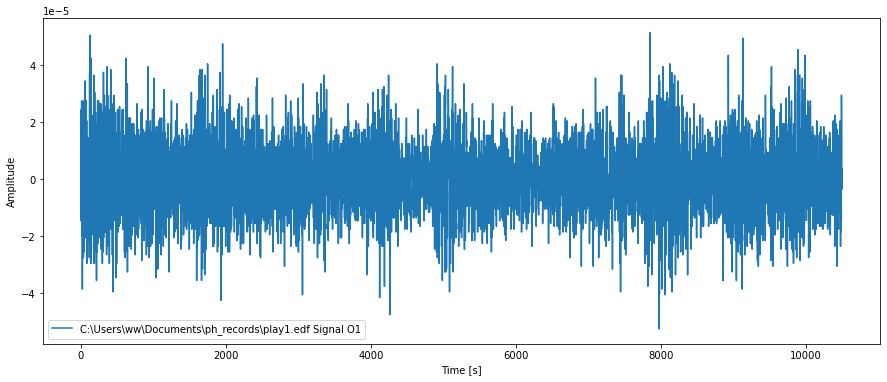

<Figure size 432x288 with 0 Axes>

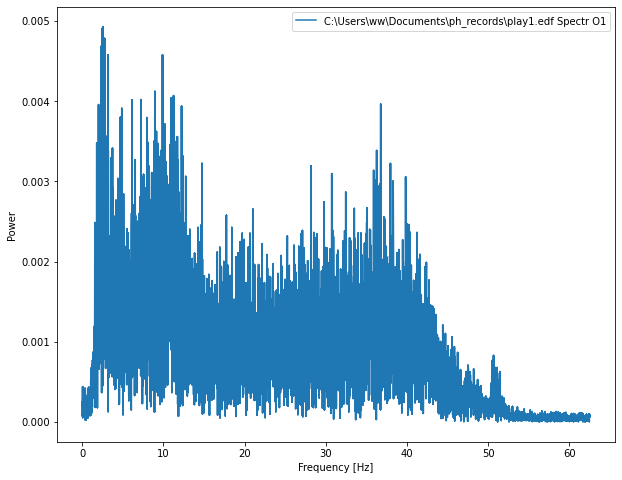

<Figure size 432x288 with 0 Axes>

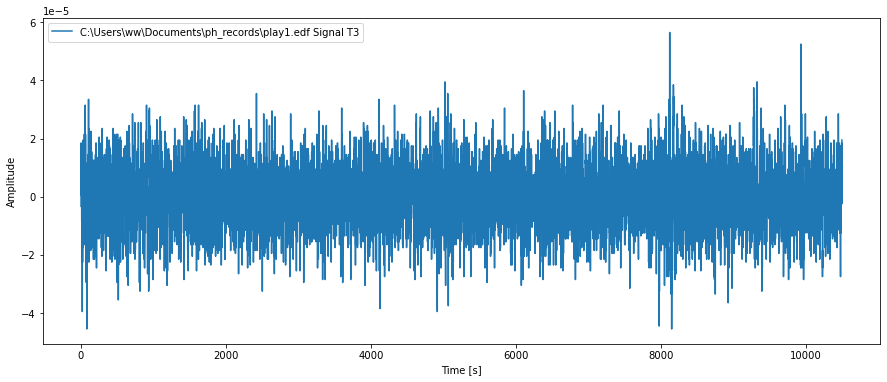

<Figure size 432x288 with 0 Axes>

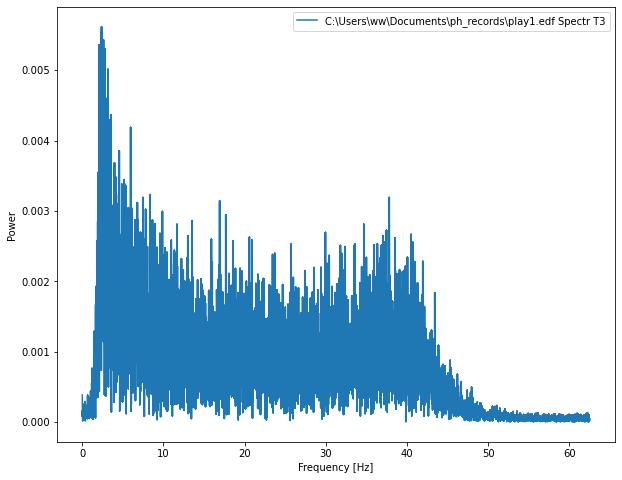

<Figure size 432x288 with 0 Axes>

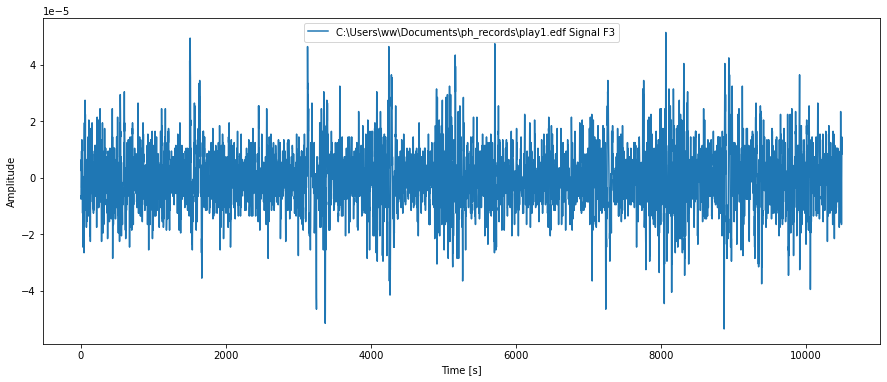

<Figure size 432x288 with 0 Axes>

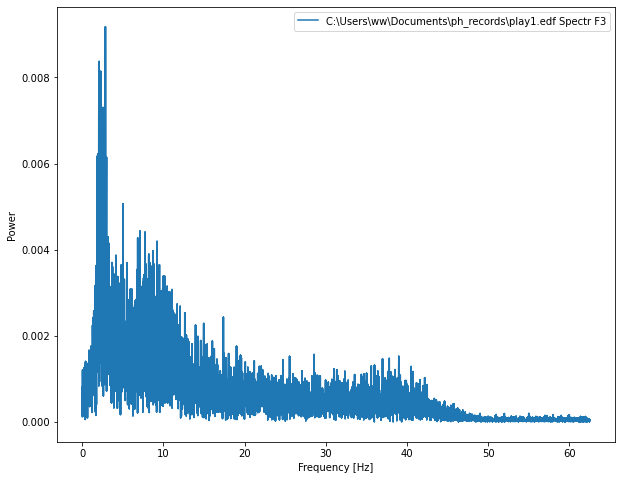

<Figure size 432x288 with 0 Axes>

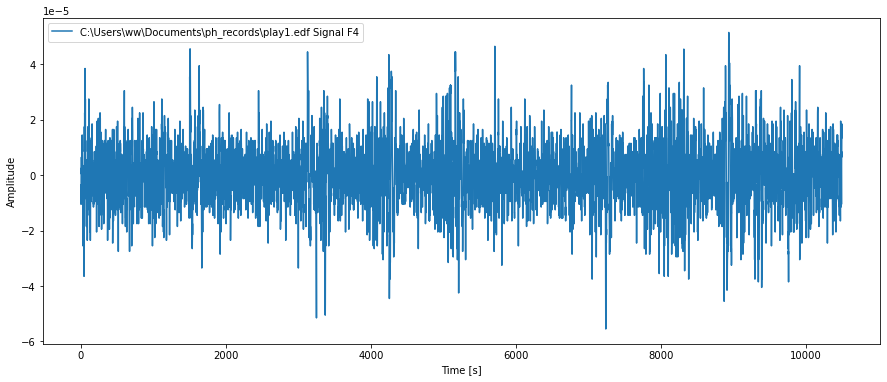

<Figure size 432x288 with 0 Axes>

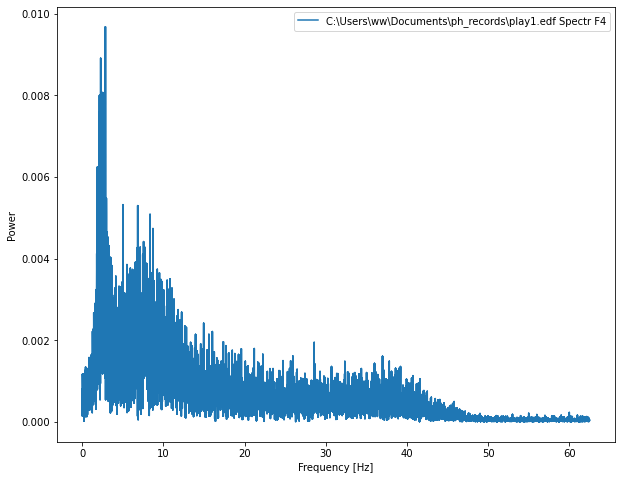

<Figure size 432x288 with 0 Axes>

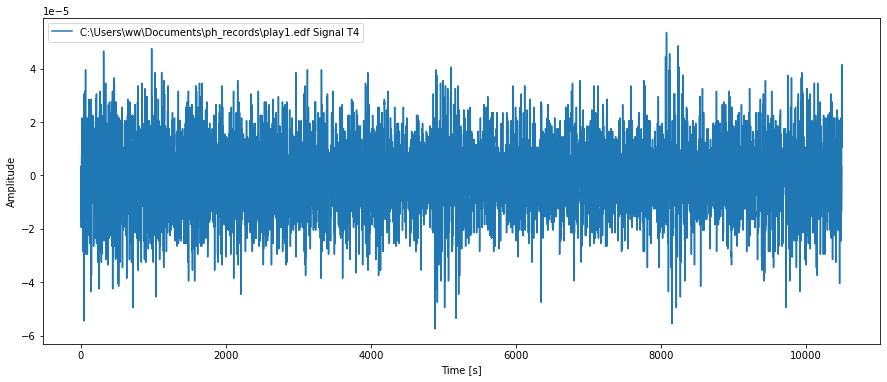

<Figure size 432x288 with 0 Axes>

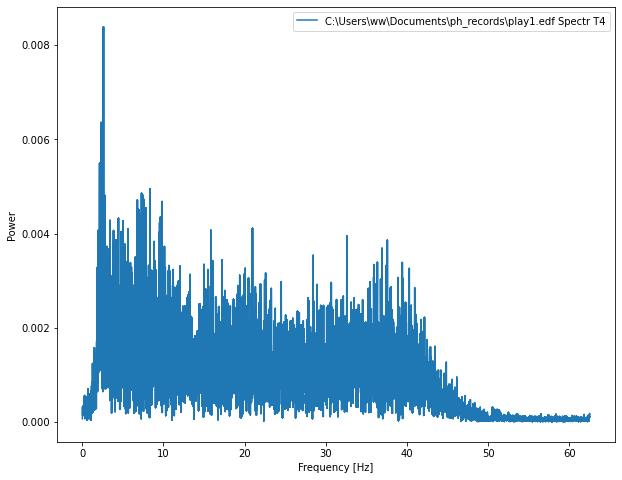

<Figure size 432x288 with 0 Axes>

In [68]:
length_main3 = length3
file_with_record_main3 = new_file_with_record3
sample_rate_main3 = sample_rate3
edffile_main3 = edffile_state3

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main3[chan],length_main3,1,edffile_main3+' Signal '+raw_mne3.ch_names[chan])
    draw_spectr(file_with_record_main3[chan],sample_rate_main3,edffile_main3+' Spectr '+raw_mne3.ch_names[chan])
    


# игра 2

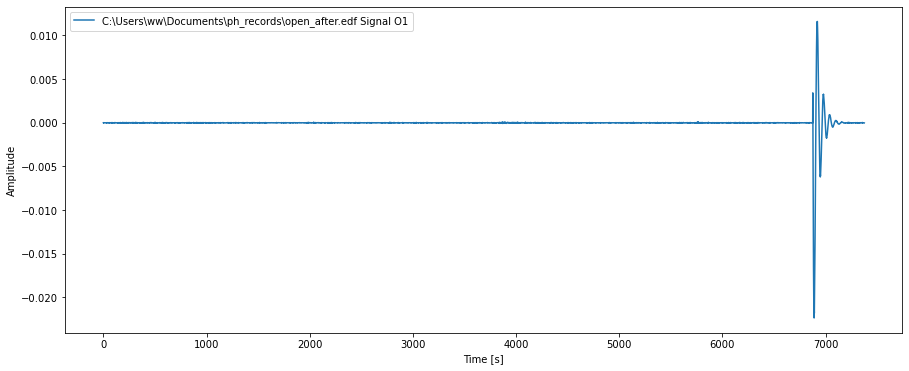

<Figure size 432x288 with 0 Axes>

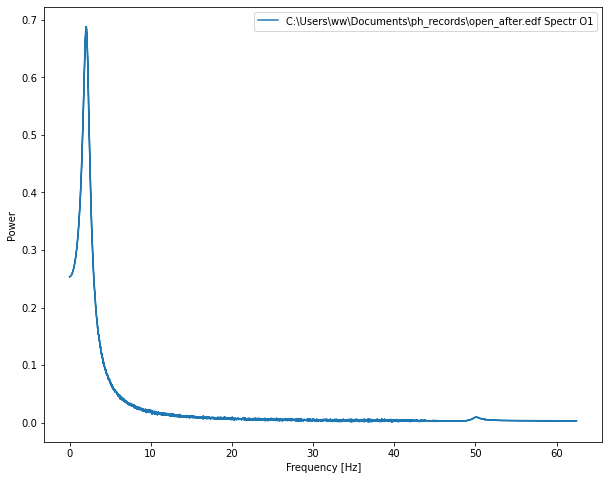

<Figure size 432x288 with 0 Axes>

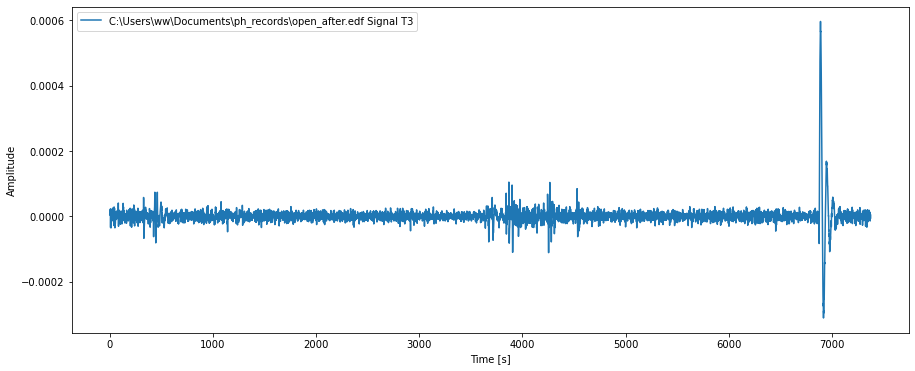

<Figure size 432x288 with 0 Axes>

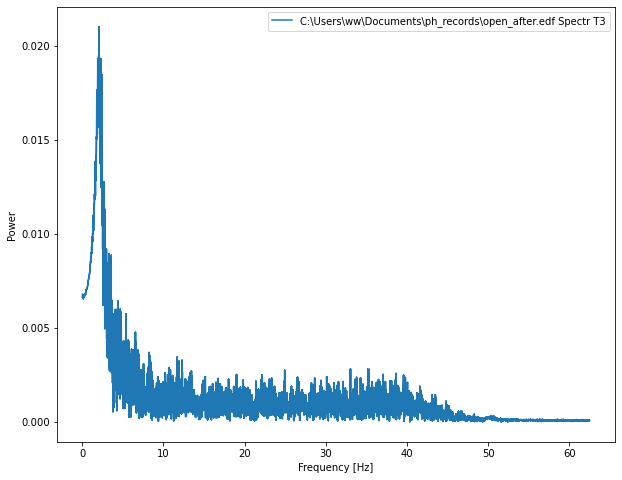

<Figure size 432x288 with 0 Axes>

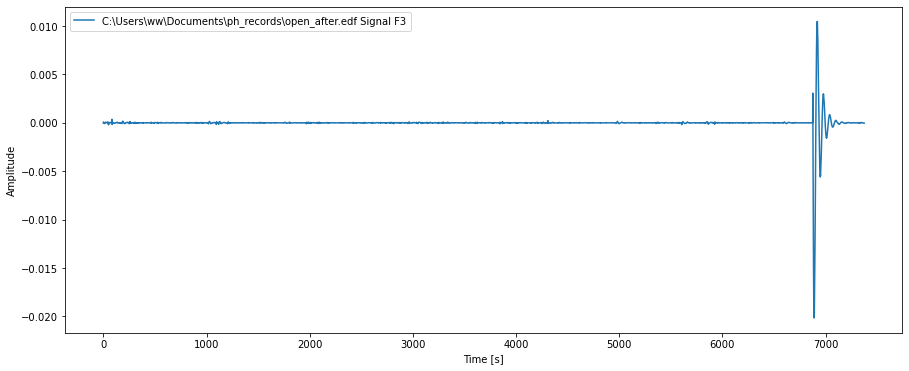

<Figure size 432x288 with 0 Axes>

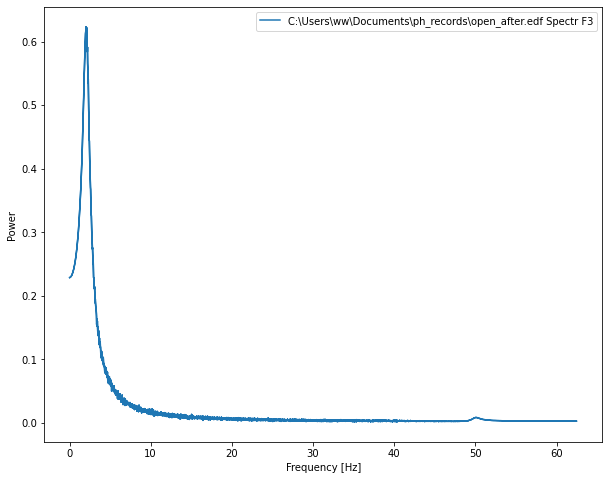

<Figure size 432x288 with 0 Axes>

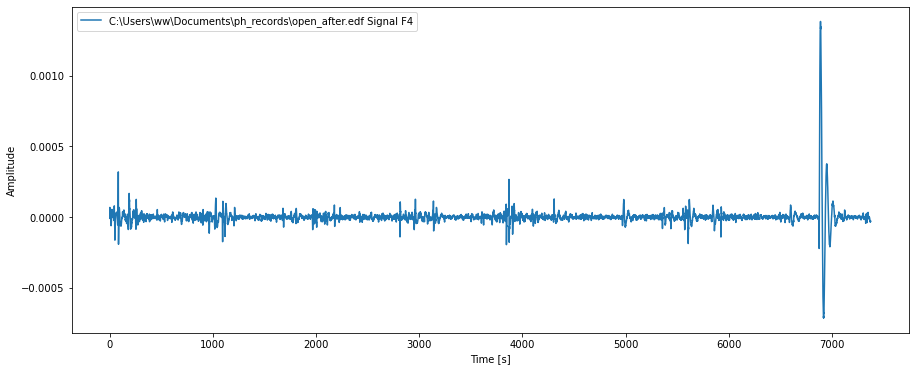

<Figure size 432x288 with 0 Axes>

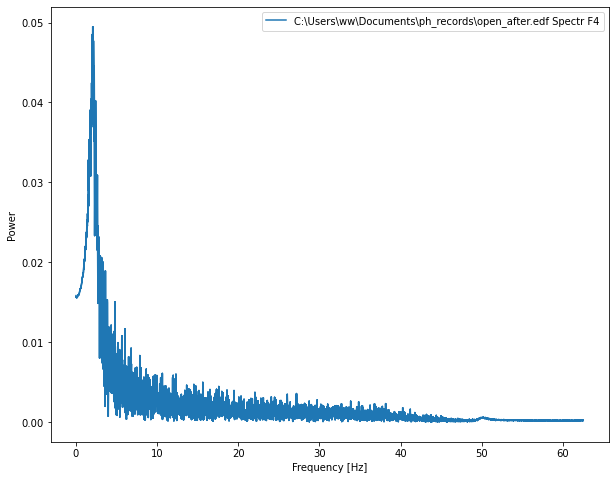

<Figure size 432x288 with 0 Axes>

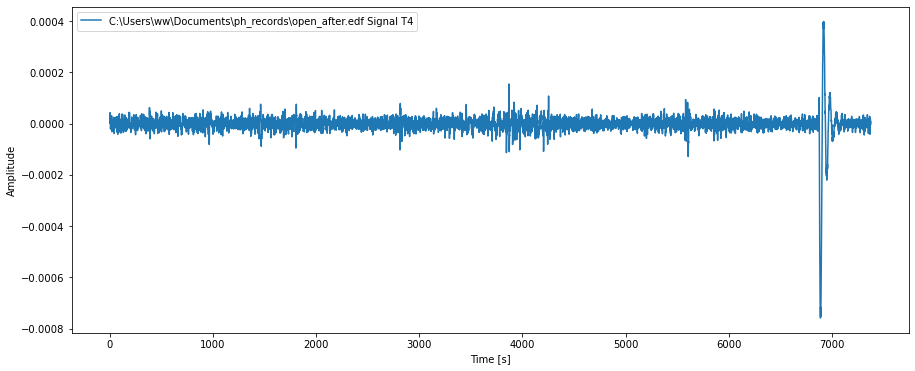

<Figure size 432x288 with 0 Axes>

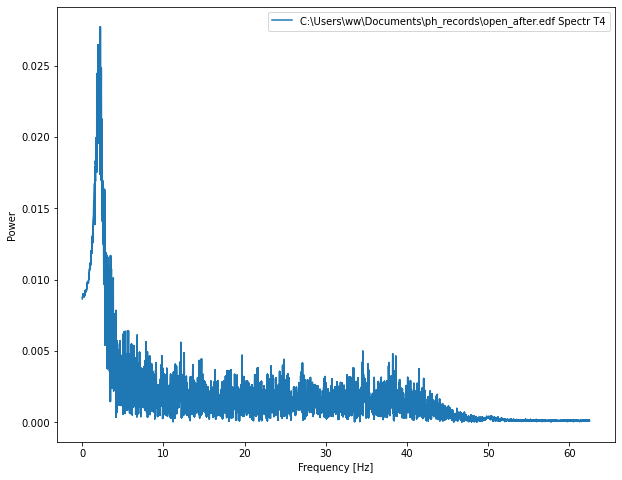

<Figure size 432x288 with 0 Axes>

In [69]:
length_main5 = length5
file_with_record_main5 = new_file_with_record5
sample_rate_main5= sample_rate5
edffile_main5= edffile_state5

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main5[chan],length_main5,1,edffile_main5+' Signal '+raw_mne5.ch_names[chan])
    draw_spectr(file_with_record_main5[chan],sample_rate_main5,edffile_main5+' Spectr '+raw_mne5.ch_names[chan])
   

# Закрытые после тр

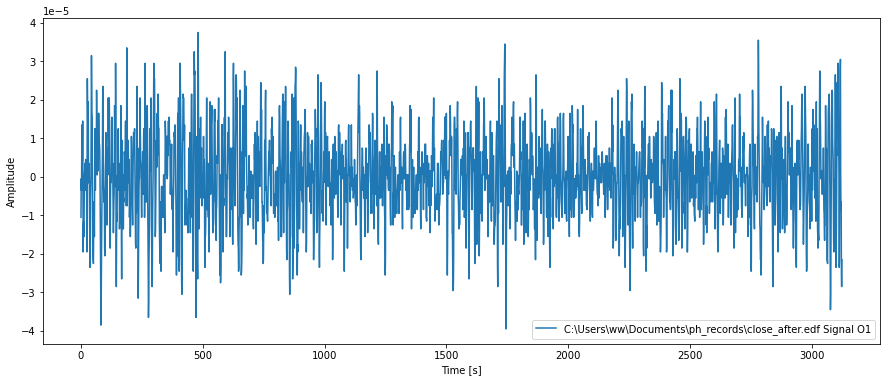

<Figure size 432x288 with 0 Axes>

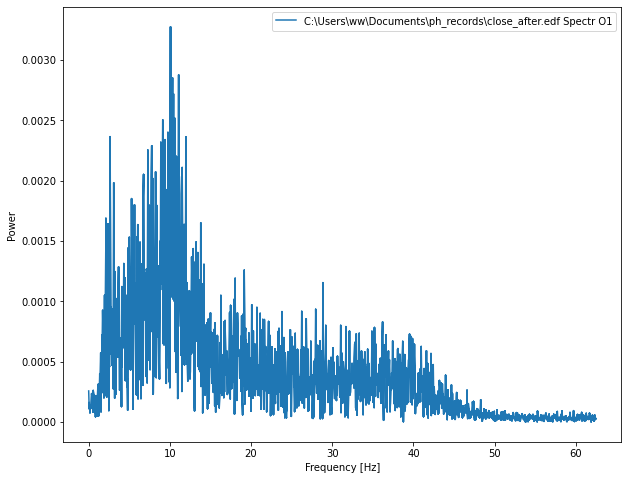

<Figure size 432x288 with 0 Axes>

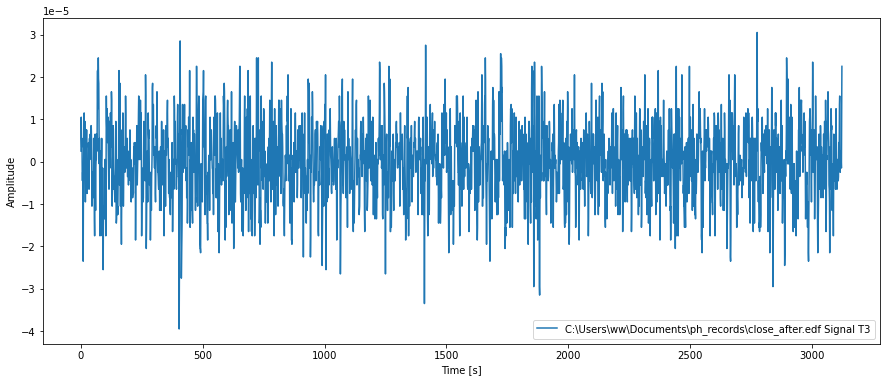

<Figure size 432x288 with 0 Axes>

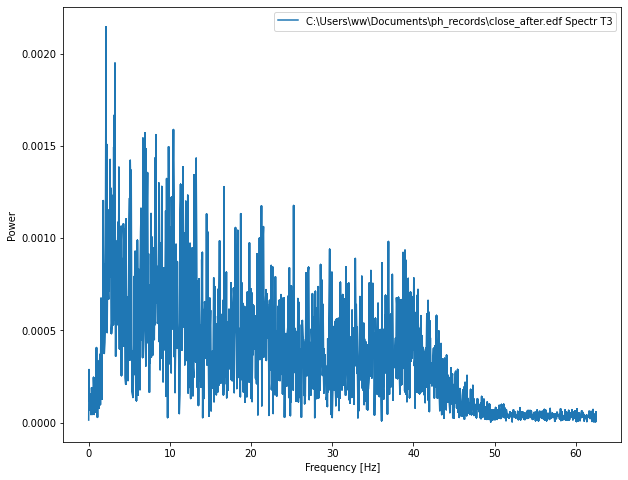

<Figure size 432x288 with 0 Axes>

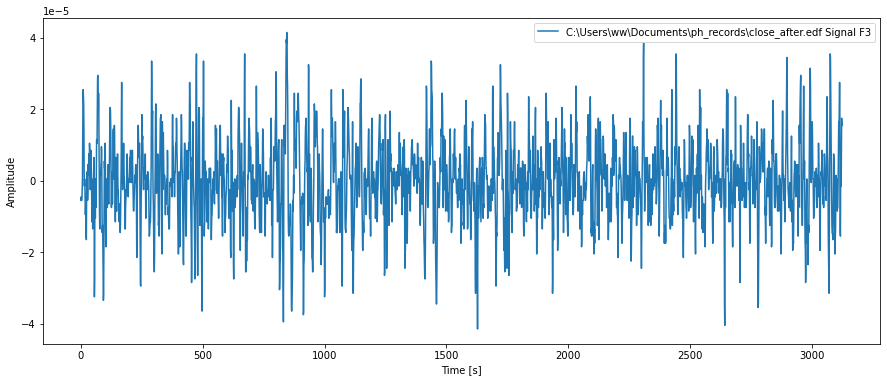

<Figure size 432x288 with 0 Axes>

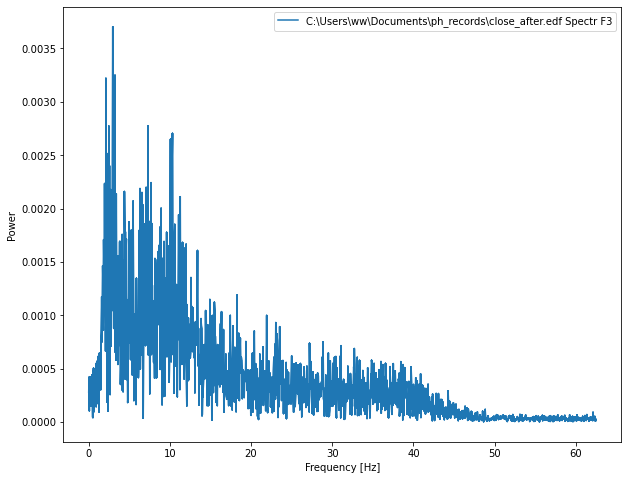

<Figure size 432x288 with 0 Axes>

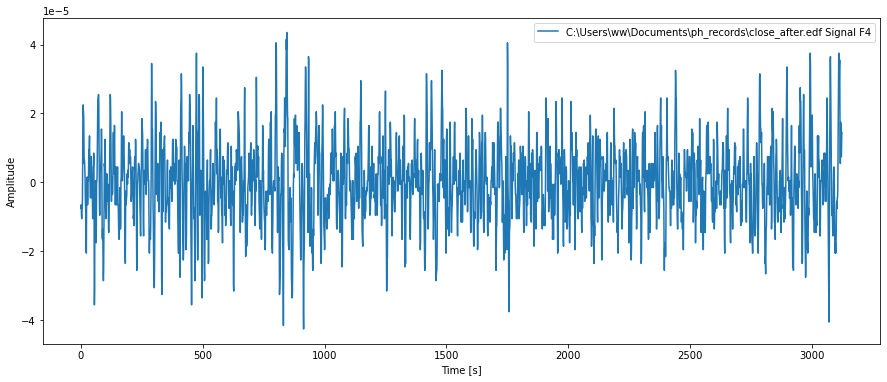

<Figure size 432x288 with 0 Axes>

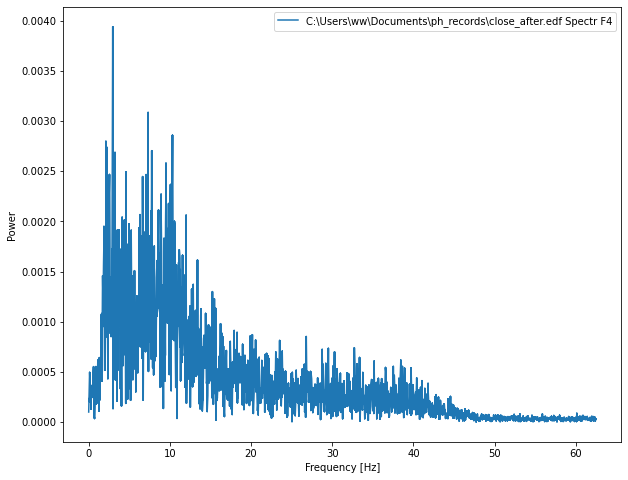

<Figure size 432x288 with 0 Axes>

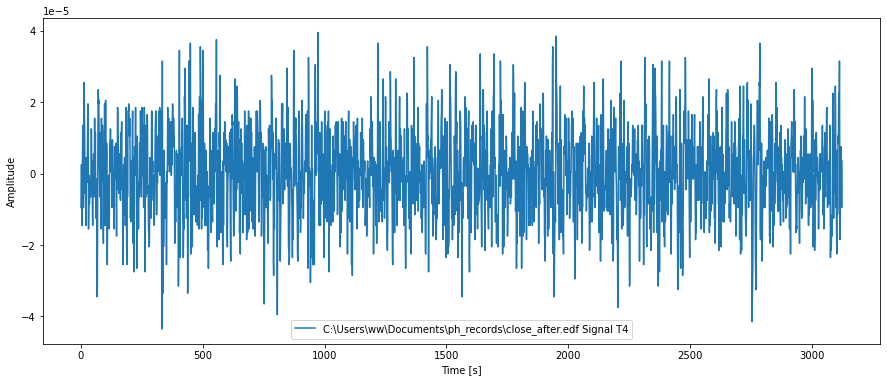

<Figure size 432x288 with 0 Axes>

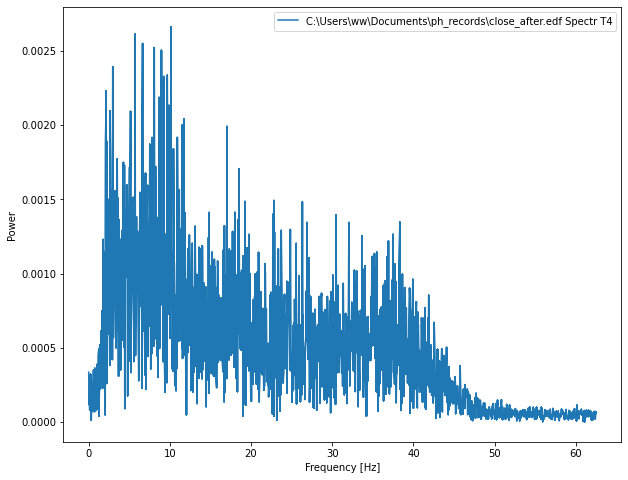

<Figure size 432x288 with 0 Axes>

In [71]:
length_main6 = length6
file_with_record_main6 = new_file_with_record6
sample_rate_main6 = sample_rate6
edffile_main6 = edffile_state6

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main6[chan],length_main6,1,edffile_main6+' Signal '+raw_mne6.ch_names[chan])
    #plt.savefig('C:\\Users\\Ksenia\\Desktop\\PCourse\\задание2\\картинки\\play1\\' + str(chan) + 'sig' + '.jpg')
    # Рисуем спектр любого массива сигнала
    draw_spectr(file_with_record_main6[chan],sample_rate_main6,edffile_main6+' Spectr '+raw_mne6.ch_names[chan])
    #plt.savefig('C:\\Users\\Ksenia\\Desktop\\PCourse\\задание2\\картинки\\play1\\' + str(chan) + 'sp' + '.jpg')


# открытые глаза до тр 

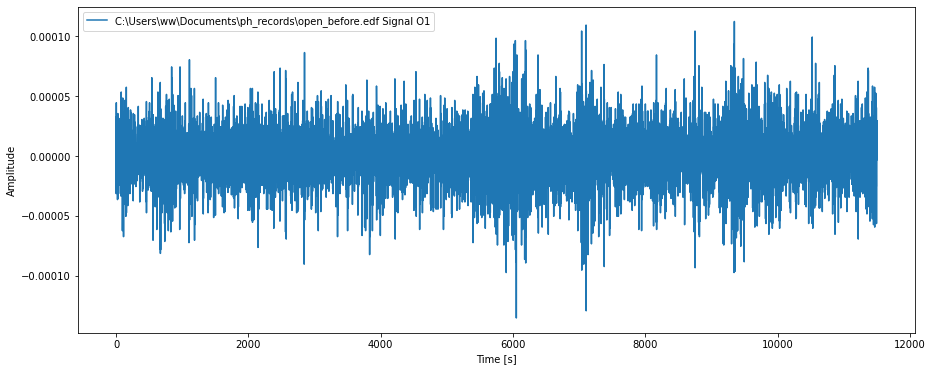

<Figure size 432x288 with 0 Axes>

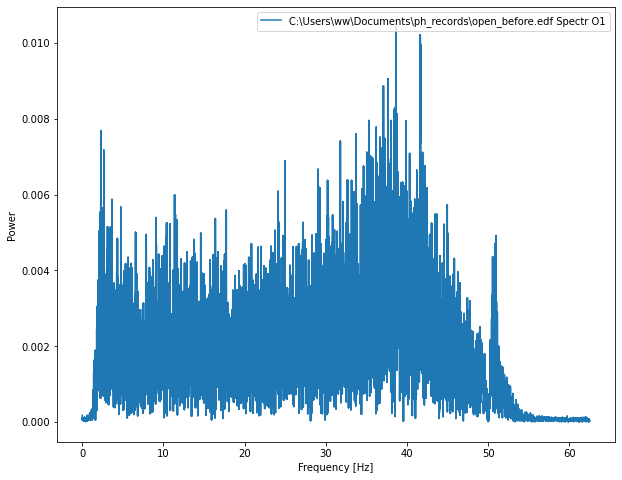

<Figure size 432x288 with 0 Axes>

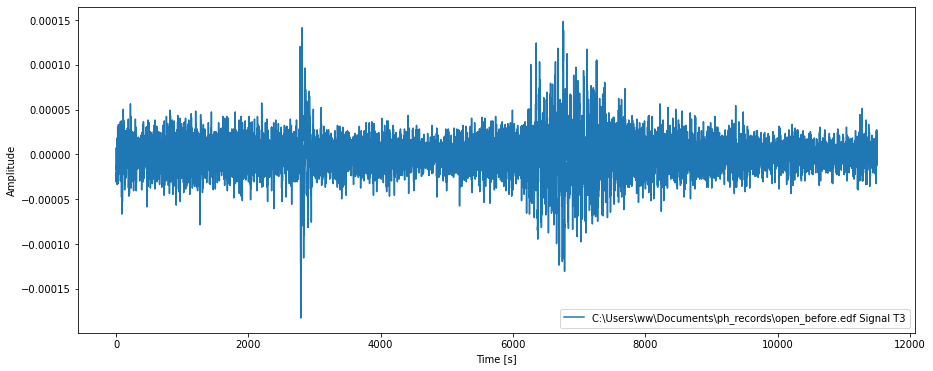

<Figure size 432x288 with 0 Axes>

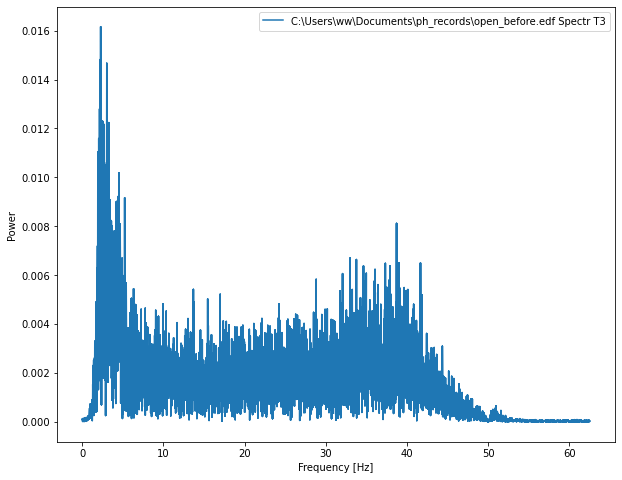

<Figure size 432x288 with 0 Axes>

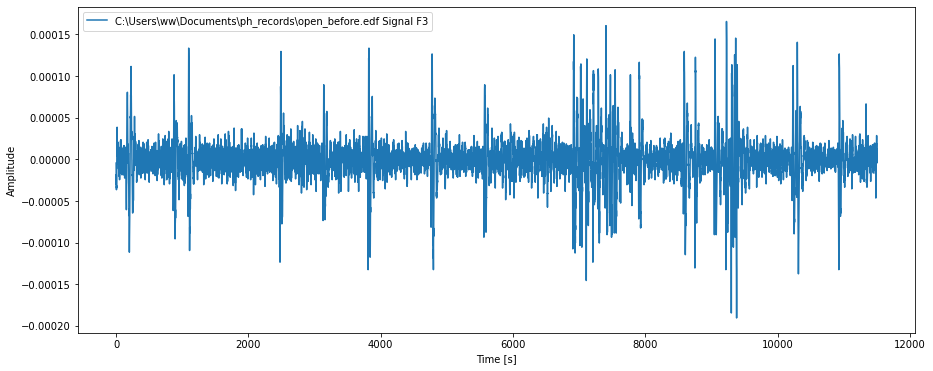

<Figure size 432x288 with 0 Axes>

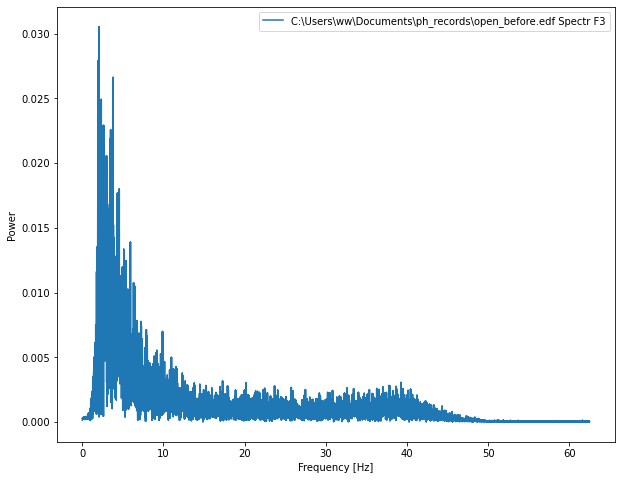

<Figure size 432x288 with 0 Axes>

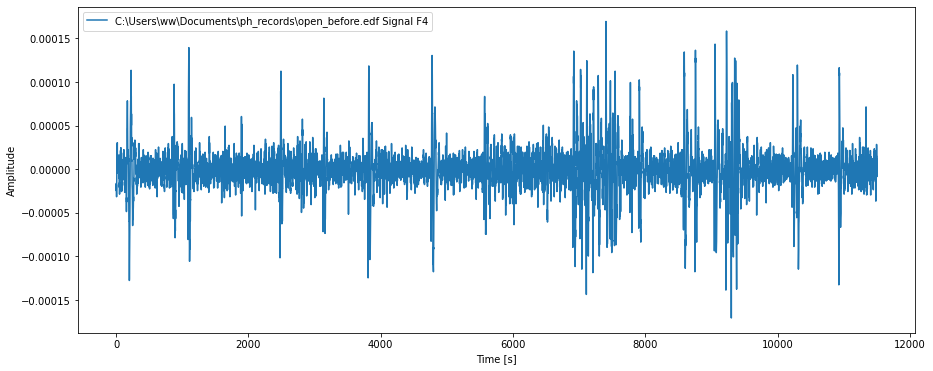

<Figure size 432x288 with 0 Axes>

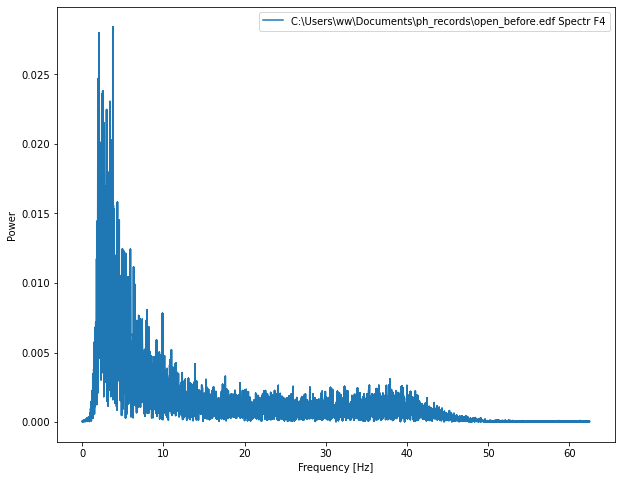

<Figure size 432x288 with 0 Axes>

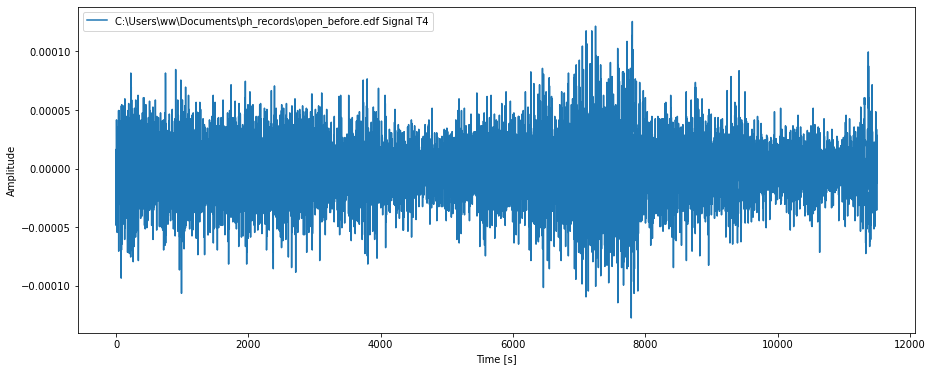

<Figure size 432x288 with 0 Axes>

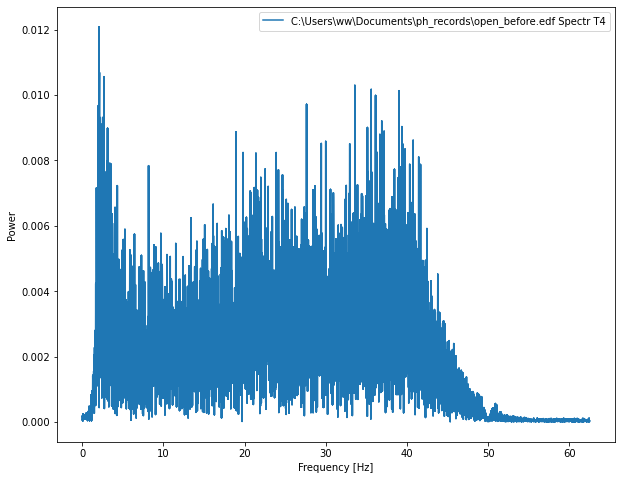

<Figure size 432x288 with 0 Axes>

In [70]:
length_main1 = length1
file_with_record_main1 = new_file_with_record1
sample_rate_main1 = sample_rate1
edffile_main1 = edffile_state1

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main1[chan],length_main1,1,edffile_main1+' Signal '+raw_mne1.ch_names[chan])
    
    draw_spectr(file_with_record_main1[chan],sample_rate_main1,edffile_main1+' Spectr '+raw_mne1.ch_names[chan])
    


# закрытые глаза до тр 

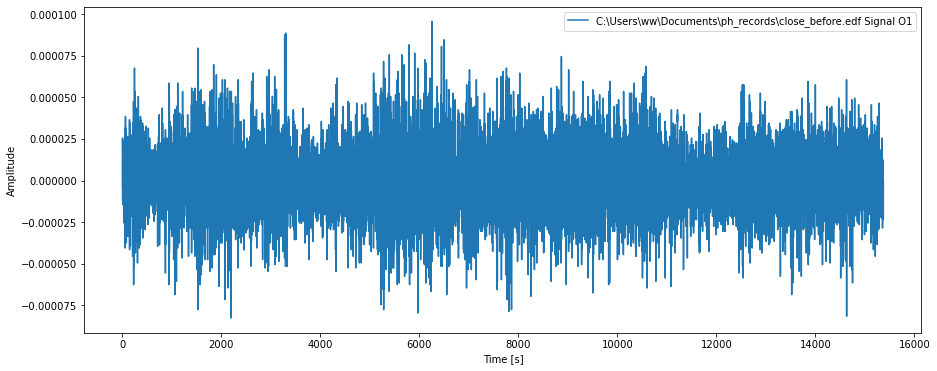

<Figure size 432x288 with 0 Axes>

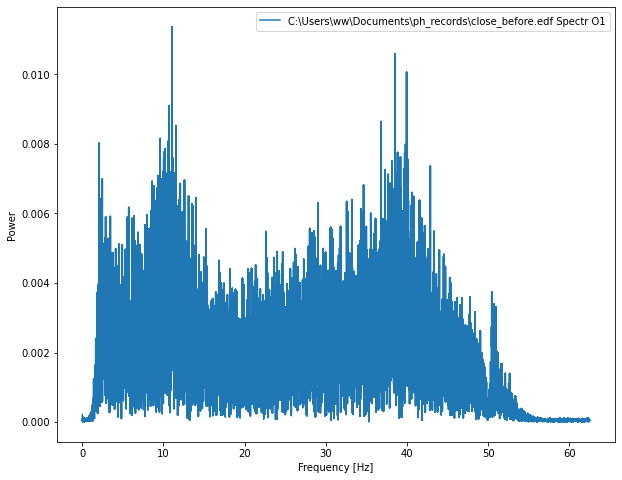

<Figure size 432x288 with 0 Axes>

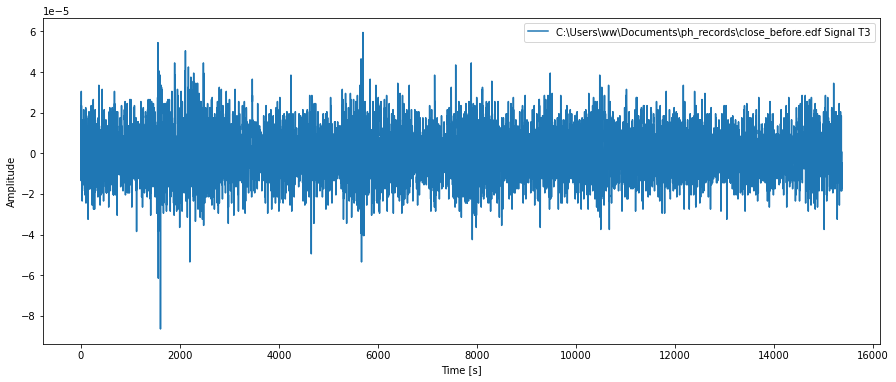

<Figure size 432x288 with 0 Axes>

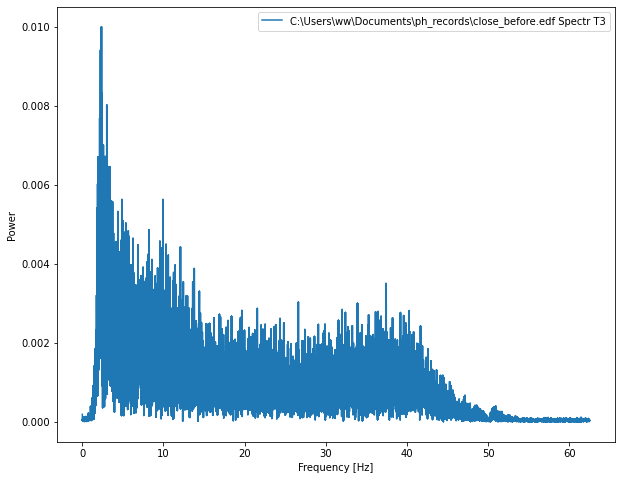

<Figure size 432x288 with 0 Axes>

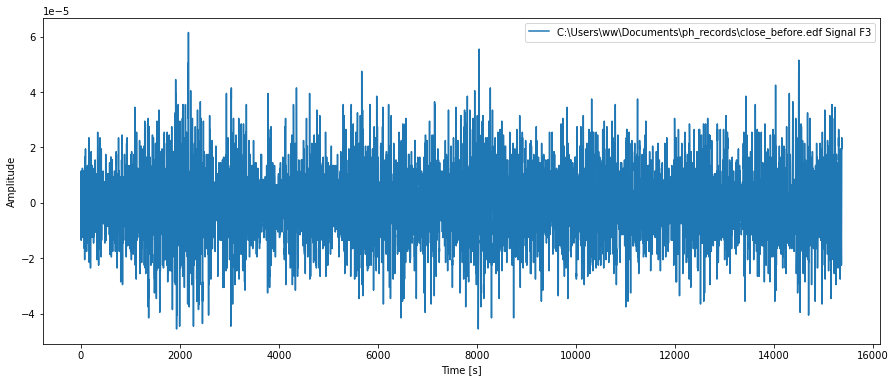

<Figure size 432x288 with 0 Axes>

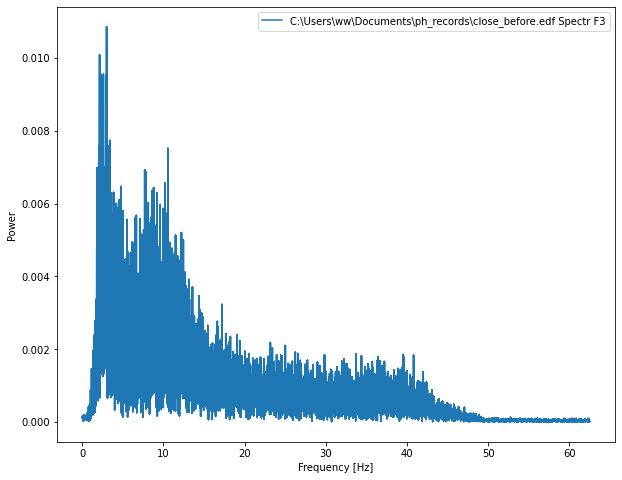

<Figure size 432x288 with 0 Axes>

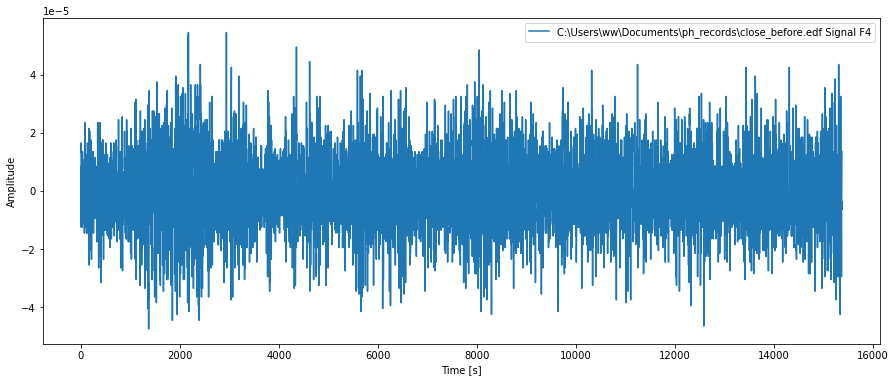

<Figure size 432x288 with 0 Axes>

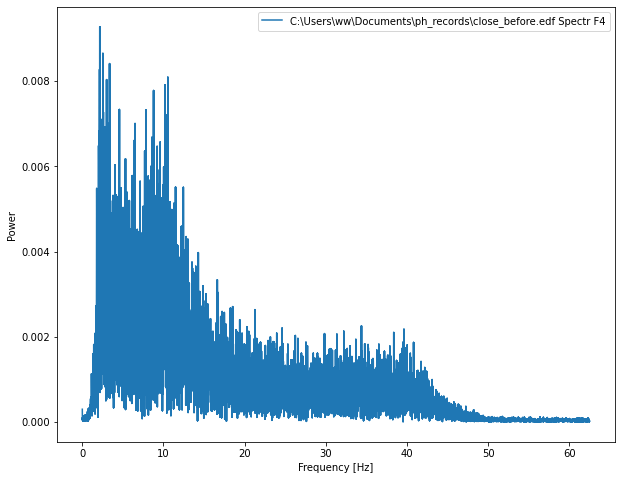

<Figure size 432x288 with 0 Axes>

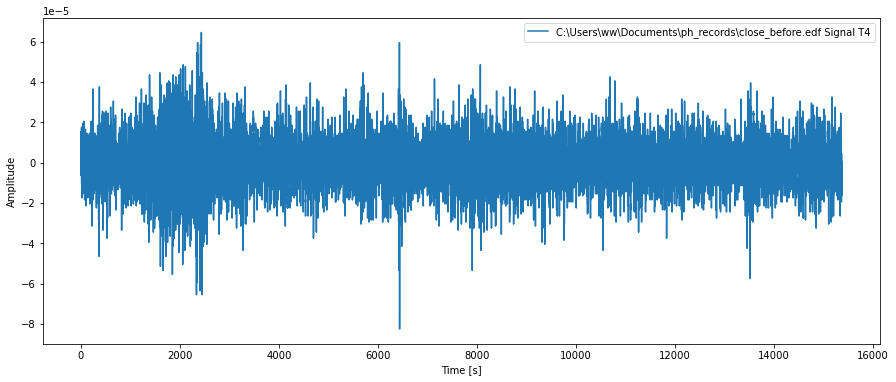

<Figure size 432x288 with 0 Axes>

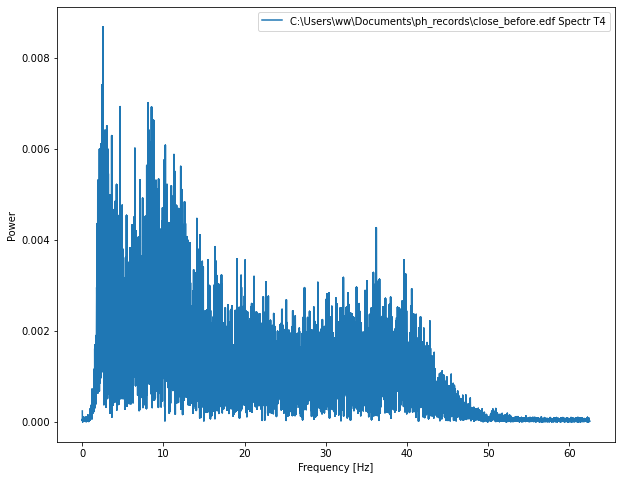

<Figure size 432x288 with 0 Axes>

In [72]:
length_main2 = length2
file_with_record_main2 = new_file_with_record2
sample_rate_main2 = sample_rate2
edffile_main2 = edffile_state2

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main2[chan],length_main2,1,edffile_main2+' Signal '+raw_mne2.ch_names[chan])
    
    draw_spectr(file_with_record_main2[chan],sample_rate_main2,edffile_main2+' Spectr '+raw_mne2.ch_names[chan])
    


# открытые глаза после тр

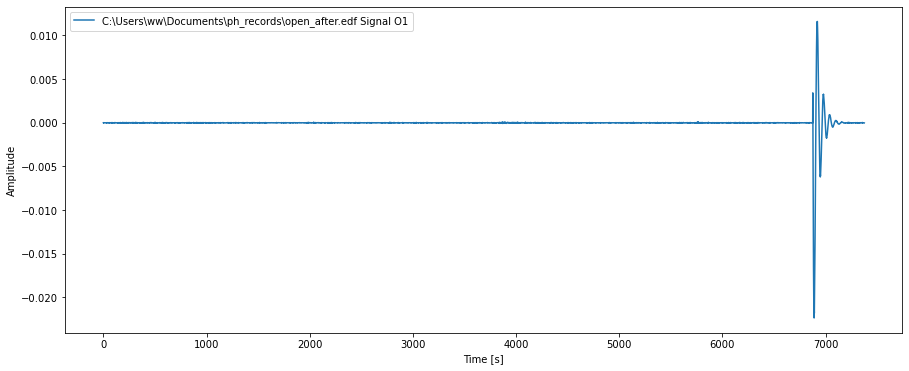

<Figure size 432x288 with 0 Axes>

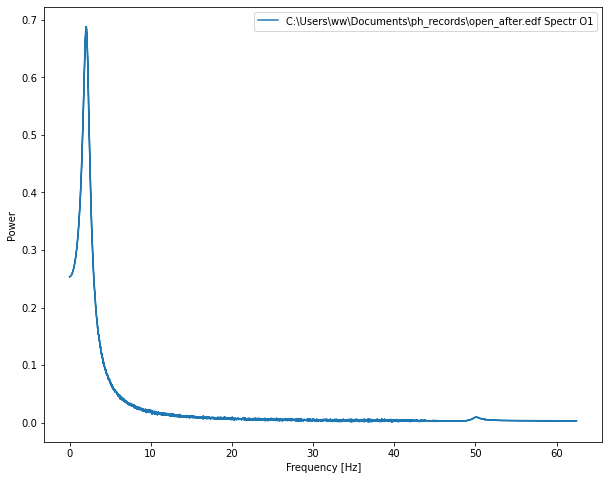

<Figure size 432x288 with 0 Axes>

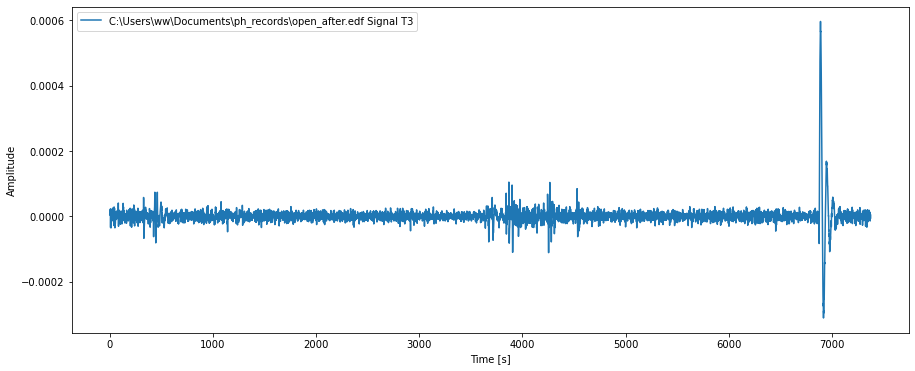

<Figure size 432x288 with 0 Axes>

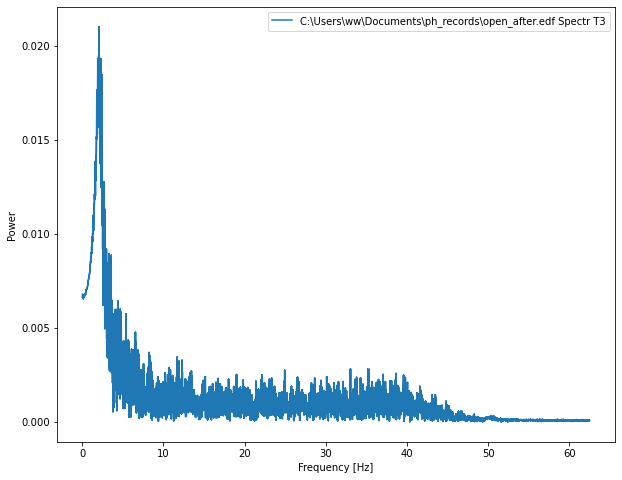

<Figure size 432x288 with 0 Axes>

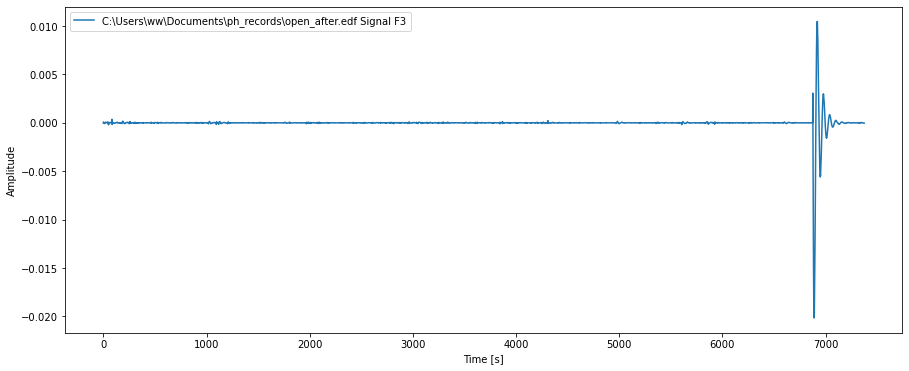

<Figure size 432x288 with 0 Axes>

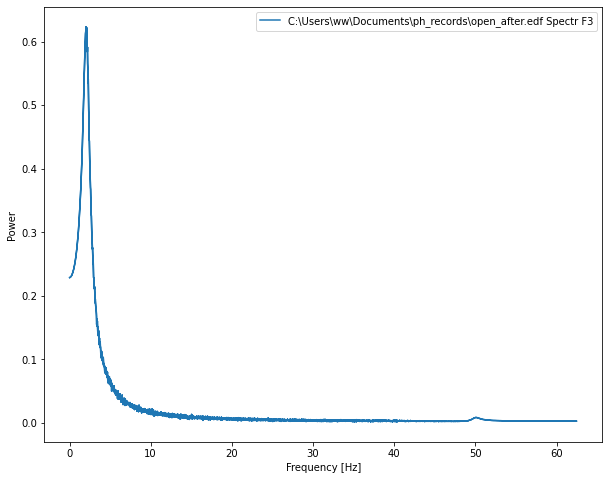

<Figure size 432x288 with 0 Axes>

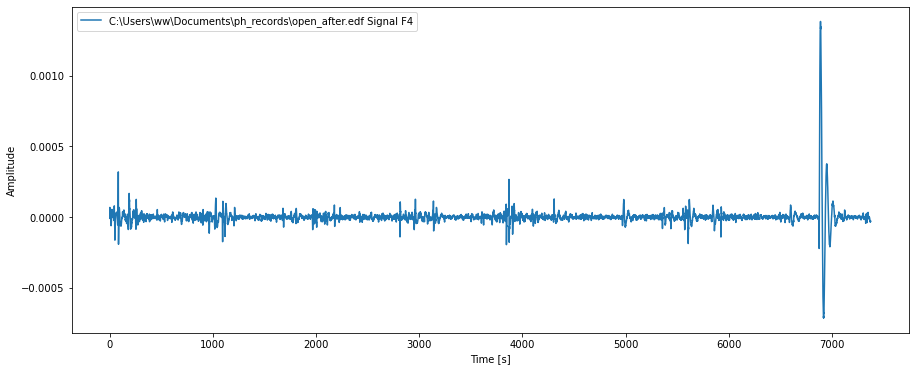

<Figure size 432x288 with 0 Axes>

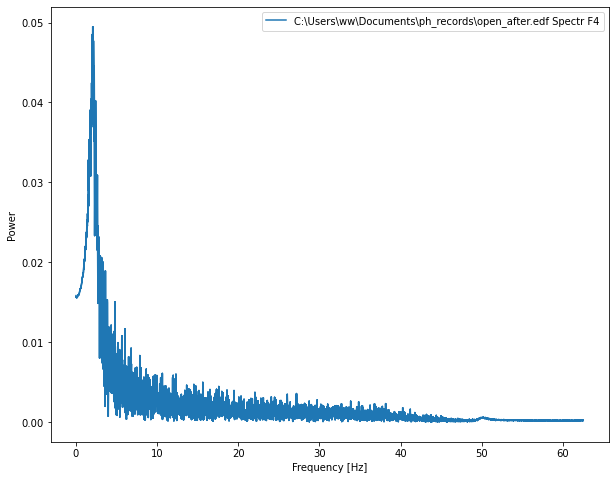

<Figure size 432x288 with 0 Axes>

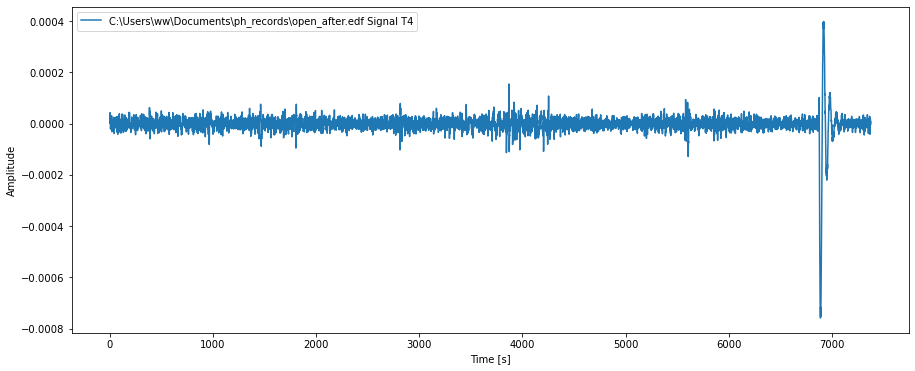

<Figure size 432x288 with 0 Axes>

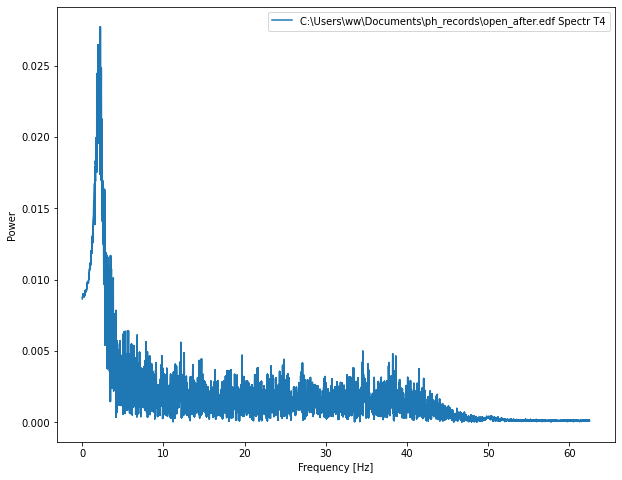

<Figure size 432x288 with 0 Axes>

In [73]:
length_main5 = length5
file_with_record_main5 = new_file_with_record5
sample_rate_main5 = sample_rate5
edffile_main5 = edffile_state5

# в цикле по всем каналам 
for chan in range(0,nchan-1):
    # Рисуем любой массив сигнала
    draw_signal(file_with_record_main5[chan],length_main5,1,edffile_main5+' Signal '+raw_mne5.ch_names[chan])
    
    draw_spectr(file_with_record_main5[chan],sample_rate_main5,edffile_main5+' Spectr '+raw_mne5.ch_names[chan])
    


In [ ]:
# Сначала анализируем первую запись, потом вторую
# Ниже будет часть, который автоматически начнет сравнивать обе записи   

#  открытые до тр

In [75]:
# внимательно ставим все параметры для обработки 
length_main1 = len(new_file_with_record1[0])
file_with_record_main1 = new_file_with_record1
sample_rate_main1 = sample_rate1
edffile_main1 = edffile_state1

# Создаем сигналы по выбранным наборам частот
delta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
theta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
alpha_signal1 = np.empty((nchan,length_main1),dtype=np.object)
beta1_signal1 = np.empty((nchan,length_main1),dtype=np.object)
beta2_signal1 = np.empty((nchan,length_main1),dtype=np.object)
gamma_signal1 = np.empty((nchan,length_main1),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main6,4)
    theta_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main6,5)
    alpha_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main6,5)
    beta1_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main6,6)
    beta2_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main6,8)
    gamma_signal1[chan] = butter_bandpass_filter(file_with_record_main1[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main6,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1890548735.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1890548735.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1890548735.py:10: DeprecationWarning: `np.object` is a deprecated alias for the built

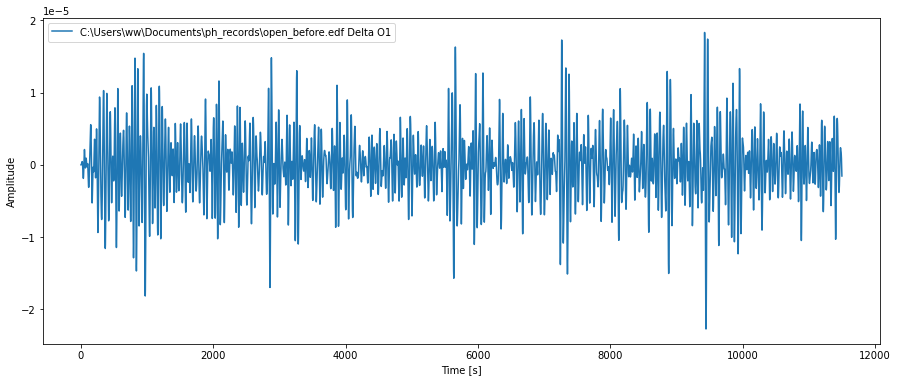

<Figure size 432x288 with 0 Axes>

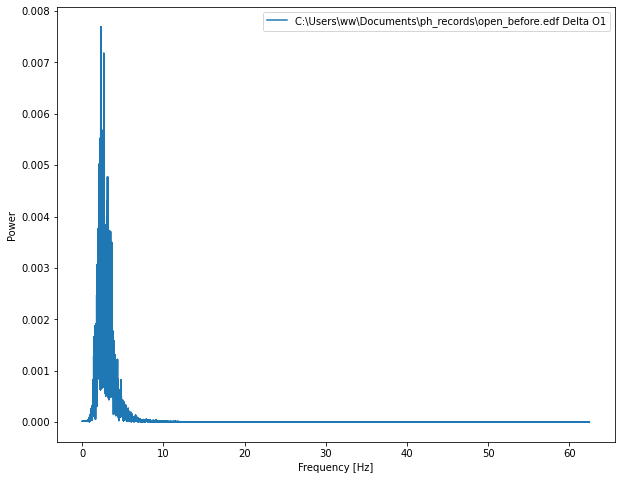

<Figure size 432x288 with 0 Axes>

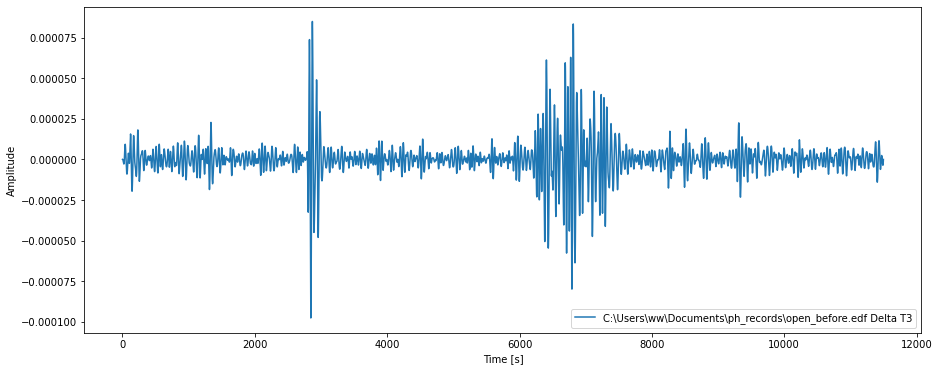

<Figure size 432x288 with 0 Axes>

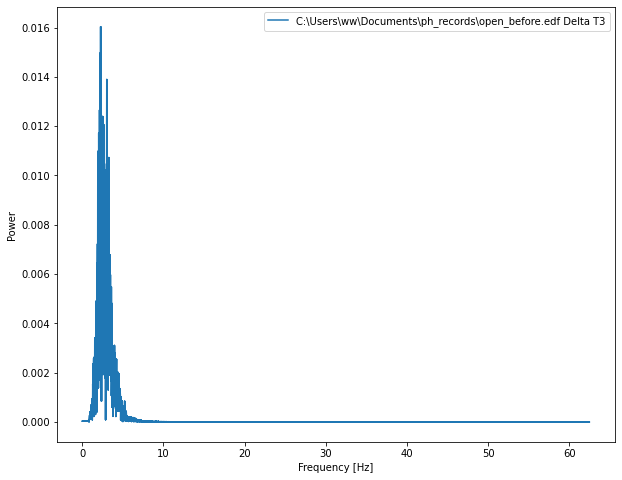

<Figure size 432x288 with 0 Axes>

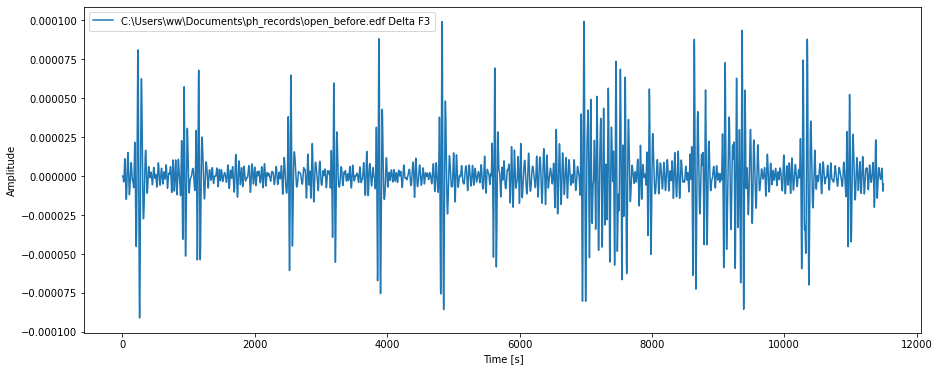

<Figure size 432x288 with 0 Axes>

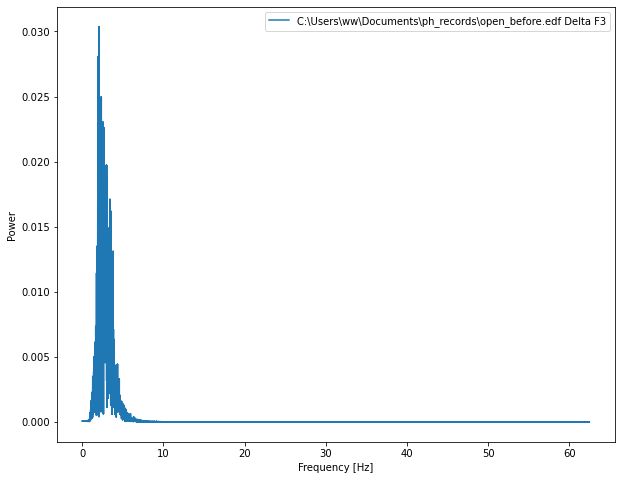

<Figure size 432x288 with 0 Axes>

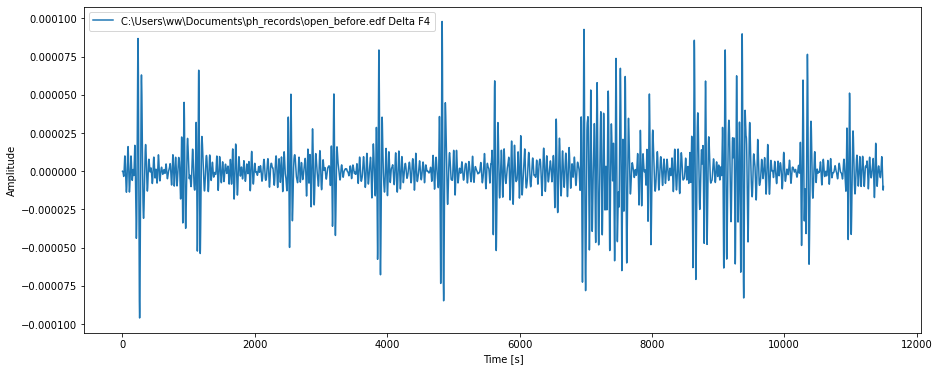

<Figure size 432x288 with 0 Axes>

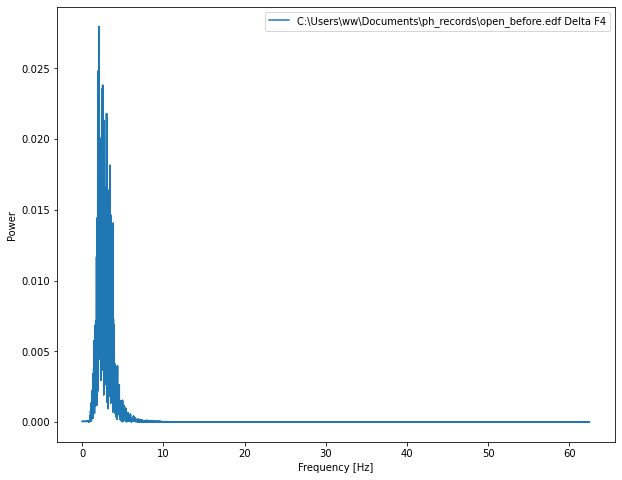

<Figure size 432x288 with 0 Axes>

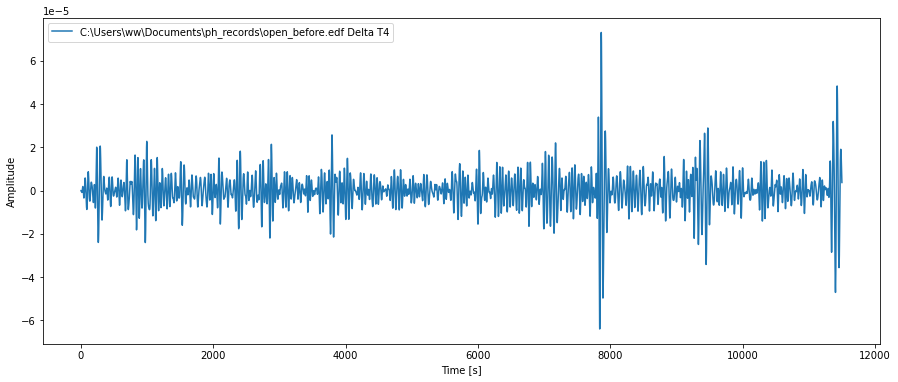

<Figure size 432x288 with 0 Axes>

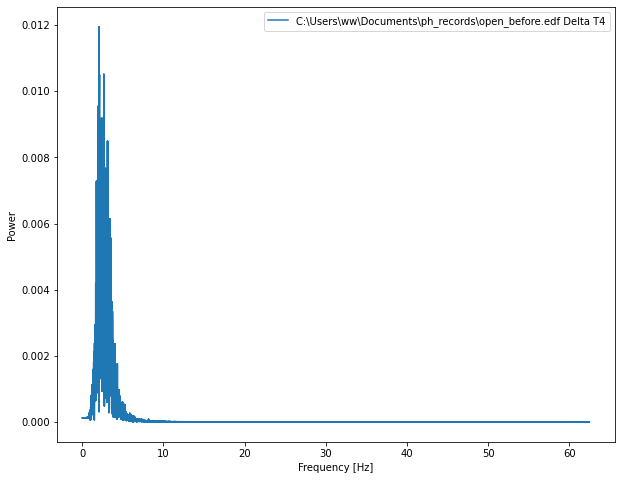

<Figure size 432x288 with 0 Axes>

In [76]:
# Порисуем файлы, выставляем корректно lables
# Посмотрим на значения сигнала по конкретным полосам и каналам

# Рисуем любой массив сигнала
# Рисуем спектр любого массива сигнала
# в цикле по всем каналам 
for chan in range(0,nchan-1):
    draw_signal(delta_signal1[chan],length_main1,1,edffile_main1+' Delta '+raw_mne1.ch_names[chan])
    draw_spectr(delta_signal1[chan],sample_rate_main1,edffile_main1+' Delta '+raw_mne1.ch_names[chan])

# считаем общепринятые характеристики

In [77]:
def Total(delta_signal, alpha_signal, theta_signal, beta1_signal, beta2_signal, gamma_signal, length_main1):
    Total_Power1 = []
    concentration = []
    meditation = []
    for chan in range(0,nchan-1):
        data1 = alpha_signal[chan]
        data2 = delta_signal[chan]
        data3 = theta_signal[chan]
        data4 = beta1_signal[chan]
        data5 = beta2_signal[chan]
        data6 = gamma_signal[chan]
        dic = dict()
        dic['alpha'] = np.sum(data1**2)/length_main1
        dic['delta'] = np.sum(data2**2)/length_main1
        dic['theta'] = np.sum(data3**2)/length_main1
        dic['beta1'] = np.sum(data4**2)/length_main1
        dic['beta2'] = np.sum(data5**2)/length_main1
        dic['gamma'] = np.sum(data6**2)/length_main1
        Total_Power1.append(dic)
        concentration.append((dic['beta1']+dic['beta2'])/dic['theta'])
        meditation.append(dic['alpha']/sum(dic.values()))
        
    good = Total_Power1[3]['alpha']/Total_Power1[2]['alpha']
    return good, concentration, meditation


In [78]:
good1, conc1, meditation1 = Total(delta_signal1, alpha_signal1, theta_signal1, beta1_signal1, beta2_signal1, gamma_signal1, length_main1)
print('good', good1)
print('концентрация', conc1)
print('медитация', meditation1)

good 1.0254229206693106
концентрация [6.976110694999475, 1.6058776715385943, 0.16511895952408082, 0.17602616380141045, 7.967304161935161]
медитация [0.09933219491264149, 0.08271695959582238, 0.09430078340568605, 0.10274991046943983, 0.08251441598411373]


# закрытые до тр

In [79]:
# внимательно ставим все параметры для обработки 
length_main2 = len(new_file_with_record2[0])
file_with_record_main2 = new_file_with_record2
sample_rate_main2 = sample_rate2
edffile_main2 = edffile_state2

# Создаем сигналы по выбранным наборам частот
delta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
theta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
alpha_signal2 = np.empty((nchan,length_main2),dtype=np.object)
beta1_signal2 = np.empty((nchan,length_main2),dtype=np.object)
beta2_signal2 = np.empty((nchan,length_main2),dtype=np.object)
gamma_signal2 = np.empty((nchan,length_main2),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main2,4)
    theta_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main2,5)
    alpha_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main2,5)
    beta1_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main2,6)
    beta2_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main2,8)
    gamma_signal2[chan] = butter_bandpass_filter(file_with_record_main2[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main2,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2875445156.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2875445156.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2875445156.py:10: DeprecationWarning: `np.object` is a deprecated alias for the built

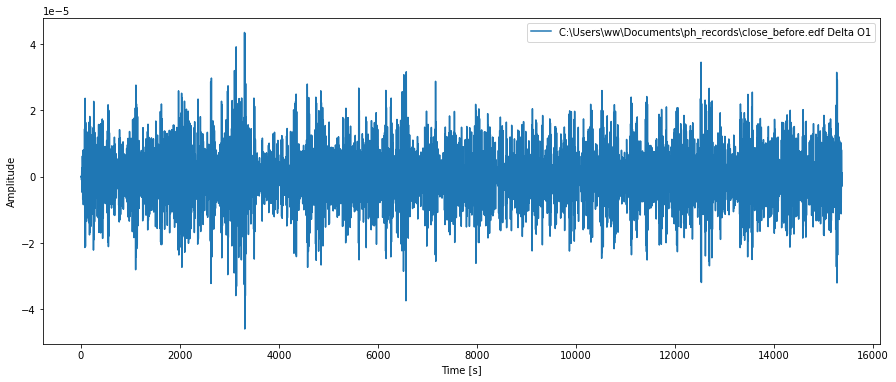

<Figure size 432x288 with 0 Axes>

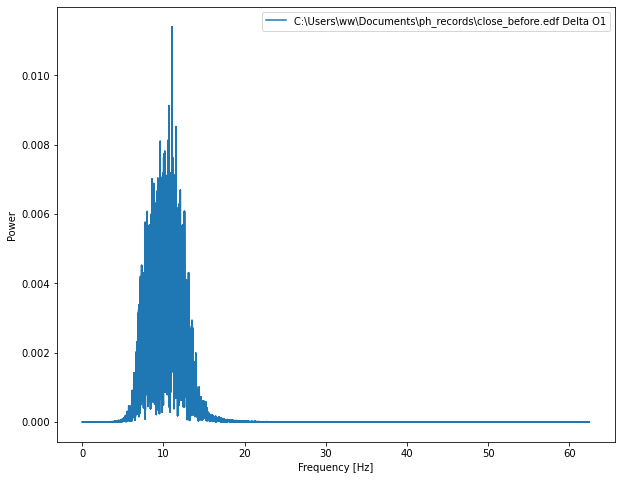

<Figure size 432x288 with 0 Axes>

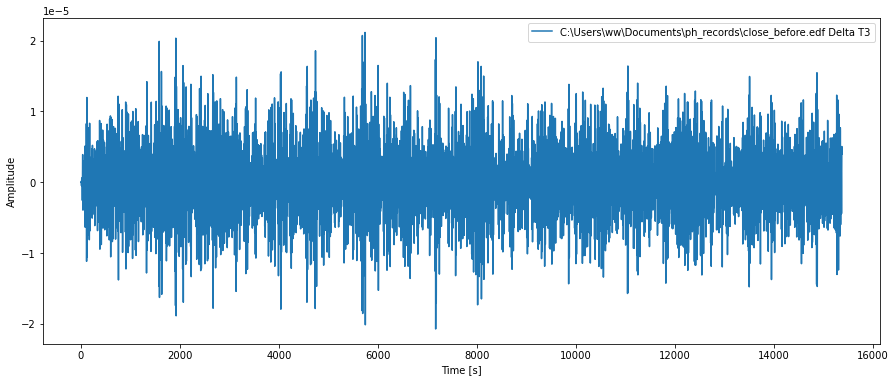

<Figure size 432x288 with 0 Axes>

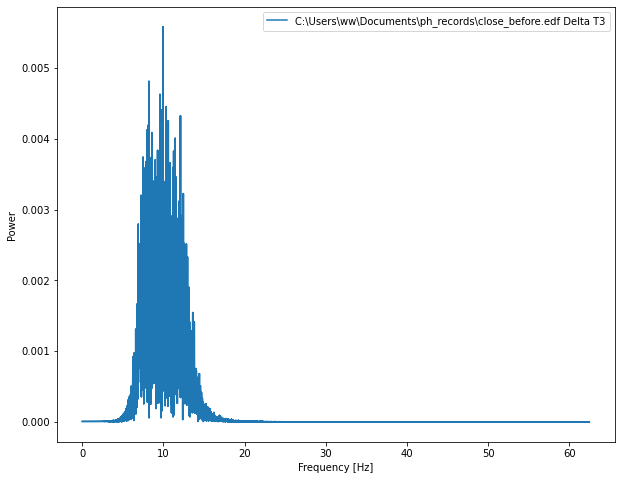

<Figure size 432x288 with 0 Axes>

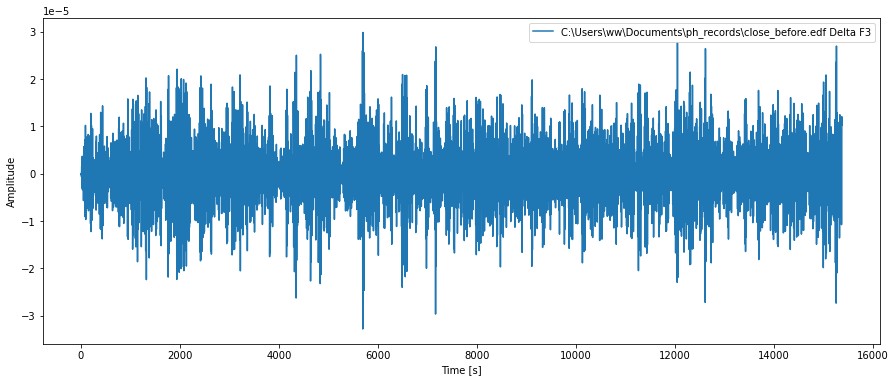

<Figure size 432x288 with 0 Axes>

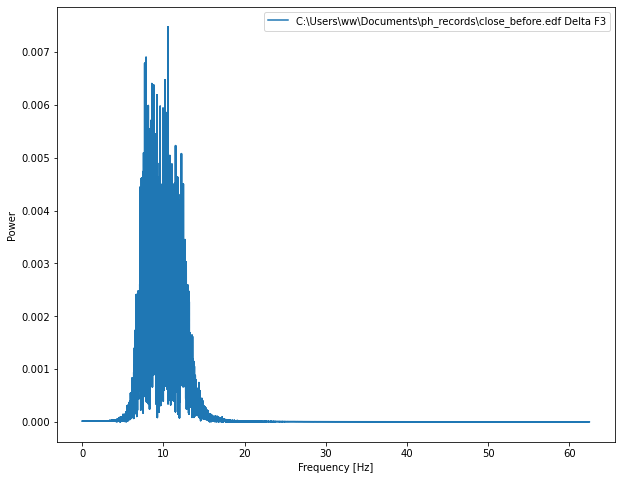

<Figure size 432x288 with 0 Axes>

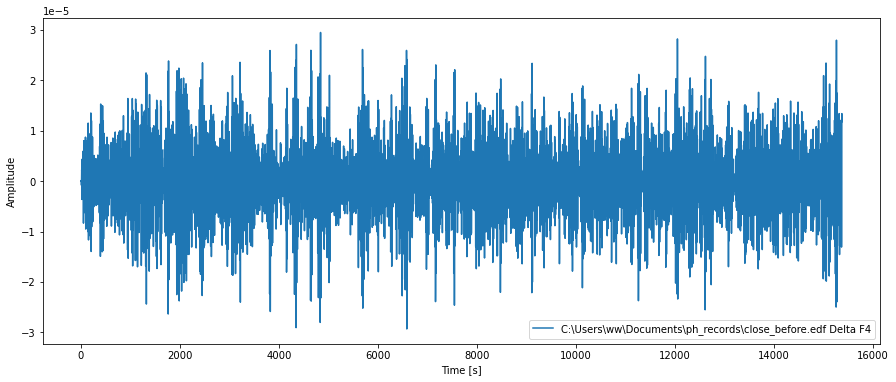

<Figure size 432x288 with 0 Axes>

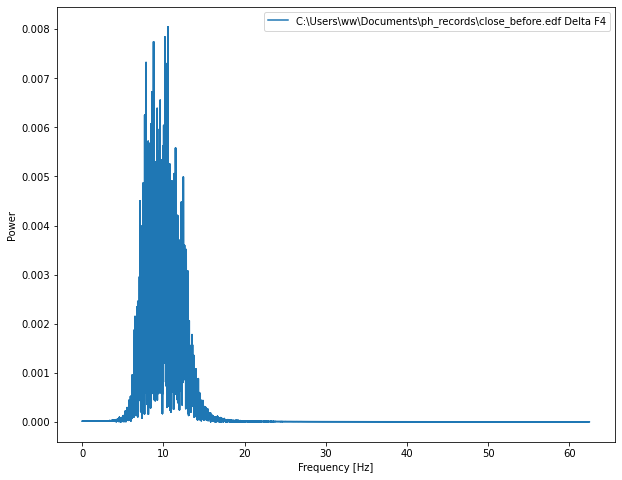

<Figure size 432x288 with 0 Axes>

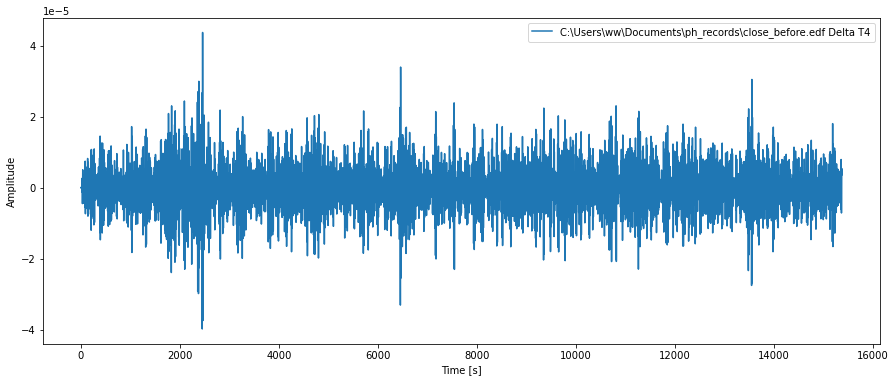

<Figure size 432x288 with 0 Axes>

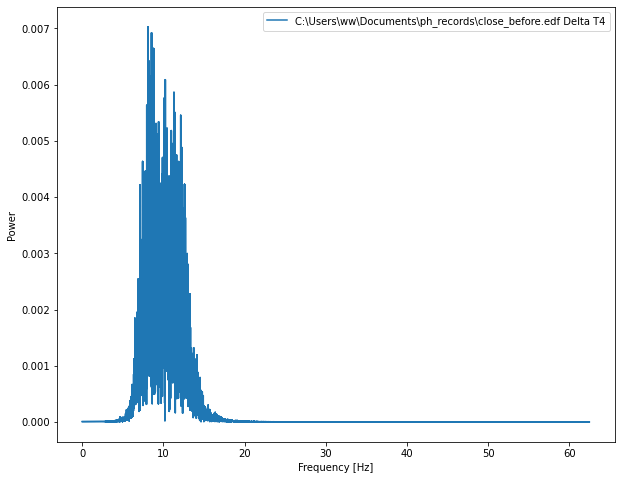

<Figure size 432x288 with 0 Axes>

In [80]:
# Порисуем файлы, выставляем корректно lables
# Посмотрим на значения сигнала по конкретным полосам и каналам

# Рисуем любой массив сигнала
# Рисуем спектр любого массива сигнала
# в цикле по всем каналам 
for chan in range(0,nchan-1):
    draw_signal(alpha_signal2[chan],length_main2,1,edffile_main2+' Delta '+raw_mne2.ch_names[chan])
    draw_spectr(alpha_signal2[chan],sample_rate_main2,edffile_main2+' Delta '+raw_mne2.ch_names[chan])

In [81]:
good2, conc2, meditation2 = Total(delta_signal2, alpha_signal2, theta_signal2, beta1_signal2, beta2_signal2, gamma_signal2, length_main2)
print('good', good2)
print('концентрация', conc2)
print('медитация', meditation2)

good 1.1295995481141385
концентрация [4.466419809268218, 1.2798818837272816, 0.8248799709786562, 1.023715915317964, 2.0127690959450137]
медитация [0.22850113782587703, 0.23121279089279614, 0.3550511236530385, 0.40381504913651406, 0.32854438335499675]


# игра 1 (концентрация)

In [83]:
# внимательно ставим все параметры для обработки 
length_main3 = len(new_file_with_record3[0])
file_with_record_main3 = new_file_with_record3
sample_rate_main3 = sample_rate3
edffile_main3 = edffile_state3

# Создаем сигналы по выбранным наборам частот
delta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
theta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
alpha_signal3 = np.empty((nchan,length_main3),dtype=np.object)
beta1_signal3 = np.empty((nchan,length_main3),dtype=np.object)
beta2_signal3 = np.empty((nchan,length_main3),dtype=np.object)
gamma_signal3 = np.empty((nchan,length_main3),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main2,4)
    theta_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main2,5)
    alpha_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main2,5)
    beta1_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main2,6)
    beta2_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main2,8)
    gamma_signal3[chan] = butter_bandpass_filter(file_with_record_main3[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main2,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2399236957.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2399236957.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2399236957.py:10: DeprecationWarning: `np.object` is a deprecated alias for the built

In [84]:
good3, conc3, meditation3 = Total(delta_signal3, alpha_signal3, theta_signal3, beta1_signal3, beta2_signal3, gamma_signal3, length_main3)
print('good', good3)
print('концентрация', conc3)
print('медитация', meditation3)

good 1.1536535399985728
концентрация [2.5559490686793365, 2.1000761119895794, 0.7589223443992199, 0.78145090932639, 2.8867653264834794]
медитация [0.26299935439040223, 0.17045832042275127, 0.2822818216455614, 0.2937496277612657, 0.2325287687991897]


# игра 2(медитация)

In [85]:
# внимательно ставим все параметры для обработки 
length_main4 = len(new_file_with_record4[0])
file_with_record_main4 = new_file_with_record4
sample_rate_main4 = sample_rate4
edffile_main4 = edffile_state4

# Создаем сигналы по выбранным наборам частот
delta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
theta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
alpha_signal4 = np.empty((nchan,length_main4),dtype=np.object)
beta1_signal4 = np.empty((nchan,length_main4),dtype=np.object)
beta2_signal4 = np.empty((nchan,length_main4),dtype=np.object)
gamma_signal4 = np.empty((nchan,length_main4),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main2,4)
    theta_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main2,5)
    alpha_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main2,5)
    beta1_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main2,6)
    beta2_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main2,8)
    gamma_signal4[chan] = butter_bandpass_filter(file_with_record_main4[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main2,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\171374877.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\171374877.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\171374877.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin 

In [86]:
good4, conc4, meditation4 = Total(delta_signal4, alpha_signal4, theta_signal4, beta1_signal4, beta2_signal4, gamma_signal4, length_main4)
print('good', good4)
print('концентрация', conc4)
print('медитация', meditation4)

good 1.1887218960887727
концентрация [3.7883088849853706, 4.621266210453186, 1.1893401183460008, 1.304678942284494, 5.795416203162257]
медитация [0.15310376208528303, 0.1028720849202742, 0.23366413687596113, 0.24997934707185113, 0.13828786290552042]


# открытые после тр

In [87]:
# внимательно ставим все параметры для обработки 
length_main5 = len(new_file_with_record5[0])
file_with_record_main5 = new_file_with_record5
sample_rate_main5 = sample_rate5
edffile_main5 = edffile_state5

# Создаем сигналы по выбранным наборам частот
delta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
theta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
alpha_signal5 = np.empty((nchan,length_main5),dtype=np.object)
beta1_signal5 = np.empty((nchan,length_main5),dtype=np.object)
beta2_signal5 = np.empty((nchan,length_main5),dtype=np.object)
gamma_signal5 = np.empty((nchan,length_main5),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main2,4)
    theta_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main2,5)
    alpha_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main2,5)
    beta1_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main2,6)
    beta2_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main2,8)
    gamma_signal5[chan] = butter_bandpass_filter(file_with_record_main5[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main2,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\999267441.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\999267441.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\999267441.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin 

In [92]:
good5, conc5, meditation5 = Total(delta_signal5, alpha_signal5, theta_signal5, beta1_signal5, beta2_signal5, gamma_signal5, length_main5)
print('good', good5)
print('концентрация', conc5)
print('медитация', meditation5)

good 0.02640441536028182
концентрация [0.05560711612426262, 0.7403408276701148, 0.056541106887130974, 0.4475928728888419, 1.4025620094111857]
медитация [0.00555493140228877, 0.03249988261794414, 0.005558583617254607, 0.02838737922017287, 0.04352662575261706]


# закртые после тр

In [90]:
# внимательно ставим все параметры для обработки 
length_main6 = len(new_file_with_record6[0])
file_with_record_main6 = new_file_with_record6
sample_rate_main6 = sample_rate6
edffile_main6 = edffile_state6

# Создаем сигналы по выбранным наборам частот
delta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
theta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
alpha_signal6 = np.empty((nchan,length_main6),dtype=np.object)
beta1_signal6 = np.empty((nchan,length_main6),dtype=np.object)
beta2_signal6 = np.empty((nchan,length_main6),dtype=np.object)
gamma_signal6 = np.empty((nchan,length_main6),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main2,4)
    theta_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main2,5)
    alpha_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main2,5)
    beta1_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main2,6)
    beta2_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main2,8)
    gamma_signal6[chan] = butter_bandpass_filter(file_with_record_main6[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main2,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2152662149.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2152662149.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2152662149.py:10: DeprecationWarning: `np.object` is a deprecated alias for the built

In [91]:
good6, conc6, meditation6 = Total(delta_signal6, alpha_signal6, theta_signal6, beta1_signal6, beta2_signal6, gamma_signal6, length_main6)
print('good', good6)
print('концентрация', conc6)
print('медитация', meditation6)

good 1.1529314657778873
концентрация [1.5758128117336996, 2.5701665174468262, 0.9838451963463862, 0.9069474443367694, 2.0521548813120623]
медитация [0.5283988650637825, 0.2781064236241721, 0.402077463736613, 0.4433185254385928, 0.3100134082754836]


# метод преобразование Hilbert-a

In [126]:
hilbert_delta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
hilbert_theta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
hilbert_alpha_signal1 = np.empty((nchan,length_main1),dtype=np.object)
hilbert_beta1_signal1 = np.empty((nchan,length_main1),dtype=np.object)
hilbert_beta2_signal1 = np.empty((nchan,length_main1),dtype=np.object)
hilbert_gamma_signal1 = np.empty((nchan,length_main1),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal1[chan] = np.abs(hilbert(delta_signal1[chan]))
    hilbert_theta_signal1[chan] = np.abs(hilbert(theta_signal1[chan]))
    hilbert_alpha_signal1[chan] = np.abs(hilbert(alpha_signal1[chan]))
    hilbert_beta1_signal1[chan] = np.abs(hilbert(beta1_signal1[chan]))
    hilbert_beta2_signal1[chan] = np.abs(hilbert(beta2_signal1[chan]))
    hilbert_gamma_signal1[chan] = np.abs(hilbert(gamma_signal1[chan]))
    print('Channel ' + str(chan) + ' completed')
    
hilbert_delta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
hilbert_theta_signal2 = np.empty((nchan,length_main2),dtype=np.object)
hilbert_alpha_signal2 = np.empty((nchan,length_main2),dtype=np.object)
hilbert_beta1_signal2 = np.empty((nchan,length_main2),dtype=np.object)
hilbert_beta2_signal2 = np.empty((nchan,length_main2),dtype=np.object)
hilbert_gamma_signal2 = np.empty((nchan,length_main2),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal2[chan] = np.abs(hilbert(delta_signal2[chan]))
    hilbert_theta_signal2[chan] = np.abs(hilbert(theta_signal2[chan]))
    hilbert_alpha_signal2[chan] = np.abs(hilbert(alpha_signal2[chan]))
    hilbert_beta1_signal2[chan] = np.abs(hilbert(beta1_signal2[chan]))
    hilbert_beta2_signal2[chan] = np.abs(hilbert(beta2_signal2[chan]))
    hilbert_gamma_signal2[chan] = np.abs(hilbert(gamma_signal2[chan]))
    print('Channel ' + str(chan) + ' completed')

hilbert_delta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
hilbert_theta_signal3 = np.empty((nchan,length_main3),dtype=np.object)
hilbert_alpha_signal3 = np.empty((nchan,length_main3),dtype=np.object)
hilbert_beta1_signal3 = np.empty((nchan,length_main3),dtype=np.object)
hilbert_beta2_signal3 = np.empty((nchan,length_main3),dtype=np.object)
hilbert_gamma_signal3 = np.empty((nchan,length_main3),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal3[chan] = np.abs(hilbert(delta_signal3[chan]))
    hilbert_theta_signal3[chan] = np.abs(hilbert(theta_signal3[chan]))
    hilbert_alpha_signal3[chan] = np.abs(hilbert(alpha_signal3[chan]))
    hilbert_beta1_signal3[chan] = np.abs(hilbert(beta1_signal3[chan]))
    hilbert_beta2_signal3[chan] = np.abs(hilbert(beta2_signal3[chan]))
    hilbert_gamma_signal3[chan] = np.abs(hilbert(gamma_signal3[chan]))
    print('Channel ' + str(chan) + ' completed')
    
hilbert_delta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
hilbert_theta_signal4 = np.empty((nchan,length_main4),dtype=np.object)
hilbert_alpha_signal4 = np.empty((nchan,length_main4),dtype=np.object)
hilbert_beta1_signal4 = np.empty((nchan,length_main4),dtype=np.object)
hilbert_beta2_signal4 = np.empty((nchan,length_main4),dtype=np.object)
hilbert_gamma_signal4 = np.empty((nchan,length_main4),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal4[chan] = np.abs(hilbert(delta_signal4[chan]))
    hilbert_theta_signal4[chan] = np.abs(hilbert(theta_signal4[chan]))
    hilbert_alpha_signal4[chan] = np.abs(hilbert(alpha_signal4[chan]))
    hilbert_beta1_signal4[chan] = np.abs(hilbert(beta1_signal4[chan]))
    hilbert_beta2_signal4[chan] = np.abs(hilbert(beta2_signal4[chan]))
    hilbert_gamma_signal4[chan] = np.abs(hilbert(gamma_signal4[chan]))
    print('Channel ' + str(chan) + ' completed')
    
hilbert_delta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
hilbert_theta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
hilbert_alpha_signal5 = np.empty((nchan,length_main5),dtype=np.object)
hilbert_beta1_signal5 = np.empty((nchan,length_main5),dtype=np.object)
hilbert_beta2_signal5 = np.empty((nchan,length_main5),dtype=np.object)
hilbert_gamma_signal5 = np.empty((nchan,length_main5),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal5[chan] = np.abs(hilbert(delta_signal5[chan]))
    hilbert_theta_signal5[chan] = np.abs(hilbert(theta_signal5[chan]))
    hilbert_alpha_signal5[chan] = np.abs(hilbert(alpha_signal5[chan]))
    hilbert_beta1_signal5[chan] = np.abs(hilbert(beta1_signal5[chan]))
    hilbert_beta2_signal5[chan] = np.abs(hilbert(beta2_signal5[chan]))
    hilbert_gamma_signal5[chan] = np.abs(hilbert(gamma_signal5[chan]))
    print('Channel ' + str(chan) + ' completed')
    
hilbert_delta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
hilbert_theta_signal6 = np.empty((nchan,length_main6),dtype=np.object)
hilbert_alpha_signal6 = np.empty((nchan,length_main6),dtype=np.object)
hilbert_beta1_signal6 = np.empty((nchan,length_main6),dtype=np.object)
hilbert_beta2_signal6 = np.empty((nchan,length_main6),dtype=np.object)
hilbert_gamma_signal6 = np.empty((nchan,length_main6),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal6[chan] = np.abs(hilbert(delta_signal6[chan]))
    hilbert_theta_signal6[chan] = np.abs(hilbert(theta_signal6[chan]))
    hilbert_alpha_signal6[chan] = np.abs(hilbert(alpha_signal6[chan]))
    hilbert_beta1_signal6[chan] = np.abs(hilbert(beta1_signal6[chan]))
    hilbert_beta2_signal6[chan] = np.abs(hilbert(beta2_signal6[chan]))
    hilbert_gamma_signal6[chan] = np.abs(hilbert(gamma_signal6[chan]))
    print('Channel ' + str(chan) + ' completed')

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_delta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_theta_signal1 = np.empty((nchan,length_main1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:3: DeprecationWarning: `np.object` is a deprecated alia

Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed
Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed
Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed
Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed
Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed
Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed


C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:65: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_delta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:66: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_theta_signal5 = np.empty((nchan,length_main5),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3227898819.py:67: DeprecationWarning: `np.object` is a deprecated a

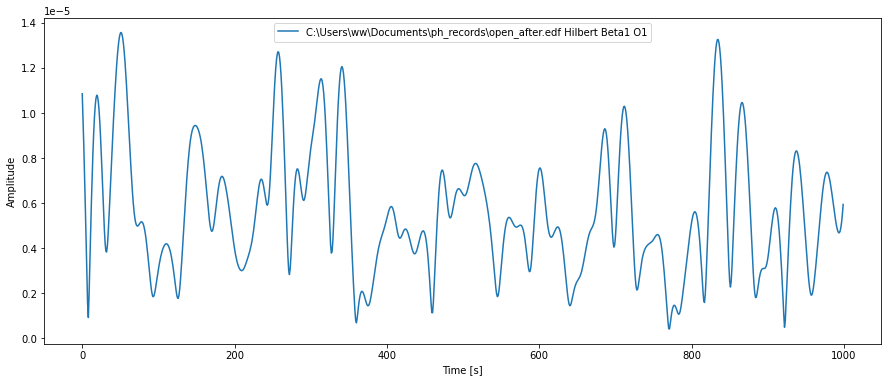

NameError: name 'raw_mne' is not defined

<Figure size 432x288 with 0 Axes>

In [94]:
# Порисуем файлы, выставляем корректно lables
# Посмотрим на значения сигнала после преобразования Hilbert по конкретным полосам и каналам

# Рисуем любой массив сигнала
# Рисуем спектр любого массива сигнала
# в цикле по всем каналам 
for chan in range(0,nchan-1):
    draw_signal(hilbert_beta1_signal5[chan][1000:2000],1000,1,edffile_main5+' Hilbert Beta1 '+raw_mne4.ch_names[chan])
    draw_spectr(hilbert_beta1_signal5[chan],sample_rate_main5,edffile_main4+' Hilbert Beta1 '+raw_mne.ch_names[chan])

In [95]:
# Параметры для дальнейшего использования
downsampled_coeff = 5 # адаптируем для человеческого глаза 25 кадров в секунду 125/5

# уменьшаем размерность сигнала для рисования
downsampled_length = int(round(length_main4/downsampled_coeff,0))

downsampled_hilbert_delta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_theta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_alpha_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_beta1_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_beta2_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_gamma_signal = np.empty((nchan,downsampled_length),dtype=np.object)

for chan in range(0,nchan):
    counter_downsampled = 0
    for i in range(0,length_main6,downsampled_coeff):
        temp_sum_delta = 0
        temp_sum_theta = 0
        temp_sum_alpha = 0
        temp_sum_beta1 = 0
        temp_sum_beta2 = 0
        temp_sum_gamma = 0
        for j in range(0,downsampled_coeff,1):
            temp_sum_delta += hilbert_delta_signal6[chan][i+j]
            temp_sum_theta += hilbert_theta_signal6[chan][i+j]
            temp_sum_alpha += hilbert_alpha_signal6[chan][i+j]
            temp_sum_beta1 += hilbert_beta1_signal6[chan][i+j]
            temp_sum_beta2 += hilbert_beta2_signal6[chan][i+j]
            temp_sum_gamma += hilbert_gamma_signal6[chan][i+j]
        downsampled_hilbert_delta_signal[chan][counter_downsampled] = temp_sum_delta/downsampled_coeff
        downsampled_hilbert_theta_signal[chan][counter_downsampled] = temp_sum_theta/downsampled_coeff
        downsampled_hilbert_alpha_signal[chan][counter_downsampled] = temp_sum_alpha/downsampled_coeff
        downsampled_hilbert_beta1_signal[chan][counter_downsampled] = temp_sum_beta1/downsampled_coeff
        downsampled_hilbert_beta2_signal[chan][counter_downsampled] = temp_sum_beta2/downsampled_coeff
        downsampled_hilbert_gamma_signal[chan][counter_downsampled] = temp_sum_gamma/downsampled_coeff
        counter_downsampled += 1

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1076594433.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  downsampled_hilbert_delta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1076594433.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  downsampled_hilbert_theta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1076594433.py:9: DeprecationWarning

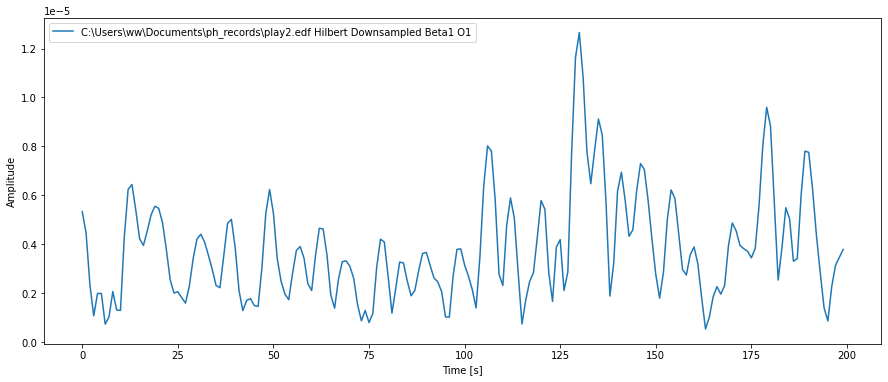

<Figure size 432x288 with 0 Axes>

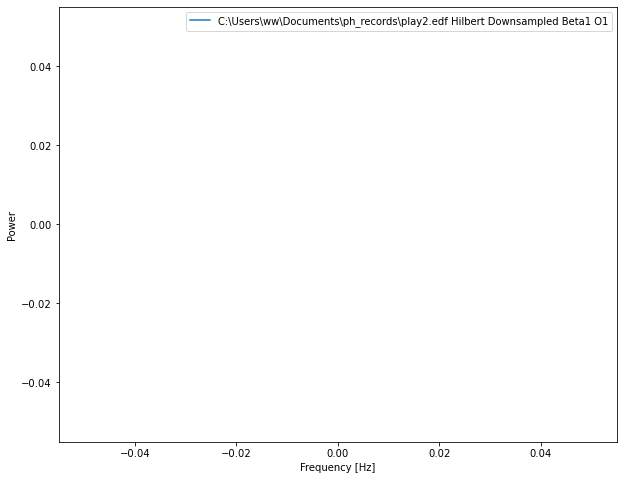

<Figure size 432x288 with 0 Axes>

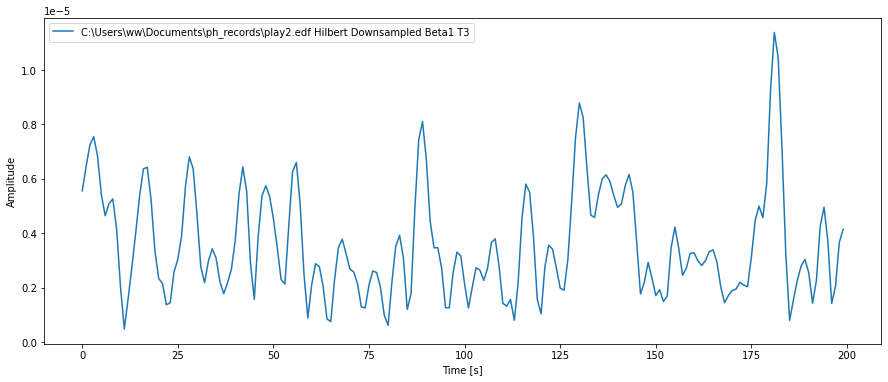

<Figure size 432x288 with 0 Axes>

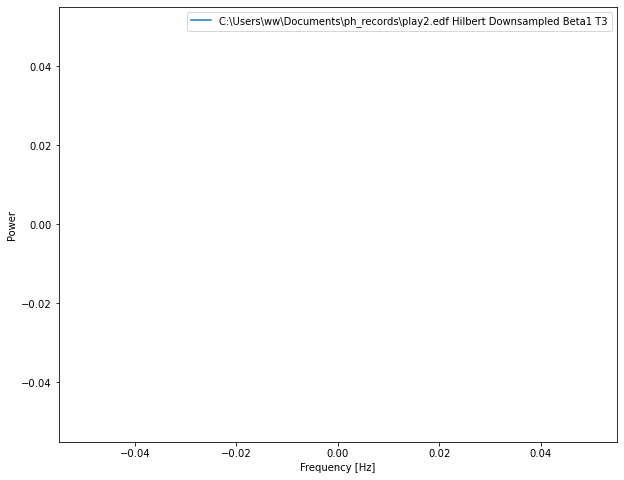

<Figure size 432x288 with 0 Axes>

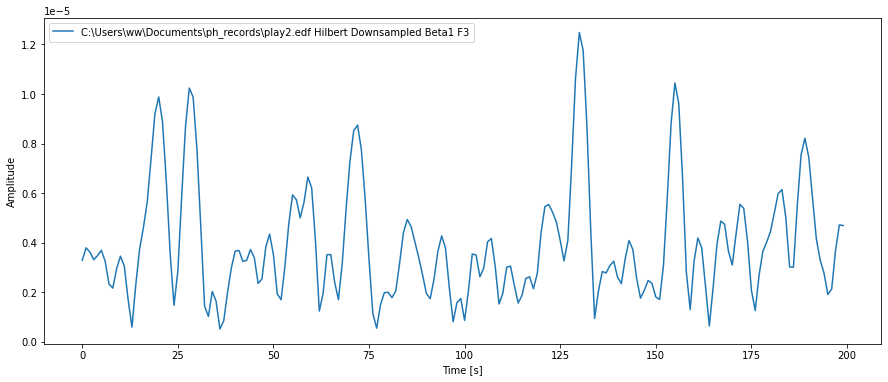

<Figure size 432x288 with 0 Axes>

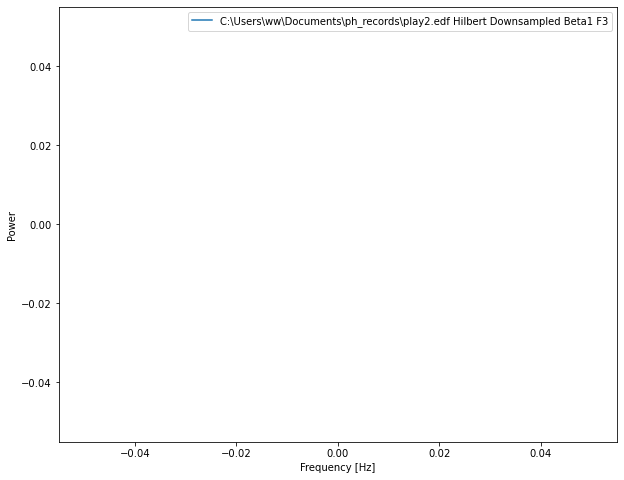

<Figure size 432x288 with 0 Axes>

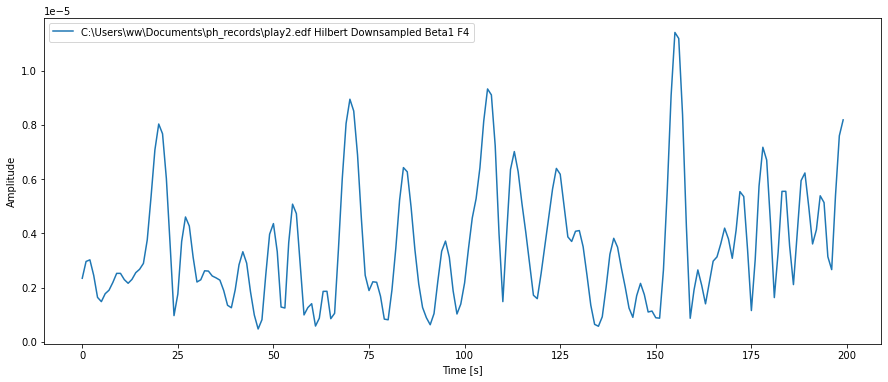

<Figure size 432x288 with 0 Axes>

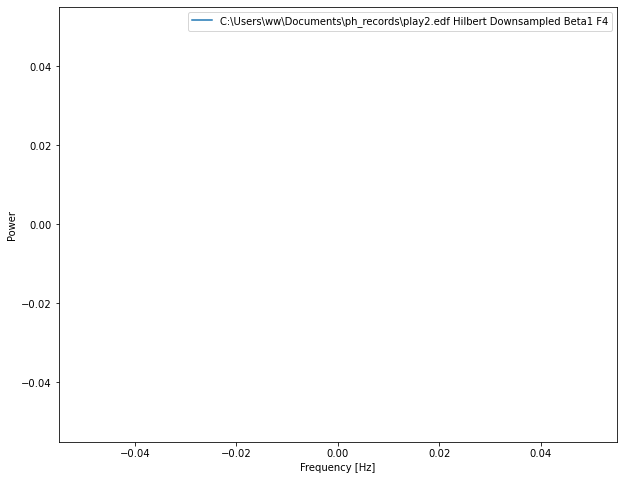

<Figure size 432x288 with 0 Axes>

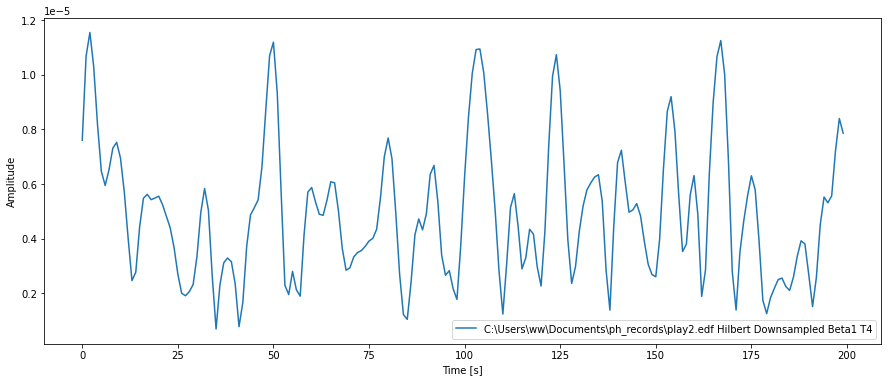

<Figure size 432x288 with 0 Axes>

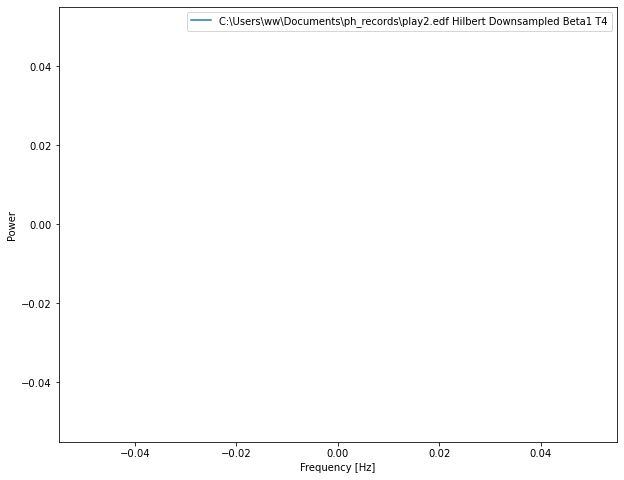

<Figure size 432x288 with 0 Axes>

In [96]:
# Порисуем файлы, выставляем корректно lables
# Посмотрим на значения сигнала после сокращения частоты сэмплирования по конкретным полосам и каналам

# Рисуем любой массив сигнала
# Рисуем спектр любого массива сигнала
# в цикле по всем каналам 
for chan in range(0,nchan-1):
    draw_signal(downsampled_hilbert_beta1_signal[chan][200:400],200,1,edffile_main4+' Hilbert Downsampled Beta1 '+raw_mne4.ch_names[chan])
    draw_spectr(downsampled_hilbert_beta1_signal[chan],sample_rate_main4,edffile_main4+' Hilbert Downsampled Beta1 '+raw_mne4.ch_names[chan])

In [ ]:
# Блоки дальше - для рисования картинок внизу

In [136]:
# считаем взвешенные распределения значений по частотам по обоим файлам

# ставим по максимальному порогу из двух
max_chan = 0.0002
# все значения распределяем на 100 корзин/ячеек, аля % распределения по 100% до 0.0002
number_levels = 100

all_bands_tables_percentage_state1 = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state2 = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state3 = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state4 = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state5 = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state6 = np.empty((6,nchan,number_levels),dtype=np.object)

all_bands_tables_percentage_state1 = create_percent_table(file_with_record1[:11625],sample_rate1,11625,downsampled_coeff,max_chan,number_levels)
all_bands_tables_percentage_state2 = create_percent_table(new_file_with_record2,sample_rate2,length2,downsampled_coeff,max_chan,number_levels)
all_bands_tables_percentage_state3 = create_percent_table(new_file_with_record3,sample_rate3,length3,downsampled_coeff,max_chan,number_levels)
all_bands_tables_percentage_state4 = create_percent_table(new_file_with_record4[:11375],sample_rate4,11375,downsampled_coeff,max_chan,number_levels)
all_bands_tables_percentage_state5 = create_percent_table(new_file_with_record5,sample_rate5,length5,downsampled_coeff,max_chan,number_levels)
all_bands_tables_percentage_state6 = create_percent_table(new_file_with_record6,sample_rate6,length6,downsampled_coeff,max_chan,number_levels)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\4281321153.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_bands_tables_percentage_state1 = np.empty((6,nchan,number_levels),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\4281321153.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_bands_tables_percentage_state2 = np.empty((6,nchan,number_levels),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\4281321153.py:10: DeprecationWarning:

Signal bands created
Hilbert Channel 0 completed
Hilbert Channel 1 completed
Hilbert Channel 2 completed
Hilbert Channel 3 completed
Hilbert Channel 4 completed
Hilbert Channel 5 completed
Hilbert completed
Downsampled completed


C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1989598692.py:69: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  table_chans_percent_delta = np.empty((nchan,_number_levels),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1989598692.py:70: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  table_chans_percent_theta = np.empty((nchan,_number_levels),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1989598692.py:71: DeprecationWarning: `np.object` is a 

Percentage distribution completed
All bands processing completed
Signal bands created
Hilbert Channel 0 completed
Hilbert Channel 1 completed
Hilbert Channel 2 completed
Hilbert Channel 3 completed
Hilbert Channel 4 completed
Hilbert Channel 5 completed
Hilbert completed


C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1989598692.py:83: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_bands_tables_percentage = np.empty((6,nchan,_number_levels),dtype=np.object)


Downsampled completed
Percentage distribution completed
All bands processing completed
Signal bands created
Hilbert Channel 0 completed
Hilbert Channel 1 completed
Hilbert Channel 2 completed
Hilbert Channel 3 completed
Hilbert Channel 4 completed
Hilbert Channel 5 completed
Hilbert completed
Downsampled completed
Percentage distribution completed
All bands processing completed
Signal bands created
Hilbert Channel 0 completed
Hilbert Channel 1 completed
Hilbert Channel 2 completed
Hilbert Channel 3 completed
Hilbert Channel 4 completed
Hilbert Channel 5 completed
Hilbert completed
Downsampled completed
Percentage distribution completed
All bands processing completed
Signal bands created
Hilbert Channel 0 completed
Hilbert Channel 1 completed
Hilbert Channel 2 completed
Hilbert Channel 3 completed
Hilbert Channel 4 completed
Hilbert Channel 5 completed
Hilbert completed
Downsampled completed
Percentage distribution completed
All bands processing completed
Signal bands created
Hilbert Ch

In [137]:
# считаем разницу между состояниями для рисования
#all_bands_tables_percentage_difference_state = np.empty((6,nchan,number_levels),dtype=np.object)
all_bands_tables_percentage_state = all_bands_tables_percentage_state1 - all_bands_tables_percentage_state5

In [138]:
# Получаем из распределения по 100 ячеек - одно качественное значение для рисования 
# значения амплитуды по одному каналу для одной картинки (если делать видео, то )
weightedhead_chans_delta = np.empty((nchan,1),dtype=np.object)
weightedhead_chans_theta = np.empty((nchan,1),dtype=np.object)
weightedhead_chans_alpha = np.empty((nchan,1),dtype=np.object)
weightedhead_chans_beta1 = np.empty((nchan,1),dtype=np.object)
weightedhead_chans_beta2 = np.empty((nchan,1),dtype=np.object)
weightedhead_chans_gamma = np.empty((nchan,1),dtype=np.object)

# сюда опционально заносим или % распределение по 1му состоянию, или по 2му или разницу
weightedhead_chans_delta = weightedhead_chans(all_bands_tables_percentage_state[0],number_levels)
weightedhead_chans_theta = weightedhead_chans(all_bands_tables_percentage_state[1],number_levels)
weightedhead_chans_alpha = weightedhead_chans(all_bands_tables_percentage_state[2],number_levels)
weightedhead_chans_beta1 = weightedhead_chans(all_bands_tables_percentage_state[3],number_levels)
weightedhead_chans_beta2 = weightedhead_chans(all_bands_tables_percentage_state[4],number_levels)
weightedhead_chans_gamma = weightedhead_chans(all_bands_tables_percentage_state[5],number_levels)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3164893048.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weightedhead_chans_delta = np.empty((nchan,1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3164893048.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weightedhead_chans_theta = np.empty((nchan,1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\3164893048.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builti

In [139]:
print(weightedhead_chans_delta)
print(weightedhead_chans_theta)
print(weightedhead_chans_alpha)
print(weightedhead_chans_beta1)
print(weightedhead_chans_beta2)
print(weightedhead_chans_gamma)

[[-5.825]
 [0.21900000000000053]
 [-3.2319999999999998]
 [0.2859999999999996]
 [-1.5370000000000001]
 [1.602]]
[[-3.641]
 [0.3640000000000001]
 [-3.037]
 [-0.769]
 [-1.0320000000000003]
 [0.057000000000000065]]
[[-0.8100000000000003]
 [0.501]
 [-2.4700000000000006]
 [-1.496]
 [-0.4790000000000001]
 [-0.1270000000000002]]
[[-0.09500000000000008]
 [1.0759999999999998]
 [-1.8190000000000006]
 [-1.199]
 [1.3299999999999998]
 [0.05400000000000009]]
[[1.293000000000001]
 [1.6749999999999998]
 [-1.2830000000000001]
 [-0.7270000000000004]
 [2.5199999999999996]
 [0.4999999999999999]]
[[4.407000000000001]
 [3.1550000000000002]
 [-0.5609999999999999]
 [-0.07499999999999993]
 [3.8080000000000007]
 [1.447]]


In [140]:
nchan_aug = 20

# Дополняем обычные электроды воображаемыми, для лучшей картинки
augumented_weightedhead_chans_delta = np.empty((nchan_aug,1),dtype=np.object)
augumented_weightedhead_chans_theta = np.empty((nchan_aug,1),dtype=np.object)
augumented_weightedhead_chans_alpha = np.empty((nchan_aug,1),dtype=np.object)
augumented_weightedhead_chans_beta1 = np.empty((nchan_aug,1),dtype=np.object)
augumented_weightedhead_chans_beta2 = np.empty((nchan_aug,1),dtype=np.object)
augumented_weightedhead_chans_gamma = np.empty((nchan_aug,1),dtype=np.object)

augumented_weightedhead_chans_delta = augumenting_electrodes(weightedhead_chans_delta,1)
augumented_weightedhead_chans_theta = augumenting_electrodes(weightedhead_chans_theta,1)
augumented_weightedhead_chans_alpha = augumenting_electrodes(weightedhead_chans_alpha,1)
augumented_weightedhead_chans_beta1 = augumenting_electrodes(weightedhead_chans_beta1,1)
augumented_weightedhead_chans_beta2 = augumenting_electrodes(weightedhead_chans_beta2,1)
augumented_weightedhead_chans_gamma = augumenting_electrodes(weightedhead_chans_gamma,1)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1606950411.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  augumented_weightedhead_chans_delta = np.empty((nchan_aug,1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1606950411.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  augumented_weightedhead_chans_theta = np.empty((nchan_aug,1),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1606950411.py:6: DeprecationWarning: `np.object` is a d

In [141]:
# смотрим значения, чтобы прикинуть шкалы для отображения
print(augumented_weightedhead_chans_delta)
print(augumented_weightedhead_chans_theta)
print(augumented_weightedhead_chans_alpha)
print(augumented_weightedhead_chans_beta1)
print(augumented_weightedhead_chans_beta2)
print(augumented_weightedhead_chans_gamma)

[[-0.7997874999999999]
 [-0.7365]
 [0.013862499999999896]
 [-3.2319999999999998]
 [0.2859999999999996]
 [-1.6159999999999999]
 [0.1429999999999998]
 [0.05475000000000013]
 [0.21900000000000053]
 [0.10950000000000026]
 [-0.7685000000000001]
 [-1.5370000000000001]
 [-0.38425000000000004]
 [-2.9125]
 [0.801]
 [-5.825]
 [1.602]
 [-1.4480375]
 [-1.05575]
 [0.3428625]]
[[-0.7455999999999999]
 [-0.9515]
 [-0.23095000000000002]
 [-3.037]
 [-0.769]
 [-1.5185]
 [-0.3845]
 [0.09100000000000003]
 [0.3640000000000001]
 [0.18200000000000005]
 [-0.5160000000000001]
 [-1.0320000000000003]
 [-0.25800000000000006]
 [-1.8205]
 [0.028500000000000032]
 [-3.641]
 [0.057000000000000065]
 [-0.8966]
 [-0.896]
 [-0.02444999999999999]]
[[-0.5987125000000002]
 [-0.9915000000000002]
 [-0.3919625]
 [-2.4700000000000006]
 [-1.496]
 [-1.2350000000000003]
 [-0.748]
 [0.12525]
 [0.501]
 [0.2505]
 [-0.23950000000000005]
 [-0.4790000000000001]
 [-0.11975000000000002]
 [-0.40500000000000014]
 [-0.0635000000000001]
 [-0.81

In [154]:
# Задаем шкалы для рисования
min_main = -3.2
max_main = 4
step_main = 0.1

max_delta = max_main
step_delta = step_main
max_theta = max_main
step_theta = step_main
max_alpha = max_main
step_alpha = step_main
max_beta1 = max_main
step_beta1 = step_main
max_beta2 = max_main
step_beta2 = step_main
max_gamma = max_main
step_gamma = step_main

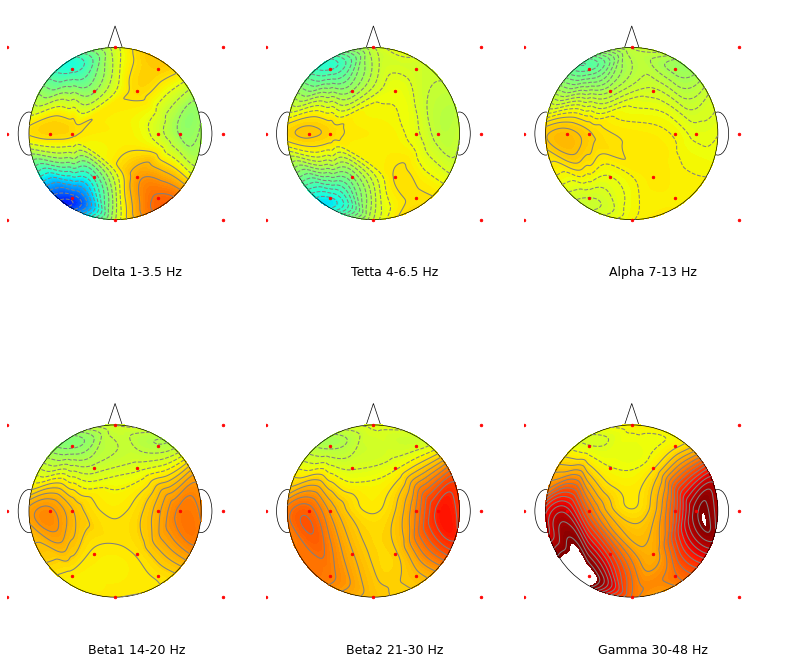

<Figure size 432x288 with 0 Axes>

In [155]:
# Рисуем одну картинку
# Дополненные координаты с воображаемыми электродами для хорошего рисования
koord_aug = [[0,5],[2.5,5],[5,5],
             [1.5,4.5],[3.5,4.5],
             [2,4],[3,4],
             [0,3],[1,3],[1.5,3],[3.5,3],[4,3],[5,3],
             [2,2],[3,2],
             [1.5,1.5],[3.5,1.5],
             [0,1],[2.5,1],[5,1]]

end_point = 1
counter = 0
time_points = np.arange(counter,end_point,1)

fig = plt.figure(figsize=(20,20), dpi = 50)
gs = gridspec.GridSpec(2, 3)

for time_point in time_points:
    x_counter = 0
    y_counter = 0
    for one_time in range(0,6):
        # Берем набор значений сигнала для рисования
        point_amplitude = []        
        if (x_counter==0 and y_counter==0):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_delta[chan][time_point])
                level_points = np.arange(min_main,max_delta+step_delta,step_delta)
        if (x_counter==0 and y_counter==1):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_theta[chan][time_point])
                level_points = np.arange(min_main,max_theta+step_theta,step_theta)
        if (x_counter==0 and y_counter==2):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_alpha[chan][time_point])
                level_points = np.arange(min_main,max_alpha+step_alpha,step_alpha)
        if (x_counter==1 and y_counter==0):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_beta1[chan][time_point])
                level_points = np.arange(min_main,max_beta1+step_beta1,step_beta1)
        if (x_counter==1 and y_counter==1):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_beta2[chan][time_point])
                level_points = np.arange(min_main,max_beta2+step_beta2,step_beta2)
        if (x_counter==1 and y_counter==2):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_weightedhead_chans_gamma[chan][time_point])
                level_points = np.arange(min_main,max_gamma+step_gamma,step_gamma)

        N = 200             # number of points for interpolation
        xy_center = [2.5,3]   # center of the plot
        radius = 2          # radius

        x,y = [],[]
        for i in koord_aug:
            x.append(i[0])
            y.append(i[1])
        z = point_amplitude
        xi = np.linspace(0, 5, N)
        yi = np.linspace(0, 5, N)
        zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
        for i in range(N):
            for j in range(N):
                #if zi[j,i] < 0:
                #    zi[j,i] = 0
                if (x_counter==0 and y_counter==0) and zi[j,i] > max_delta:
                    zi[j,i] = max_delta-0.1
                if (x_counter==0 and y_counter==1) and zi[j,i] > max_theta:
                    zi[j,i] = max_theta
                if (x_counter==0 and y_counter==2) and zi[j,i] > max_alpha:
                    zi[j,i] = max_alpha                
                if (x_counter==1 and y_counter==0) and zi[j,i] > max_beta1:
                    zi[j,i] = max_beta1
                if (x_counter==1 and y_counter==1) and zi[j,i] > max_beta2:
                    zi[j,i] = max_beta2
                if (x_counter==1 and y_counter==2) and zi[j,i] > max_gamma:
                    zi[j,i] = max_gamma        
        # set points > radius to not-a-number. They will not be plotted.
        # the dr/2 makes the edges a bit smoother
        dr = xi[1] - xi[0]
        for i in range(N):
            for j in range(N):
                r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
                if (r - dr/2) > radius:
                    zi[j,i] = "nan"

        # set aspect = 1 to make it a circle
        ax = plt.subplot(gs[x_counter,y_counter], aspect = 1)
        if (x_counter==0 and y_counter==0):
            plt.xlabel('Delta '+str(bands_freq["delta_min"])+'-'+str(bands_freq["delta_max"])+' Hz', fontsize=18)
        if (x_counter==0 and y_counter==1):
            plt.xlabel('Tetta '+str(bands_freq["theta_min"])+'-'+str(bands_freq["theta_max"])+' Hz', fontsize=18)
        if (x_counter==0 and y_counter==2):
            plt.xlabel('Alpha '+str(bands_freq["alpha_min"])+'-'+str(bands_freq["alpha_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==0):
            plt.xlabel('Beta1 '+str(bands_freq["beta1_min"])+'-'+str(bands_freq["beta1_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==1):
            plt.xlabel('Beta2 '+str(bands_freq["beta2_min"])+'-'+str(bands_freq["beta2_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==2):
            plt.xlabel('Gamma '+str(bands_freq["gamma_min"])+'-'+str(bands_freq["gamma_max"])+' Hz', fontsize=18)
        
        y_counter += 1
        if (y_counter == 3 and x_counter == 0):
            x_counter = 1
            y_counter = 0
        
        # use different number of levels for the fill and the lines
        CS = ax.contourf(xi, yi, zi, level_points, cmap = plt.cm.jet, zorder = 1)
        ax.contour(xi, yi, zi, 15, colors = "grey", zorder = 2)
        
        # add the data points
        # I guess there are no data points outside the head...
        ax.scatter(x, y, marker = 'o', c = 'r', s = 15, zorder = 3)
        # draw a circle
        circle = matplotlib.patches.Circle(xy = xy_center, radius = radius, edgecolor = "k", facecolor = "none")
        ax.add_patch(circle)
        # make the axis invisible 
        for loc, spine in ax.spines.items():
            spine.set_linewidth(0)
        # remove the ticks
        ax.set_xticks([])
        ax.set_yticks([])
        # Add some body parts. Hide unwanted parts by setting the zorder low
        # add two ears
        circle = matplotlib.patches.Ellipse(xy = [0.5,3], width = 0.5, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(circle)
        circle = matplotlib.patches.Ellipse(xy = [4.5,3], width = 0.5, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(circle)
        # add a nose
        xy = [[2,4], [2.5,5.5],[3,4]]
        polygon = matplotlib.patches.Polygon(xy = xy, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(polygon) 
        # set axes limits
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('C:\\Users\\ww\\Documents\\ph_in_pr\\' + str(counter).zfill(6) + '_fig.jpeg')

    # make a color bar
    #cbar = fig.colorbar(CS, ax=ax)
    
    plt.show()
    counter += 1
    plt.clf()
    gc.collect()

In [ ]:
# Повторяем ряд шагов для рисования набора картинок - т.к. идет рисование не по усредненным, а по предобработанным

In [156]:
# внимательно ставим все параметры для обработки 
length_main = len(file_with_record4[0])
file_with_record_main = file_with_record4
sample_rate_main = sample_rate4
edffile_main = edffile_state4


# Создаем сигналы по выбранным наборам частот
delta_signal = np.empty((nchan,length_main),dtype=np.object)
theta_signal = np.empty((nchan,length_main),dtype=np.object)
alpha_signal = np.empty((nchan,length_main),dtype=np.object)
beta1_signal = np.empty((nchan,length_main),dtype=np.object)
beta2_signal = np.empty((nchan,length_main),dtype=np.object)
gamma_signal = np.empty((nchan,length_main),dtype=np.object)

# Обратите внимание на значения частот в фильтре пропускания
for chan in range(0,nchan):
    delta_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["delta_min"],bands_freq["delta_max"],sample_rate_main,4)
    theta_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["theta_min"],bands_freq["theta_max"],sample_rate_main,5)
    alpha_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["alpha_min"],bands_freq["alpha_max"],sample_rate_main,5)
    beta1_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["beta1_min"],bands_freq["beta1_max"],sample_rate_main,6)
    beta2_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["beta2_min"],bands_freq["beta2_max"],sample_rate_main,8)
    gamma_signal[chan] = butter_bandpass_filter(file_with_record_main[chan],bands_freq["gamma_min"],bands_freq["gamma_max"],sample_rate_main,9)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2457477602.py:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta_signal = np.empty((nchan,length_main),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2457477602.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta_signal = np.empty((nchan,length_main),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\2457477602.py:11: DeprecationWarning: `np.object` is a deprecated alias for the builtin 

In [157]:
# работаем с огибающей - преобразование Гильберта
hilbert_delta_signal = np.empty((nchan,length_main),dtype=np.object)
hilbert_theta_signal = np.empty((nchan,length_main),dtype=np.object)
hilbert_alpha_signal = np.empty((nchan,length_main),dtype=np.object)
hilbert_beta1_signal = np.empty((nchan,length_main),dtype=np.object)
hilbert_beta2_signal = np.empty((nchan,length_main),dtype=np.object)
hilbert_gamma_signal = np.empty((nchan,length_main),dtype=np.object)

for chan in range(0,nchan):
    hilbert_delta_signal[chan] = np.abs(hilbert(delta_signal[chan]))
    hilbert_theta_signal[chan] = np.abs(hilbert(theta_signal[chan]))
    hilbert_alpha_signal[chan] = np.abs(hilbert(alpha_signal[chan]))
    hilbert_beta1_signal[chan] = np.abs(hilbert(beta1_signal[chan]))
    hilbert_beta2_signal[chan] = np.abs(hilbert(beta2_signal[chan]))
    hilbert_gamma_signal[chan] = np.abs(hilbert(gamma_signal[chan]))
    print('Channel ' + str(chan) + ' completed')

Channel 0 completed
Channel 1 completed
Channel 2 completed
Channel 3 completed
Channel 4 completed
Channel 5 completed


C:\Users\ww\AppData\Local\Temp\ipykernel_33668\537635829.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_delta_signal = np.empty((nchan,length_main),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\537635829.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hilbert_theta_signal = np.empty((nchan,length_main),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\537635829.py:4: DeprecationWarning: `np.object` is a deprecated alias for t

In [158]:
# Параметры для дальнейшего использования
downsampled_coeff = 5 # адаптируем для человеческого глаза 25 кадров в секунду 125/5

# уменьшаем размерность сигнала для рисования
downsampled_length = int(round(length_main/downsampled_coeff,0))

downsampled_hilbert_delta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_theta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_alpha_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_beta1_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_beta2_signal = np.empty((nchan,downsampled_length),dtype=np.object)
downsampled_hilbert_gamma_signal = np.empty((nchan,downsampled_length),dtype=np.object)

for chan in range(0,nchan):
    counter_downsampled = 0
    for i in range(0,length_main,downsampled_coeff):
        temp_sum_delta = 0
        temp_sum_theta = 0
        temp_sum_alpha = 0
        temp_sum_beta1 = 0
        temp_sum_beta2 = 0
        temp_sum_gamma = 0
        for j in range(0,downsampled_coeff,1):
            temp_sum_delta += hilbert_delta_signal[chan][i+j]
            temp_sum_theta += hilbert_theta_signal[chan][i+j]
            temp_sum_alpha += hilbert_alpha_signal[chan][i+j]
            temp_sum_beta1 += hilbert_beta1_signal[chan][i+j]
            temp_sum_beta2 += hilbert_beta2_signal[chan][i+j]
            temp_sum_gamma += hilbert_gamma_signal[chan][i+j]
        downsampled_hilbert_delta_signal[chan][counter_downsampled] = temp_sum_delta/downsampled_coeff
        downsampled_hilbert_theta_signal[chan][counter_downsampled] = temp_sum_theta/downsampled_coeff
        downsampled_hilbert_alpha_signal[chan][counter_downsampled] = temp_sum_alpha/downsampled_coeff
        downsampled_hilbert_beta1_signal[chan][counter_downsampled] = temp_sum_beta1/downsampled_coeff
        downsampled_hilbert_beta2_signal[chan][counter_downsampled] = temp_sum_beta2/downsampled_coeff
        downsampled_hilbert_gamma_signal[chan][counter_downsampled] = temp_sum_gamma/downsampled_coeff
        counter_downsampled += 1

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\964618054.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  downsampled_hilbert_delta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\964618054.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  downsampled_hilbert_theta_signal = np.empty((nchan,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\964618054.py:9: DeprecationWarning: `

In [159]:
nchan_aug = 20

# Дополняем обычные электроды воображаемыми, для лучшей картинки
augumented_downsampled_hilbert_delta_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
augumented_downsampled_hilbert_theta_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
augumented_downsampled_hilbert_alpha_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
augumented_downsampled_hilbert_beta1_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
augumented_downsampled_hilbert_beta2_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
augumented_downsampled_hilbert_gamma_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)

augumented_downsampled_hilbert_delta_signal = augumenting_electrodes(downsampled_hilbert_delta_signal,downsampled_length)
augumented_downsampled_hilbert_theta_signal = augumenting_electrodes(downsampled_hilbert_theta_signal,downsampled_length)
augumented_downsampled_hilbert_alpha_signal = augumenting_electrodes(downsampled_hilbert_alpha_signal,downsampled_length)
augumented_downsampled_hilbert_beta1_signal = augumenting_electrodes(downsampled_hilbert_beta1_signal,downsampled_length)
augumented_downsampled_hilbert_beta2_signal = augumenting_electrodes(downsampled_hilbert_beta2_signal,downsampled_length)
augumented_downsampled_hilbert_gamma_signal = augumenting_electrodes(downsampled_hilbert_gamma_signal,downsampled_length)

C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1279292275.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  augumented_downsampled_hilbert_delta_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\1279292275.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  augumented_downsampled_hilbert_theta_signal = np.empty((nchan_aug,downsampled_length),dtype=np.object)
C:\Users\ww\AppData\Local\Temp\ipykernel_33668\12792

In [160]:
# смотрим максимальные и минимальные значения амплитуд по всем записям и каналам, чтобы подобрать корректные шкалы
# !!! тут нужны другие значения, т.к. мы работаем не с усредненными и взвешенными, а с оригинальными значениями
for chan in range(0,nchan):
    print('Delta Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(augumented_downsampled_hilbert_delta_signal[chan]))))
    print('Delta Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(augumented_downsampled_hilbert_delta_signal[chan]))))
    
for chan in range(0,nchan):
    print('Theta Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(downsampled_hilbert_theta_signal[chan]))))
    print('Theta Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(downsampled_hilbert_theta_signal[chan]))))
    
for chan in range(0,nchan):
    print('Alpha Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(downsampled_hilbert_alpha_signal[chan]))))
    print('Alpha Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(downsampled_hilbert_alpha_signal[chan]))))

for chan in range(0,nchan):
    print('Beta1 Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(downsampled_hilbert_beta1_signal[chan]))))
    print('Beta1 Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(downsampled_hilbert_beta1_signal[chan]))))
    
for chan in range(0,nchan):
    print('Beta2 Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(downsampled_hilbert_beta2_signal[chan]))))
    print('Beta2 Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(downsampled_hilbert_beta2_signal[chan]))))
    
for chan in range(0,nchan):
    print('Gamma Min  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.min(downsampled_hilbert_gamma_signal[chan]))))
    print('Gamma Max  '+raw_mne1.ch_names[chan]+': '+str("{:.9f}".format(np.max(downsampled_hilbert_gamma_signal[chan]))))

Delta Min  O1: 0.000000132
Delta Max  O1: 0.000024732
Delta Min  T3: 0.000000163
Delta Max  T3: 0.000044984
Delta Min  F3: 0.000000096
Delta Max  F3: 0.000021340
Delta Min  F4: 0.000000110
Delta Max  F4: 0.000096768
Delta Min  T4: 0.000000096
Delta Max  T4: 0.000083167
Delta Min  O2: 0.000000055
Delta Max  O2: 0.000048384
Theta Min  O1: 0.000000099
Theta Max  O1: 0.000021320
Theta Min  T3: 0.000000129
Theta Max  T3: 0.000021601
Theta Min  F3: 0.000000063
Theta Max  F3: 0.000071331
Theta Min  F4: 0.000000128
Theta Max  F4: 0.000068055
Theta Min  T4: 0.000000065
Theta Max  T4: 0.000028941
Theta Min  O2: 0.000000134
Theta Max  O2: 0.000015951
Alpha Min  O1: 0.000000331
Alpha Max  O1: 0.000021533
Alpha Min  T3: 0.000000176
Alpha Max  T3: 0.000023857
Alpha Min  F3: 0.000000153
Alpha Max  F3: 0.000110718
Alpha Min  F4: 0.000000279
Alpha Max  F4: 0.000107110
Alpha Min  T4: 0.000000312
Alpha Max  T4: 0.000031239
Alpha Min  O2: 0.000000275
Alpha Max  O2: 0.000022286
Beta1 Min  O1: 0.000000182
B

In [162]:
# Задаем шкалы для рисования
min_main = 0
max_main = 0.000111
step_main = 0.00001

max_delta = max_main
step_delta = step_main
max_theta = max_main
step_theta = step_main
max_alpha = max_main
step_alpha = step_main
max_beta1 = max_main
step_beta1 = step_main
max_beta2 = max_main
step_beta2 = step_main
max_gamma = max_main
step_gamma = step_main

KeyboardInterrupt: 

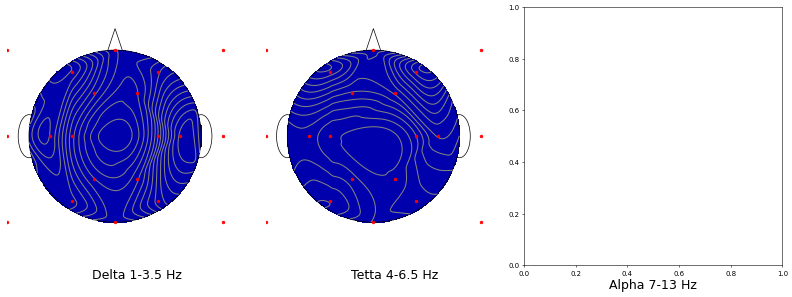

In [163]:
# Рисуем все картинки по записи для создания видео
# Дополненные координаты с воображаемыми электродами для хорошего рисования
koord_aug = [[0,5],[2.5,5],[5,5],
             [1.5,4.5],[3.5,4.5],
             [2,4],[3,4],
             [0,3],[1,3],[1.5,3],[3.5,3],[4,3],[5,3],
             [2,2],[3,2],
             [1.5,1.5],[3.5,1.5],
             [0,1],[2.5,1],[5,1]]

end_point = downsampled_length
counter = 0
time_points = np.arange(counter,end_point,1)

fig = plt.figure(figsize=(20,20), dpi = 50)
gs = gridspec.GridSpec(2, 3)

for time_point in time_points:
    x_counter = 0
    y_counter = 0
    for one_time in range(0,6):
        # Берем набор значений сигнала для рисования
        point_amplitude = []        
        if (x_counter==0 and y_counter==0):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_delta_signal[chan][time_point])
                level_points = np.arange(min_main,max_delta+step_delta,step_delta)
        if (x_counter==0 and y_counter==1):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_theta_signal[chan][time_point])
                level_points = np.arange(min_main,max_theta+step_theta,step_theta)
        if (x_counter==0 and y_counter==2):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_alpha_signal[chan][time_point])
                level_points = np.arange(min_main,max_alpha+step_alpha,step_alpha)
        if (x_counter==1 and y_counter==0):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_beta1_signal[chan][time_point])
                level_points = np.arange(min_main,max_beta1+step_beta1,step_beta1)
        if (x_counter==1 and y_counter==1):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_beta2_signal[chan][time_point])
                level_points = np.arange(min_main,max_beta2+step_beta2,step_beta2)
        if (x_counter==1 and y_counter==2):
            for chan in range(nchan_aug):
                point_amplitude.append(augumented_downsampled_hilbert_gamma_signal[chan][time_point])
                level_points = np.arange(min_main,max_gamma+step_gamma,step_gamma)

        N = 200             # number of points for interpolation
        xy_center = [2.5,3]   # center of the plot
        radius = 2          # radius

        x,y = [],[]
        for i in koord_aug:
            x.append(i[0])
            y.append(i[1])
        z = point_amplitude
        xi = np.linspace(0, 5, N)
        yi = np.linspace(0, 5, N)
        zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
        for i in range(N):
            for j in range(N):
                if zi[j,i] < 0:
                    zi[j,i] = 0
                if (x_counter==0 and y_counter==0) and zi[j,i] > max_delta:
                    zi[j,i] = max_delta-0.1
                if (x_counter==0 and y_counter==1) and zi[j,i] > max_theta:
                    zi[j,i] = max_theta
                if (x_counter==0 and y_counter==2) and zi[j,i] > max_alpha:
                    zi[j,i] = max_alpha                
                if (x_counter==1 and y_counter==0) and zi[j,i] > max_beta1:
                    zi[j,i] = max_beta1
                if (x_counter==1 and y_counter==1) and zi[j,i] > max_beta2:
                    zi[j,i] = max_beta2
                if (x_counter==1 and y_counter==2) and zi[j,i] > max_gamma:
                    zi[j,i] = max_gamma        
        # set points > radius to not-a-number. They will not be plotted.
        # the dr/2 makes the edges a bit smoother
        dr = xi[1] - xi[0]
        for i in range(N):
            for j in range(N):
                r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
                if (r - dr/2) > radius:
                    zi[j,i] = "nan"

        # set aspect = 1 to make it a circle
        ax = plt.subplot(gs[x_counter,y_counter], aspect = 1)
        if (x_counter==0 and y_counter==0):
            plt.xlabel('Delta '+str(bands_freq["delta_min"])+'-'+str(bands_freq["delta_max"])+' Hz', fontsize=18)
        if (x_counter==0 and y_counter==1):
            plt.xlabel('Tetta '+str(bands_freq["theta_min"])+'-'+str(bands_freq["theta_max"])+' Hz', fontsize=18)
        if (x_counter==0 and y_counter==2):
            plt.xlabel('Alpha '+str(bands_freq["alpha_min"])+'-'+str(bands_freq["alpha_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==0):
            plt.xlabel('Beta1 '+str(bands_freq["beta1_min"])+'-'+str(bands_freq["beta1_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==1):
            plt.xlabel('Beta2 '+str(bands_freq["beta2_min"])+'-'+str(bands_freq["beta2_max"])+' Hz', fontsize=18)
        if (x_counter==1 and y_counter==2):
            plt.xlabel('Gamma '+str(bands_freq["gamma_min"])+'-'+str(bands_freq["gamma_max"])+' Hz', fontsize=18)
        
        y_counter += 1
        if (y_counter == 3 and x_counter == 0):
            x_counter = 1
            y_counter = 0
        
        # use different number of levels for the fill and the lines
        CS = ax.contourf(xi, yi, zi, level_points, cmap = plt.cm.jet, zorder = 1)
        ax.contour(xi, yi, zi, 15, colors = "grey", zorder = 2)
        
        # add the data points
        # I guess there are no data points outside the head...
        ax.scatter(x, y, marker = 'o', c = 'r', s = 15, zorder = 3)
        # draw a circle
        circle = matplotlib.patches.Circle(xy = xy_center, radius = radius, edgecolor = "k", facecolor = "none")
        ax.add_patch(circle)
        # make the axis invisible 
        for loc, spine in ax.spines.items():
            spine.set_linewidth(0)
        # remove the ticks
        ax.set_xticks([])
        ax.set_yticks([])
        # Add some body parts. Hide unwanted parts by setting the zorder low
        # add two ears
        circle = matplotlib.patches.Ellipse(xy = [0.5,3], width = 0.5, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(circle)
        circle = matplotlib.patches.Ellipse(xy = [4.5,3], width = 0.5, height = 1.0, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(circle)
        # add a nose
        xy = [[2,4], [2.5,5.5],[3,4]]
        polygon = matplotlib.patches.Polygon(xy = xy, edgecolor = "k", facecolor = "w", zorder = 0)
        ax.add_patch(polygon) 
        # set axes limits
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('C:\\Users\\ww\\Documents\\Ph\\' + str(counter).zfill(6) + '_fig.jpeg')

    # make a color bar
    #cbar = fig.colorbar(CS, ax=ax)

    counter += 1
    plt.clf()
    gc.collect()

In [ ]:
import cv2
import os

image_folder = 'C:\\Users\\ww\\Documents\\Ph\\'
video_name = 'C:\\Users\\ww\\Documents\\video\\outpy.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpeg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 40, (width,height))

for image in images: 
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()